In [1]:
#%matplotlib notebook
#%matplotlib inline
#matplotlib.interactive(True)
%gui qt

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib import rcParams
import matplotlib.animation as animation
from matplotlib.widgets import Slider
import sys
sys.path.append("/lib/python2.7/site-packages/")
sys.path.append("/lib64/python2.7/site-packages/")
sys.path.append("/anaconda2/lib/python2.7/site-packages")
sys.path.append("/home/simon/Documents/Projects/Astrophysics/LOFAR/Tomography/tools21cm-master/src/")
import time
import scipy
from IPython.display import HTML
import pandas as pd
import numpy as np
import math
import cmath
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
import json
import ipyvolume as ipv
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits  # We use fits to open the actual data file
from random import uniform, shuffle, randint
from pyquaternion import Quaternion
from scipy import stats
import csv
from itertools import dropwhile, takewhile
import os
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import sklearn.cluster
from scipy.signal import savgol_filter
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
import skimage
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse
import tools21cm as t2c
# rcParams['font.family'] = 'serif'
# rcParams['font.sans-serif'] = ['Computer Modern']
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['STIX']})
plt.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams.update({'text.usetex':True, 'text.latex.preamble':[r'\usepackage{amsmath, newtxmath}']})

import scipy.stats as st
import brewer2mpl
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

In [2]:
#Some functions

def make_rand_vector(dims):
    vec = [uniform(-1, 1) for i in range(dims)]
    mag = sum(x**2 for x in vec) ** .5
    return [x/mag for x in vec]

def best_angle(rot_i,qA,qB):
    qRot = Quaternion(0,0,0,0)
    qRot[rot_i] = 1
    qC = qB * qRot
    qdist = qA[0]*qC[0] + qA[1]*qC[1] +qA[2]*qC[2] +qA[3]*qC[3]
    qRot[rot_i] = -1
    qC = qB * qRot
    qdist = max(qdist, qA[0]*qC[0] + qA[1]*qC[1] +qA[2]*qC[2] +qA[3]*qC[3])
    return qdist
    #return 2*qdist**2-1
    
def find_scale(bins, nbins, value):
    upper = nbins-1
    lower = 0
    if (value >= bins[upper]):
        return upper
    mid = (upper + lower) / 2
    while (mid!=lower):
        if(value >= bins[mid]):
            lower = mid
        else:
            upper = mid
        mid = (upper + lower) / 2
    return lower

def load_binary_data(filename, dtype=np.float32): 
    """ 
    We assume that the data was written 
    with write_binary_data() (little endian). 
    """ 
    f = open(filename, "rb") 
    data = f.read() 
    f.close() 
    _data = np.fromstring(data, dtype) 

    return _data


def max_entropy(data):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    M. Emre Celebi
    06.15.2007
    Ported to ImageJ plugin by G.Landini from E Celebi's fourier_0.8 routines
    2016-04-28: Adapted for Python 2.7 by Robert Metchev from Java source of MaxEntropy() in the Autothresholder plugin
    http://rsb.info.nih.gov/ij/plugins/download/AutoThresholder.java
    :param data: Sequence representing the histogram of the image
    :return threshold: Resulting maximum entropy threshold
    """

    # calculate CDF (cumulative density function)
    cdf = data.astype(np.float).cumsum()
    #print cdf
    # find histogram's nonzero area
    valid_idx = np.nonzero(data)[0]
    first_bin = valid_idx[0]
    last_bin = valid_idx[-1]

    # initialize search for maximum
    max_ent, threshold = 0, 0

    for it in range(first_bin, last_bin + 1):
        # Background (dark)
        hist_range = data[:it + 1]
        hist_range = hist_range[hist_range != 0] / cdf[it]  # normalize within selected range & remove all 0 elements
        tot_ent = -np.sum(hist_range * np.log(hist_range))  # background entropy

        # Foreground/Object (bright)
        hist_range = data[it + 1:]
        # normalize within selected range & remove all 0 elements
        hist_range = hist_range[hist_range != 0] / (cdf[last_bin] - cdf[it])
        tot_ent -= np.sum(hist_range * np.log(hist_range))  # accumulate object entropy

        # find max
        if tot_ent > max_ent:
            max_ent, threshold = tot_ent, it

    return threshold

def gauss_kernel(size, sigma=1.0, fwhm=None):
	''' 
	Generate a normalized gaussian kernel, defined as
	exp(-(x^2 + y^2)/(2sigma^2)).
	
	
	Parameters:
		* size (int): Width of output array in pixels.
		* sigma = 1.0 (float): The sigma parameter for the Gaussian.
		* fwhm = None (float or None): The full width at half maximum.
				If this parameter is given, it overrides sigma.
		
	Returns:
		numpy array with the Gaussian. The dimensions will be
		size x size or size x sizey depending on whether
		sizey is set. The Gaussian is normalized so that its
		integral is 1.	
	'''
	
	if fwhm != None:
		sigma = fwhm/(2.*np.sqrt(2.*np.log(2)))

	if size % 2 == 0:
		size = int(size/2)
		x,y = np.mgrid[-size:size, -size:size]
	else:
		size = int(size/2)
		x,y = np.mgrid[-size:size+1, -size:size+1]
	
	g = np.exp(-(x**2 + y**2)/(2.*sigma**2))

	return g/g.sum()




In [ ]:
# C2RAY SAVING PICKLE

import pickle
dict = pickle.load(open('Simulations/C2Ray/LB1_bright_temp.pkl', 'r'))
print dict[0.5]
hdu = fits.PrimaryHDU(dict[0.2])
hdul = fits.HDUList([hdu])
hdul.writeto('Simulations/C2Ray/LB1_bright_temp_0.2.fits')

+++++++++++++++++++

# POWER SPECTRUM FUNCTIONS

+++++++++++++++++++++++

In [ ]:
#Open PLOT FITS Files

import matplotlib.gridspec as gridspec


directory = 'Simulations/Mock30/'
indensfile = [#'dens_nf095.fits',\
              'dens_nf09.fits',\
              #'dens_nf08.fits',\
              'dens_nf07.fits',\
              'dens_nf05.fits']
#indensfile = ['dens_z13_slice.fits',\
 #             'dens_z11_slice.fits',\
 #             'dens_z10_slice.fits',\
 #             'dens_z09_slice.fits',\
 #             'dens_z08_slice.fits']
#mylegend3 = [r'z = 11',r'z = 10', r'z = 9',r'z = 8.8',r'z = 8.3']
fig = plt.figure(figsize=(40,20))
plt.subplots_adjust(hspace=0.2)

gs = gridspec.GridSpec(1, 4,width_ratios=[1,1,1,0.91])


hduin  = fits.open('Simulations/Mock30/z9.220000.fits')[0]
hduin2  = fits.open('Simulations/Mock30/z9.220000_noise.fits')[0]
hduin3  = fits.open('Simulations/Mock30/z9.220000_obs.fits')[0]
hduin4  = fits.open('Simulations/Mock30/obs_hii_z9.220000.fits')[0]


# hduin  = fits.open('21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_gauss2/21cmobsgauss_z9.000000.fits')[0]
# hduin2  = fits.open('21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_new/21cmobs_z9.000000.fits')[0]
# hduin3  = fits.open('Simulations/Mock30/z9.220000_obs.fits')[0]
# hduin4  = fits.open('Simulations/Mock30/obs_hii_z9.220000.fits')[0]

fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#ax =plt.subplot(gs[0])# plt.subplot(141)

#plt.axis('off')
#plt.title(r'$\delta T_{\rm b}$ simulated', fontsize=30)
cs = plt.imshow(hduin2.data[:,:,50], cmap='hot')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=30) 
cbar.ax.set_title(r'mK',size = 30)
plt.title(r'Faint Galaxy model', fontsize=35)
plt.xlabel('Mpc',size=35)
plt.tick_params(labelsize=30)
plt.ylabel('Mpc',size=35)
#plt.xticks([0,128,256,384,512],[0,256,512,768,1024])
#plt.yticks([0,128,256,384,512],[0,256,512,768,1024])
ax.invert_yaxis()
#plt.savefig('fggaussz9.pdf', bbox_inches='tight')

fig = plt.figure(figsize=(10,10))
ax = plt.gca() 
#ax = plt.subplot(gs[1])#plt.subplot(142)
#plt.title(mylegend3[ii], fontsize=40)
cs = plt.imshow(hduin.data[:,:,50], cmap='hot')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=30) 
cbar.ax.set_title(r'mK',size = 30)
plt.title(r'Bright Galaxy model', fontsize=35)
plt.xlabel('Mpc',size=35)
plt.tick_params(labelsize=30)
#plt.ylabel('Mpc',size=20)
#plt.xticks([0,128,256,384,512],[0,256,512,768,1024])
#plt.yticks([0,128,256,384,512],[0,256,512,768,1024])
#plt.yticks(visible =False)

ax.invert_yaxis()
#plt.savefig('ggmodelz9.pdf', bbox_inches='tight')

#fig = plt.figure(figsize=(10,10))
# ax = plt.subplot(gs[2])#plt.subplot(143)

#plt.title('Segmented [0-1] mk', fontsize=40)
cs = plt.imshow(hduin3.data[:,:,100], cmap='hot')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=30)
cbar.ax.set_title(r'mK',size = 30)
plt.title(r'$\delta T_{\rm b}$+noise smoothed (B = 2km)', fontsize=35)
plt.xlabel('Mpc',size=35)
plt.tick_params(labelsize=30)
#plt.ylabel('Mpc',size=20)
plt.xticks([0,128,256,384,512],[0,256,512,768,1024])
plt.yticks([0,128,256,384,512],[0,256,512,768,1024])
plt.yticks(visible =False)
ax.invert_yaxis()

#plt.savefig('final.pdf', bbox_inches='tight')

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(gs[3])#plt.subplot(144)
#plt.title('Segmented [0-1] mk', fontsize=40)
cs = plt.imshow(hduin4.data[:,:,100], cmap='gray')
plt.xticks([0,128,256,384,512],[0,256,512,768,1024])
plt.yticks([0,128,256,384,512],[0,256,512,768,1024])
plt.yticks(visible =False)

plt.xlabel('Mpc',size=35)
plt.tick_params(labelsize=30)
#plt.ylabel('Mpc',size=20)
plt.title(r'Recovered H II regions', fontsize=35)
#cs.fig.subplots_adjust(top=1.05,bottom=-0.05,left=-0.05,right=1.05)
#plt.set_size_inches(w=11,h=7)

ax.invert_yaxis()
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title(r'$\delta T_{\rm b}$',size = 20)


plt.axis('off')
#plt.savefig('image_cube.pdf', bbox_inches='tight')
#plt.savefig('Images/200mpcR2V0_img.pdf', bbox_inches='tight')# Simulation 3 256 Mpc, RSAGE compare


In [46]:
print np.sum(hduin.data < 1) / 512.**3


0.14298643916845322


In [ ]:
#Open and plot diff Files


hduin  = fits.open('Simulations/Mock_128_R25/z10.000000.fits')[0]
hduin2  = fits.open('Simulations/Mock_128_R15/z9.000000.fits')[0]
hduin3  = fits.open('Simulations/Mock_128_R8/z9.000000.fits')[0]


fig = plt.figure(figsize=(30,20))
ax = plt.subplot(131)

cs = plt.imshow(hduin.data[:,:,10], cmap='plasma')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_title(r'mK',size = 20)
#plt.title(r'', fontsize=30)

ax = plt.subplot(132)

#plt.axis('off')
#plt.title(r'z = 9', fontsize=30)
cs = plt.imshow(hduin2.data[:,:,10], cmap='plasma')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_title(r'mK',size = 20)

ax = plt.subplot(133)

#plt.title(r'z=8', fontsize=30)
cs = plt.imshow(hduin3.data[:,:,10], cmap='plasma')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_title(r'mK',size = 20)

fig = plt.figure(figsize=(20,20))


ax = plt.subplot(121)

#plt.axis('off')
plt.title(r'Diff with R = 8 (R = 15 fidu) (z = 8)', fontsize=30)
cs = plt.imshow(hduin.data[:,:,10]-hduin2.data[:,:,10], cmap='plasma')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_title(r'mK',size = 20)

ax = plt.subplot(122)

plt.title(r'Diff with R = 25 (R = 15 fidu)', fontsize=30)
cs = plt.imshow(hduin.data[:,:,10]-hduin3.data[:,:,10], cmap='plasma')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_title(r'mK',size = 20)

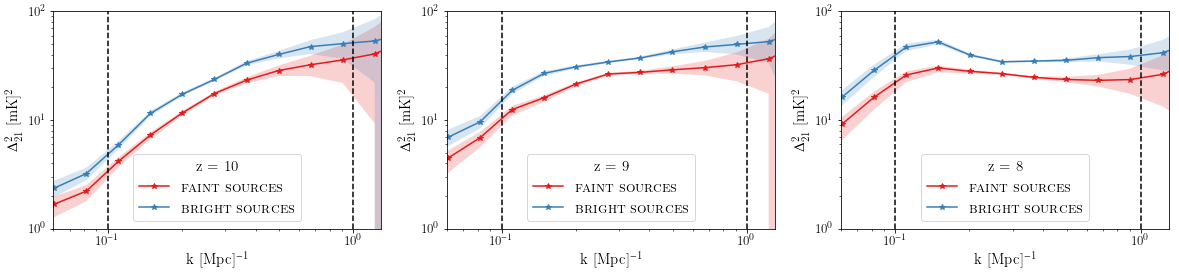

In [5]:
#Plot Power spectrum smooth + noise

bmap = brewer2mpl.get_map('Set1', 'qualitative', 3)
colors = bmap.mpl_colors

Directory_faint = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_new/'
Directory_bright = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_200/'

#MockObsDirectory = '21CMMC/3params_128/'

kmap = np.logspace(-2,1,24)
z_arr = [10,9,8]
plt.figure(figsize=(20,4))
sum1 = 0
boxsize = 256
ncells = 128
PS = []
for ii in range(len(z_arr)):
    
    z = z_arr[ii]
   
    Sample_PS_values = np.nanmedian(PS, axis = 0)
    Sample_PS_err = np.nanstd(PS, axis = 0)

    NoiseFileName_f = '21CMMC/21CMMC_Voronoi/Programs/NoiseData/PS_SKA_128/mock_new/Total_PS_error_z%1.6f.txt'%(z_arr[ii])
    NoiseFileName_b = '21CMMC/21CMMC_Voronoi/Programs/NoiseData/PS_SKA_128/mock_200/Total_PS_error_z%1.6f.txt'%(z_arr[ii])

    MockObsPsFileName = 'delTps_estimate_1.000000_1.000000_'

    Sample_PS_f = np.loadtxt('%s/%s%1.6f.txt'%( Directory_faint, MockObsPsFileName,   z_arr[ii]), usecols=(1,))
    Sample_PS_b = np.loadtxt('%s/%s%1.6f.txt'%( Directory_bright, MockObsPsFileName,   z_arr[ii]), usecols=(1,))
    Sample_k_f = np.loadtxt('%s/%s%1.6f.txt'%( Directory_faint, MockObsPsFileName,   z_arr[ii]), usecols=(0,))

    Sample_Error_k_values = np.loadtxt(NoiseFileName_f, usecols=(0,))
    Sample_Error_PS_values_f = np.nan_to_num(np.loadtxt(NoiseFileName_f, usecols=(1,)))
    Sample_Error_PS_values_b = np.nan_to_num(np.loadtxt(NoiseFileName_b, usecols=(1,)))

    splined_faint = interpolate.splrep(Sample_k_f,np.log10( Sample_PS_f),s=0)
    splined_bright = interpolate.splrep(Sample_k_f,np.log10( Sample_PS_b),s=0)
    splined_error_f = interpolate.splrep(Sample_Error_k_values,np.log10( Sample_Error_PS_values_f),s=0)
    splined_error_b = interpolate.splrep(Sample_Error_k_values,np.log10( Sample_Error_PS_values_b),s=0)


    PS_faint = 10**(interpolate.splev(kmap,splined_faint,der=0))
    PS_bright = 10**(interpolate.splev(kmap,splined_bright,der=0))


    ErrorPS_f = 10**(interpolate.splev(kmap,splined_error_f,der=0))
    ErrorPS_b = 10**(interpolate.splev(kmap,splined_error_b,der=0))

    ax = plt.subplot(1, len(z_arr), ii+1)
    plt.loglog(kmap, PS_faint, label=r'\textsc{faint sources}', marker='*', color = colors[0])
    plt.loglog(kmap, PS_bright, label=r'\textsc{bright sources}', marker='*', color = colors[1])

    ax.fill_between(kmap, np.nan_to_num(PS_faint + ErrorPS_f),PS_faint, alpha=0.2, facecolor=colors[0], interpolate=True)
    ax.fill_between(kmap,  np.nan_to_num(PS_faint - ErrorPS_b), PS_faint, alpha=0.2, facecolor=colors[0], interpolate=True)
 
    ax.fill_between(kmap, np.nan_to_num(PS_bright + ErrorPS_b),PS_bright, alpha=0.2, facecolor=colors[1], interpolate=True)
    ax.fill_between(kmap,  np.nan_to_num(PS_bright - ErrorPS_b), PS_bright, alpha=0.2, facecolor=colors[1], interpolate=True)

    plt.xlim(0.06,1.3)
    plt.ylim(1,100)
    plt.axvline(x=0.1, color = 'k', ls = '--')
    plt.axvline(x=1., color = 'k', ls = '--')
    plt.xlabel(r'k [Mpc]$^{-1}$', fontsize=15)
    plt.ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=15)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 13)

    l = plt.legend(title = 'z = %d'%(z_arr[ii]), fontsize=15)
    l.get_title().set_fontsize(15)
    plt.savefig('Mock_PS.pdf', bbox_inches='tight')



In [ ]:
# Create Total error array (thermal + variance)
bmap = brewer2mpl.get_map('Dark2', 'qualitative', 3)
colors = bmap.mpl_colors

MockObsDirectory = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_200/'
MockObsPsFileName = 'delTps_estimate_1.000000_1.000000_'
MockObsNfFileName = 'NeutralFraction_1.000000_1.000000_'

kmap = np.logspace(-1.2,0.2,15)
z_arr = [10,9,8,7,6.5,6]
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5,wspace = 0.4)

for i in range(len(z_arr)):
    NoiseFileName = '21CMMC/21CMMC_SourceCode/Programs/NoiseData/PS_SKA_128/ps3d_th_noise_ska_z%1.6f_u0_1000.txt'%(z_arr[i])
    Sample_k_values = np.loadtxt('%s/%s%1.6f.txt'%(MockObsDirectory, MockObsPsFileName, z_arr[i]), usecols=(0,))
    Sample_PS_values =np.loadtxt('%s/%s%1.6f.txt'%(MockObsDirectory, MockObsPsFileName, z_arr[i]), usecols=(1,))
    
    Sample_Error_PS_values =  np.loadtxt('%s/%s%1.6f.txt'%(MockObsDirectory, MockObsPsFileName, z_arr[i]), usecols=(2,))
    nf = np.loadtxt('%s/%s%1.6f.txt'%(MockObsDirectory, MockObsNfFileName, z_arr[i]))
    Thermal_Error_k_values = np.loadtxt('%s'%(NoiseFileName), usecols=(2,))
    Thermal_Error_k_values = Thermal_Error_k_values/0.7
    Thermal_Error_PS_values = np.loadtxt('%s'%(NoiseFileName), usecols=(5,))
    Thermal_Error_PS_values = Thermal_Error_PS_values/100

    #print Thermal_Error_k_values
    #print Thermal_Error_PS_values
    splined_thermal = interpolate.splrep(Thermal_Error_k_values,np.log10(Thermal_Error_PS_values),s=0)
    splined_sample = interpolate.splrep(Sample_k_values,np.log10( Sample_Error_PS_values),s=0)
    splined_val = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_values),s=0)
 

    PS_val = 10**(interpolate.splev(kmap,splined_val,der=0))
    ErrorPS_val = np.sqrt((10**(interpolate.splev(kmap,splined_thermal,der=0)))**2 \
                      + (10**(interpolate.splev(kmap,splined_sample,der=0)))**2)
    ax = plt.subplot(len(z_arr)/3+1, 3, i+1)
    plt.loglog(kmap, PS_val, label='Fesc = 0.3', marker='x', color = 'b')
    ax.fill_between(kmap, np.nan_to_num(PS_val + ErrorPS_val),PS_val, alpha=0.2, facecolor='b', interpolate=True)
    ax.fill_between(kmap,  np.nan_to_num(PS_val - ErrorPS_val), PS_val, alpha=0.2, facecolor='b', interpolate=True)
    plt.xlim(0.0,1.1)
    plt.ylim(0,200)
    plt.axvline(x=0.1, color = 'k')
    plt.axvline(x=1., color = 'k')
    plt.xlabel(r'k [Mpc]$^{-1}$', fontsize=13)
    plt.ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=13)
    plt.title(r'z = %1.2f, x$_{HII}$ = %f'%(z_arr[i], 1-nf), fontsize=13)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 15)
        
    
#print ErrorPS_val
    zipped = zip(kmap,ErrorPS_val)
    np.savetxt('Total_PS_error_z%1.6f.txt'%(z_arr[i]),  zipped, fmt='%f %f')
    plt.savefig('Mock_PS.pdf')

In [ ]:
#Create Power spectrum from smooth + noise


MockObsDirectory = '21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/'

kmap = np.logspace(-1,0,8)
z_arr = [10,9,8]
plt.figure(figsize=(20,5))
sum1 = 0
boxsize = 256
ncells = 128
for ii in range(len(z_arr)):   

    uv_map = np.loadtxt('%s/NoiseData/UVmap_SKA/128/uv_map_z%1.6f.txt'%(Directory,z), ndmin=2)
    noise = t2c.noise_cube_coeval(ncells, z, obs_time=1000, boxsize=boxsize, total_int_time=6.,\
                                      int_time=10., declination=-30., uv_map=uv_map, N_ant=512, \
                                      verbose=False, fft_wrap=False)
        
        
        
    command = "./disccoman/polyImage ps temp fits 256"
    os.system(command)
    
    hdu = fits.PrimaryHDU(img1)
    hdul = fits.HDUList([hdu])
    hdul.writeto('temp1.fits', overwrite='true')

    command = "./disccoman/polyImage ps temp1 fits 256"

    os.system(command)
    
    MockObsPsFileName = 'delTps_estimate_1.000000_1.000000_'

    NoiseFileName = '21CMMC/21CMMC_SourceCode/Programs/NoiseData/PS_SKA_128/Total_PS_error_z%1.6f.txt'%(z_arr[ii])

    MockObsPsFileName = 'temp_ps'
    MockObsPsFileName = 'temp1_ps'
    Sample_k_values = np.loadtxt('temp_ps', usecols=(0,))
    Sample_PS_values = np.loadtxt('temp_ps', usecols=(1,))
   
    Sample_PS_t1 = np.loadtxt('temp1_ps', usecols=(1,))
    

    
    Sample_Error_k_values = np.loadtxt(NoiseFileName, usecols=(0,))
    Sample_Error_PS_values = np.nan_to_num(np.loadtxt(NoiseFileName, usecols=(1,)))

    splined_error = interpolate.splrep(Sample_Error_k_values,np.log10( Sample_Error_PS_values),s=0)
    splined_val = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_values),s=0)
    splined_t1 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_t1),s=0)
    #splined_t2 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_t2),s=0)
  #  splined_t3 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_t3),s=0)
  #  splined_t4 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_t4),s=0)
    #splined_mod = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_mod),s=0)
    #splined_mod_err = interpolate.splrep(Sample_k_values,np.log10( Sample_Err_mod),s=0)


    PS_val = 10**(interpolate.splev(kmap,splined_val,der=0))
    t1_val = 10**(interpolate.splev(kmap,splined_t1,der=0))
    #t2_val = 10**(interpolate.splev(kmap,splined_t2,der=0))
  #  t3_val = 10**(interpolate.splev(kmap,splined_t3,der=0))
  #  t4_val = 10**(interpolate.splev(kmap,splined_t4,der=0))
   # mod_val = 10**(interpolate.splev(kmap,splined_mod,der=0))

    ErrorPS_val = np.sqrt(10**(interpolate.splev(kmap,splined_error,der=0))**2)

    #PS_val2 =PS_val2/kernel_val
    ax = plt.subplot(1, len(z_arr), ii+1)
    plt.loglog(kmap, PS_val, label='Fesc = 0.3', marker='x', color = 'g')
    plt.loglog(kmap, t1_val, label='Fesc = 0.3', marker='x', color = 'r')
   # plt.loglog(kmap, t2_val, label='Fesc = 0.3', marker='x', color = 'b')
   # plt.loglog(kmap, t3_val, label='Fesc = 0.3', marker='x', color = 'c')
   # plt.loglog(kmap, t4_val, label='Fesc = 0.3', marker='x', color = 'c')

    ax.fill_between(kmap, np.nan_to_num(t1_val + ErrorPS_val),t1_val, alpha=0.2, facecolor='g', interpolate=True)
    ax.fill_between(kmap,  np.nan_to_num(t1_val - ErrorPS_val), t1_val, alpha=0.2, facecolor='g', interpolate=True)
    plt.xlim(0.0,1.1)
    plt.ylim(00,200)
    plt.axvline(x=0.1, color = 'k')
    plt.axvline(x=1., color = 'k')
    plt.xlabel(r'k [Mpc]$^{-1}$', fontsize=13)
    plt.ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=13)
    plt.title('z = %f'%(z_arr[ii]), fontsize=13)
    
    sum1 += np.sum((PS_val-t1_val)**2/ErrorPS_val**2)



In [ ]:
#Check Error 21cmSense (Not working)

a = np.load('21cmSense-master/ska1low.track_1.0hr_opt_0.142.npz')
print a.files
toterr = a['T_errs']/1000
#toterr = np.nan_to_num(toterr)
print toterr
h = 0.7
kerrf = a['ks']

#f = open('21cmSense-master/ps_no_halos_nf0.521457_z9.50_useTs0_zetaX-1.0e+00_200_400Mpc_v2')
f = np.loadtxt('21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/delTps_estimate_1.000000_1.000000_10.000000.txt')
kbin = f[:,0]
kpow =  f[:,1]
kerr =  f[:,2]

model = f
mk, mpk = model[:,0]/h, model[:,1] #k, Delta^2(k)
print mk

#toterrf = np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/PS_128_256/ps3d_th_noise_ska_z10.000000_u0_1000.txt')
#kerrf2, toterr2, ps_th = np.nan_to_num(toterrf[:-1,2])*0.7, toterrf[:-1,5]/100, toterrf[:-1,4]/100

# print kerrf

kmap = np.linspace(0.1,1,8)
f1 = interp1d(kbin, kpow, fill_value = "extrapolate")
f1err = interp1d(kbin, kerr, fill_value = "extrapolate")
#f = interp1d(kerrf, ps_th, fill_value = "extrapolate")
ferr = interp1d(kerrf, toterr, fill_value = "extrapolate")

plt.figure()


# plt.loglog(a['ks'], f(a['ks']), label='Fesc = 0.2')
ax = plt.subplot(1, 1, 1)
plt.ylim(1,200)
plt.xlim(0.08,1.1)
toterrt = np.sqrt(ferr(kmap)**2 + (f1err(kmap))**2)
plt.loglog(kmap, f1(kmap), label='Fesc = 0.3', marker='x', color = 'g')
#plt.loglog(kmap, f(kmap), label='Fesc = 0.3', marker='x', color = 'r')

ax.fill_between(kmap, np.nan_to_num(f1(kmap) + toterrt),f1(kmap), alpha=0.2, facecolor='g', interpolate=True)
ax.fill_between(kmap,  np.nan_to_num(f1(kmap) - toterrt), f1(kmap), alpha=0.2, facecolor='g', interpolate=True)
plt.axvline(x=0.1, color = 'k')
plt.axvline(x=1., color = 'k')
xx = np.log10(kmap)
yy = np.log10(f1(kmap))
zz1 = np.log10(f1(kmap) + toterrt)
zz2 = np.log10(f1(kmap) - toterrt)
# ax = plt.subplot(1, 2, 2)

plt.xlabel(r'k [Mpc]$^{-1}$', fontsize=13)
plt.ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=13)


#toterrf = np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/GalaxyParams/Lightcone/TotalError_SKA_PS_500Mpc_z7.7264_1000hr.txt')
#kerrf, toterr = toterrf[:,0], toterrf[:,1]
#print toterr
#ferr = interp1d(kerrf, toterr, fill_value = "extrapolate")
# print f1err(kmap)
plt.figure()
ax = plt.subplot(1, 1, 1)
plt.ylim(1,200)
plt.xlim(0.08,1.1)
toterrt = np.sqrt(ferr(kmap)**2 + f1err(kmap)**2 + (0.2*f1(kmap))**2)

plt.loglog(kmap, f1(kmap), label='Fesc = 0.3', marker='x', color = 'g')
#plt.loglog(kmap, ps_th, label='Fesc = 0.3', marker='x', color = 'g')

ax.fill_between(kmap, np.nan_to_num(f1(kmap) + toterrt),f1(kmap), alpha=0.2, facecolor='g', interpolate=True)
ax.fill_between(kmap,  np.nan_to_num(f1(kmap) - toterrt), f1(kmap), alpha=0.2, facecolor='g', interpolate=True)
plt.axvline(x=0.1, color = 'k')
plt.axvline(x=1., color = 'k')
plt.xlabel(r'k [Mpc]$^{-1}$', fontsize=13)
plt.ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=13)
# xx = np.log10(kmap)
# yy = np.log10(f1(kmap))
# zz1 = np.log10(f1(kmap) + toterrt)
# zz2 = np.log10(f1(kmap) - toterrt)
# # ax = plt.subplot(1, 2, 2)

# plt.plot(xx, yy ,label='Fesc = 0.3', marker='x', color = 'g')
# ax.fill_between(xx, np.nan_to_num(zz1),yy, alpha=0.2, facecolor='g', interpolate=True)
# ax.fill_between(xx,  np.nan_to_num(zz2), yy, alpha=0.2, facecolor='g', interpolate=True)

Same likelihood model inf
Best likelihood model inf


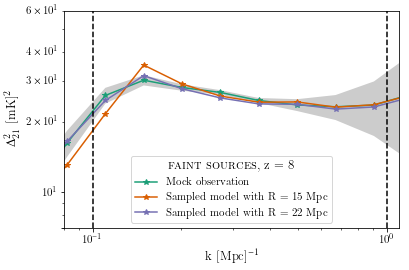

In [3]:
#Check Power spectrum diff models

bmap = brewer2mpl.get_map('Dark2', 'qualitative', 3)
colors = bmap.mpl_colors

MockObsDirectory = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_new/'
MockObsDirectory1 = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_univmcmc/'
MockObsDirectory2 = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_new_R22/'

kmap = np.logspace(-2,1,24)
z_arr = [8]
plt.figure(figsize=(6,4))
sum1 = 0
sum2 = 0

for i in range(len(z_arr)):
    MockObsPsFileName = 'delTps_estimate_1.000000_1.000000_'

    NoiseFileName = '21CMMC/21CMMC_Voronoi/Programs/NoiseData/PS_SKA_128/mock_new/Total_PS_error_z%1.6f.txt'%(z_arr[i])

    Sample_k_values = np.loadtxt('%s%s%1.6f.txt'%(MockObsDirectory,MockObsPsFileName, z_arr[i]), usecols=(0,))
    Sample_PS_values = np.loadtxt('%s%s%1.6f.txt'%(MockObsDirectory,MockObsPsFileName, z_arr[i]), usecols=(1,))
   
    Sample_PS_t1 = np.loadtxt('%s%s%1.6f.txt'%(MockObsDirectory1,MockObsPsFileName, z_arr[i]), usecols=(1,))
    Sample_PS_t2 = np.loadtxt('%s%s%1.6f.txt'%(MockObsDirectory2,MockObsPsFileName, z_arr[i]), usecols=(1,))
        
    Sample_Error_k_values = np.loadtxt(NoiseFileName, usecols=(0,))
    
    Sample_Error_PS_values =  np.nan_to_num(np.loadtxt(NoiseFileName, usecols=(1,)))
    
    splined_error = interpolate.splrep(Sample_Error_k_values,np.log10(Sample_Error_PS_values),s=0)
    splined_val = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_values),s=0)
    splined_t1 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_t1),s=0)
    splined_t2 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_t2),s=0)

    PS_val = 10**(interpolate.splev(kmap,splined_val,der=0))
    t1_val = 10**(interpolate.splev(kmap,splined_t1,der=0))
    t2_val = 10**(interpolate.splev(kmap,splined_t2,der=0))

    ErrorPS_val = 10**(interpolate.splev(kmap,splined_error,der=0))
    

    ax = plt.subplot(1, len(z_arr), i+1)
    plt.loglog(kmap, PS_val,  marker='*', color = colors[0], label = 'Mock observation')
    plt.loglog(kmap, t1_val,  marker='*', color = colors[1], label = 'Sampled model with R = 15 Mpc')
    plt.loglog(kmap, t2_val,  marker='*', color = colors[2], label = 'Sampled model with R = 22 Mpc')
    #plt.loglog(kmap, ErrorPS_val,  marker='', color = 'gray')


    ax.fill_between(kmap, np.nan_to_num(PS_val + ErrorPS_val),PS_val, alpha=0.4, facecolor='gray', interpolate=True)
    ax.fill_between(kmap,  np.nan_to_num(PS_val - ErrorPS_val), PS_val, alpha=0.4, facecolor='gray', interpolate=True)
    plt.xlim(0.08,1.1)
    plt.ylim(8,60)
    plt.axvline(x=0.1, color = 'k', ls = '--')
    plt.axvline(x=1., color = 'k', ls = '--')
    plt.xlabel(r'k [Mpc]$^{-1}$', fontsize=13)
    plt.ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=13)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 11)

    l =plt.legend(title = r'\textsc{faint sources}, z = %d'%(z_arr[i]), fontsize=11)
    l.get_title().set_fontsize(13)

    sum1 += np.sum((PS_val-t1_val)**2/ErrorPS_val**2)
    sum2 += np.sum((PS_val-t2_val)**2/ErrorPS_val**2)
    ax.set_yticks([7,10])
    #ax.set_yticklabels([1,10])
    #ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
   # yticks = ax.yaxis.get_major_ticks()
   # yticks[0].label1.set_visible(False)

print "Same likelihood model %f"%sum1
print "Best likelihood model %f"%sum2



# kmap =  np.zeros(8)

# for j in range(8):
#     kmap[j] = 0.1 + (1 - 0.1)*float(j)/(8 - 1)

# z_arr = [10,9,8]
# plt.figure(figsize=(20,5))
# sum1 = 0
# sum2 = 0

# for i in range(len(z_arr)):
#     MockObsPsFileName = 'delTps_estimate_1.000000_1.000000_'

#     NoiseFileName = '21CMMC/21CMMC_SourceCode/Programs/NoiseData/PS_SKA_128/Total_PS_error_z%1.6f.txt'%(z_arr[i])

#     Sample_k_values = np.loadtxt('%s%s%1.6f.txt'%(MockObsDirectory,MockObsPsFileName, z_arr[i]), usecols=(0,))
#     Sample_PS_values = np.loadtxt('%s%s%1.6f.txt'%(MockObsDirectory,MockObsPsFileName, z_arr[i]), usecols=(1,))
   
#     Sample_PS_t1 = np.loadtxt('%s%s%1.6f.txt'%(MockObsDirectory1,MockObsPsFileName, z_arr[i]), usecols=(1,))
#     Sample_PS_t2 = np.loadtxt('%s%s%1.6f.txt'%(MockObsDirectory2,MockObsPsFileName, z_arr[i]), usecols=(1,))
        
#     Sample_Error_k_values = np.loadtxt(NoiseFileName, usecols=(0,))
    
#     Sample_Error_PS_values =  np.nan_to_num(np.loadtxt(NoiseFileName, usecols=(1,)))
    
#     splined_error = interpolate.splrep(Sample_Error_k_values,np.log10(Sample_Error_PS_values),s=0)
#     splined_val = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_values),s=0)
#     splined_t1 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_t1),s=0)
#     splined_t2 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_t2),s=0)

#     PS_val = 10**(interpolate.splev(kmap,splined_val,der=0))
#     t1_val = 10**(interpolate.splev(kmap,splined_t1,der=0))
#     t2_val = 10**(interpolate.splev(kmap,splined_t2,der=0))
    
#     ErrorPS_val = np.sqrt((10**(interpolate.splev(kmap,splined_error,der=0)))**2)
    

#     ax = plt.subplot(1, len(z_arr), i+1)
#     plt.loglog(kmap, PS_val,  marker='x', color = 'g')
#     plt.loglog(kmap, t1_val,  marker='x', color = 'r')
#     plt.loglog(kmap, t2_val,  marker='x', color = 'b')


#     ax.fill_between(kmap, np.nan_to_num(t1_val + ErrorPS_val),t1_val, alpha=0.2, facecolor='g', interpolate=True)
#     ax.fill_between(kmap,  np.nan_to_num(t1_val - ErrorPS_val), t1_val, alpha=0.2, facecolor='g', interpolate=True)
#     plt.xlim(0.0,1.1)
#     plt.ylim(0,200)
#     plt.axvline(x=0.1, color = 'k')
#     plt.axvline(x=1., color = 'k')
#     plt.xlabel(r'k [Mpc]$^{-1}$', fontsize=13)
#     plt.ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=13)
#     plt.title('z = %f'%(z_arr[i]), fontsize=13)
    
#     sum1 += np.sum((PS_val-t1_val)**2/ErrorPS_val**2)
#     sum2 += np.sum((PS_val-t2_val)**2/ErrorPS_val**2)


# print "Same likelihood model %f"%sum1
# print "Best likelihood model %f"%sum2
plt.savefig('error_ps_z8.pdf', bbox_inches='tight')


In [4]:
#Plot Power spectrum smooth + noise

bmap = brewer2mpl.get_map('Set1', 'qualitative', 3)
colors = bmap.mpl_colors

Directory_faint = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_new/'
Directory_bright = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_gauss/'
#MockObsDirectory = '21CMMC/3params_128/'

kmap = np.logspace(-2,1,24)
z_arr = [10,9,8]
#plt.figure(figsize=(20,4))
sum1 = 0
boxsize = 256
ncells = 128
PS = []
# fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4), 
#                   gridspec_kw={"width_ratios":[2.3,1.5,1.5,1.5]})
# plt.subplots_adjust(wspace=0.1, hspace=0)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), 
                  gridspec_kw={"width_ratios":[1.5,1.5]}, dpi = 1000)
plt.subplots_adjust(wspace=0.35, hspace=0.3)
w = 0
h= 0
for ii in range(len(z_arr)):
    z = z_arr[ii]
   
    Sample_PS_values = np.nanmedian(PS, axis = 0)
    Sample_PS_err = np.nanstd(PS, axis = 0)

    NoiseFileName_f = '21CMMC/21CMMC_Voronoi/Programs/NoiseData/PS_SKA_128/mock_new/Total_PS_error_z%1.6f.txt'%(z_arr[ii])
    NoiseFileName_b = '21CMMC/21CMMC_Voronoi/Programs/NoiseData/PS_SKA_128/mock_200/Total_PS_error_z%1.6f.txt'%(z_arr[ii])

    MockObsPsFileName = 'delTps_estimate_1.000000_1.000000_'

    Sample_PS_f = np.loadtxt('%s/%s%1.6f.txt'%( Directory_faint, MockObsPsFileName,   z_arr[ii]), usecols=(1,))
    Sample_PS_b = np.loadtxt('%s/%s%1.6f.txt'%( Directory_bright, MockObsPsFileName,   z_arr[ii]), usecols=(1,))
    Sample_k_f = np.loadtxt('%s/%s%1.6f.txt'%( Directory_faint, MockObsPsFileName,   z_arr[ii]), usecols=(0,))
    Sample_k_b = np.loadtxt('%s/%s%1.6f.txt'%( Directory_bright, MockObsPsFileName,   z_arr[ii]), usecols=(0,))

    Sample_Error_k_values = np.loadtxt(NoiseFileName_f, usecols=(0,))
    Sample_Error_PS_values_f = np.nan_to_num(np.loadtxt(NoiseFileName_f, usecols=(1,)))
    Sample_Error_PS_values_b = np.nan_to_num(np.loadtxt(NoiseFileName_b, usecols=(1,)))

    splined_faint = interpolate.splrep(Sample_k_f,np.log10( Sample_PS_f),s=0)
    splined_bright = interpolate.splrep(Sample_k_b,np.log10( Sample_PS_b),s=0)
    splined_error_f = interpolate.splrep(Sample_Error_k_values,np.log10( Sample_Error_PS_values_f),s=0)
    splined_error_b = interpolate.splrep(Sample_Error_k_values,np.log10( Sample_Error_PS_values_b),s=0)


    PS_faint = 10**(interpolate.splev(kmap,splined_faint,der=0))
    PS_bright = 10**(interpolate.splev(kmap,splined_bright,der=0))


    ErrorPS_f = 10**(interpolate.splev(kmap,splined_error_f,der=0))
    ErrorPS_b = 10**(interpolate.splev(kmap,splined_error_b,der=0))

    #ax = axes[ii+1]ax = axes[ii+1]
    ax = axes[(ii+1)/2][(ii+1)%2]

    ax.loglog(kmap, PS_faint, label=r'\textsc{faint sources}', marker='s', color = colors[0])
    ax.loglog(kmap, PS_bright, label=r'\textsc{faint sources + grf}', marker='o', color = colors[1])

    ax.fill_between(kmap, np.nan_to_num(PS_faint + ErrorPS_f),PS_faint, alpha=0.2, facecolor=colors[0], interpolate=True)
    ax.fill_between(kmap,  np.nan_to_num(PS_faint - ErrorPS_f), PS_faint, alpha=0.2, facecolor=colors[0], interpolate=True)
 
    ax.fill_between(kmap, np.nan_to_num(PS_bright + ErrorPS_b),PS_bright, alpha=0.2, facecolor=colors[1], interpolate=True)
    ax.fill_between(kmap,  np.nan_to_num(PS_bright - ErrorPS_b), PS_bright, alpha=0.2, facecolor=colors[1], interpolate=True)

    ax.set_xlim(0.06,1.3)
    ax.set_ylim(1,100)
    ax.axvline(x=0.1, color = 'k', ls = '--')
    ax.axvline(x=1., color = 'k', ls = '--')
    ax.set_xlabel(r'k [Mpc]$^{-1}$', fontsize=20)
   # if(ii == 0 ):
    ax.set_ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=20)
        #l.get_title().set_fontsize(13)
        
    #else:
        #ax.axes.yaxis.set_visible(False)
    #ax.tick_params(labelleft=False)    

    #if(ii == 1):
    l =ax.legend(fontsize=14, frameon=True, loc = 'lower center')
        
    ax.set_title(r"z = %d"%z_arr[ii], fontsize=20)

    ax.tick_params(axis = 'both', which = 'both', labelsize = 15)
#plt.savefig('Mock_gauss.pdf', bbox_inches='tight')


# name = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_new/delta_T_1.000000_1.000000_z8.000000_128_250Mpc'
# data = load_binary_data(name)
# data = data.reshape((int(ncells), int(ncells), int(ncells)), order='C')
# data.shape = (int(ncells), int(ncells), int(ncells))
# #ps, bins = t2c.power_spectrum_1d(data,100, box_dims=250)
# hdu = fits.PrimaryHDU(data)
# hdul = fits.HDUList([hdu])
# hdul.writeto('temp1.fits', overwrite='true')


# command = "./disccoman/polyImage ps temp1 fits 250"
# os.system(command)

# Sample_k_t1 = np.loadtxt('temp1_ps', usecols=(0,))
# Sample_PS_t1 = np.loadtxt('temp1_ps', usecols=(1,))

# plt.loglog(Sample_k_t1, Sample_PS_t1, c='b')

#plt.figure()
def fftIndgen(n):
    a = range(0, n/2+1)
    b = range(1, n/2)
    b.reverse()
    b = [-i for i in b]
    return a + b

def gaussian_random_field(Pk = lambda k : k**-3.0, size = 100):
    def Pk2(kx, ky, kz):
        if np.sqrt(kx**2 + ky**2 + kz**2) == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2 + kz**2)))
    noise = np.fft.fftn(np.random.normal(size = (size, size, size)))
    amplitude = np.zeros((size,size, size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):     
            for k, kz in enumerate(fftIndgen(size)): 
                amplitude[i, j, k] = Pk2(kx, ky, kz)
    return np.fft.ifftn(amplitude*noise)

#out = gaussian_random_field(Pk = lambda k: k**-2., size=128)
#plt.figure()
#print np.mean(out.real),np.var(out.real)
#out = 250*(out - np.mean(out))

#plt.imshow(np.fft.fftshift(np.fft.fftn(out))[:,100,:].real, interpolation='none')
#plt.colorbar()



# plt.figure()
# plt.loglog(Sample_k_t1, Sample_PS_t1)
# plt.xlim(0.06,1.3)

# plt.figure()

# hdu = fits.PrimaryHDU(out.real + data)
# hdul = fits.HDUList([hdu])
# hdul.writeto('21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_gauss2/obs_z8.fits', overwrite='true')
# command = "./disccoman/polyImage ps 21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_gauss2/obs_z8 fits 250"
# os.system(command)
# Sample_k_t1 = np.loadtxt('21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_gauss2/obs_z8_ps', usecols=(0,))
# Sample_PS_t1 = np.loadtxt('21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_gauss2/obs_z8_ps', usecols=(1,))
# plt.loglog(Sample_k_t1, Sample_PS_t1, c='g')
# plt.xlim(0.06,1.3)
# plt.ylim(1,100)

# plt.figure()
# out = (out - np.mean(out))/np.std(out)

# plt.imshow(out[:,:,0].real, interpolation='none', cmap = 'plasma')
# plt.colorbar()

# plt.figure(figsize=(10,10))
#hdu = fits.PrimaryHDU(out.real)
#hdul = fits.HDUList([hdu])
#hdul.writeto('temp.fits', overwrite='true')

# command = "./disccoman/polyImage ps temp fits 250"
# os.system(command)
# Sample_k_t1 = np.loadtxt('temp_ps', usecols=(0,))
# Sample_PS_t1 = np.loadtxt('temp_ps', usecols=(1,))
# plt.loglog(Sample_k_t1, Sample_PS_t1, c='g')
# #plt.loglog(Sample_k_t1, 1/(4*3.14)**2*Sample_k_t1**1.5)
# plt.loglog(Sample_k_t1, (Sample_k_t1)**2)

#ps, bins = t2c.power_spectrum_1d(out,100, box_dims=250)

#fig = plt.figure(figsize=(5,4))
#ax = plt.subplots(411)
ax = axes[0][0]
cs = ax.imshow(out[:,20,:].real, interpolation='none', cmap = 'hot')
cbar = plt.colorbar(cs, ax=[ax],  fraction=0.046, pad=0.03, location = 'left')
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title(r'mK',size = 15)
ax.set_title(r"GRF with P(k) $\propto$ k$^{-2}$", fontsize=20)
ax.set_xlabel(r'Mpc', fontsize=20)
#ax.set_ylabel(r'Mpc', fontsize=15)
#ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.tick_params(axis = 'both', labelsize = 15)
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
#
ax.locator_params(nbins=6)
#plt.show()
plt.savefig('img_gauss2.pdf', bbox_inches='tight', dpi = 1000)

[0.03153909 0.05298514 0.07478623 0.108247   0.1622756  0.2446756
 0.3667619  0.5503742  0.8260733  1.239322   1.771932  ]
[-1.99397318 -1.75019919 -1.35501067 -1.24111383 -1.07342745 -0.89874901
 -0.72997438 -0.54009586 -0.36926467 -0.19461035 -0.03791468]
[-0.26579945  1.08265696]
[[0.00810744 0.00733375]
 [0.00733375 0.01202932]]
0.5422512351190696


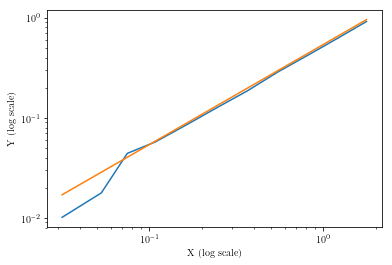

In [21]:
Sample_k_t1 = np.loadtxt('temp_ps', usecols=(0,))
Sample_PS_t1 = np.loadtxt('temp_ps', usecols=(1,))
print Sample_k_t1
print np.log10(Sample_PS_t1)

yerr = 0.2 * Sample_PS_t1                      # simulated errors (10%)

logx = np.log10(Sample_k_t1)
logy = np.log10(Sample_PS_t1)
logyerr = yerr / Sample_PS_t1

# define our (line) fitting function
fitfunc = lambda p, x:  p[0]+p[1]* x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = scipy.optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)
pfinal = out[0]
covar = out[1]
print pfinal
print covar

plt.loglog(Sample_k_t1, Sample_PS_t1)

#plt.loglog(Sample_k_t1, 10**pfinal[0]*Sample_k_t1**pfinal[1])
plt.loglog(Sample_k_t1, 0.54*Sample_k_t1)

#plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')
print 10**pfinal[0]

In [ ]:
# PS EWASS

allpow =[]
i = 0
for j in range(50):
    f = open('Simulations/Noise/test1000h/real'+str(j)+'_ps', "r")
    i = 0
    kbin1 = np.zeros(13)
    kpow = np.zeros(13)
    kerr = np.zeros(13)
    for line in f:
        kbin1[i], kpow[i], kerr[i] = map(float, line.split())
        i += 1
    nmodes = kpow/kerr
    allpow.append(kpow**2)
    

    
f = open('nf08_fesc01_ps')

kbin = np.zeros(13)
kpow = np.zeros(13)
kerr = np.zeros(13)
i = 0
for line in f:
    kbin[i], kpow[i], kerr[i] = map(float, line.split())
    i += 1

f1 = interp1d(kbin1, kpow, fill_value = "extrapolate")

errnoise =  np.sqrt(np.mean(allpow,0))/nmodes
#toterr = np.sqrt((errnoise)**2+kerr*4**2)
xx = f1(a['ks']) - ferr(a['ks'])
xx[np.isnan(xx)] = -2
ax = plt.subplot(1, 1, 1)

# plt.plot(np.log10(kbin1), np.log10(kpow), label='Fesc = 0.1', marker='x', color = 'b')
# ax.fill_between(np.log10(kbin1), np.log10(kpow + toterr), np.log10(kpow), alpha=0.2, facecolor='b', interpolate=True)
# ax.fill_between(np.log10(kbin1), xx, np.log10(kpow), alpha=0.2, facecolor='b', interpolate=True)
# plt.plot(np.log10(a['ks']), np.log10(f1(a['ks'])), label='Fesc = 0.3', marker='x', color = 'b')
# ax.fill_between(np.log10(a['ks']), np.log10(f1(a['ks']) + toterr), np.log10(f1(a['ks'])), alpha=0.2, facecolor='b', interpolate=True)
# ax.fill_between(np.log10(a['ks']),  xx, np.log10(f1(a['ks'])), alpha=0.2, facecolor='b', interpolate=True)
plt.loglog(a['ks'], f1(a['ks']), label='Fesc = 0.3', marker='x', color = 'b')
ax.fill_between(a['ks'], f1(a['ks']) + ferr(a['ks']),f1(a['ks']), alpha=0.2, facecolor='b', interpolate=True)
ax.fill_between(a['ks'],  xx, f1(a['ks']), alpha=0.2, facecolor='b', interpolate=True)
f = open('nf08_fesc02_ps')

kbin = np.zeros(13)
kpow = np.zeros(13)
kerr = np.zeros(13)
i = 0
for line in f:
    kbin[i], kpow[i], kerr[i] = map(float, line.split())
    i += 1

#errnoise =  np.mean(allpow,0)/nmodes
#toterr = np.sqrt((errnoise)**2+kerr*4**2)
f1 = interp1d(kbin1, kpow, fill_value = "extrapolate")

xx = f1(a['ks']) - ferr(a['ks'])


#xx = np.log10(kpow - toterr)
xx[np.isnan(xx)] = -2
ax = plt.subplot(1, 1, 1)

# plt.plot(np.log10(kbin1), np.log10(kpow), label='Fesc = 0.2', marker='x', color = 'r')
# ax.fill_between(np.log10(kbin1), np.log10(kpow + toterr), np.log10(kpow), alpha=0.2, facecolor='r', interpolate=True)
# ax.fill_between(np.log10(kbin1), xx, np.log10(kpow), alpha=0.2, facecolor='r', interpolate=True)
plt.loglog(a['ks'], f1(a['ks']), label='Fesc = 0.3', marker='x', color = 'r')
ax.fill_between(a['ks'], f1(a['ks']) + ferr(a['ks']),f1(a['ks']), alpha=0.2, facecolor='r', interpolate=True)
ax.fill_between(a['ks'],  xx, f1(a['ks']), alpha=0.2, facecolor='r', interpolate=True)
f = open('nf08_fesc03_ps')

kbin = np.zeros(13)
kpow = np.zeros(13)
kerr = np.zeros(13)
i = 0
for line in f:
    kbin[i], kpow[i], kerr[i] = map(float, line.split())
    i += 1
f1 = interp1d(kbin1, kpow, fill_value = "extrapolate")

#errnoise =  np.sqrt(np.mean(allpow,0))/nmodes
#toterr = np.sqrt((errnoise)**2+kerr*4**2)
xx = f1(a['ks']) - ferr(a['ks'])

#xx = np.log10(kpow - toterr)
xx[np.isnan(xx)] = -2
ax = plt.subplot(1, 1, 1)

# plt.plot(np.log10(kbin1), np.log10(kpow), label='Fesc = 0.3', marker='x', color = 'g')
# ax.fill_between(np.log10(kbin1), np.log10(kpow + toterr), np.log10(kpow), alpha=0.2, facecolor='g', interpolate=True)
# ax.fill_between(np.log10(kbin1), xx, np.log10(kpow), alpha=0.2, facecolor='g', interpolate=True)
plt.loglog(a['ks'], f1(a['ks']), label='Fesc = 0.3', marker='x', color = 'g')
ax.fill_between(a['ks'], f1(a['ks']) + ferr(a['ks']),f1(a['ks']), alpha=0.2, facecolor='g', interpolate=True)
ax.fill_between(a['ks'],  xx, f1(a['ks']), alpha=0.2, facecolor='g', interpolate=True)

plt.ylim(1,200)
plt.xlim(0.1,1.1)
plt.tick_params(axis = 'both', which = 'both', labelsize = 13)
# ax.fill_between(np.log10(kbin1), np.log10(kpow + toterr), np.log10(kpow), alpha=0.2, facecolor='g', interpolate=True)
# ax.fill_between(np.log10(kbin1), xx, np.log10(kpow), alpha=0.2, facecolor='g', interpolate=True)
plt.xlabel(r'k [Mpc]$^{-1}$', fontsize=13)
plt.ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=13)
ax.legend(labels = mylegend1, loc = 'upper', fontsize=10, frameon=False )
plt.axvline(x=0.15, color = 'k')
plt.axvline(x=1.0, color = 'k')

plt.savefig('ps_1000h.pdf', bbox_inches='tight')

In [ ]:
# Create Total error array (thermal + variance)

MockObsDirectory = 'Simulations'
MockObsPsFileName = 'delTps_estimate_1.000000_1.000000_'
MockObsNfFileName = 'NeutralFraction_1.000000_1.000000_'

kmap = np.logspace(-1.2,0.2,15)
z_arr = [10,9,8,7,6]
plt.figure(figsize=(50,7))
plt.subplots_adjust(hspace=0.5,wspace = 0.4)

for i in range(len(z_arr)):
    Sample_k_values = np.loadtxt('%s/Mock_128_R8/%s%1.6f.txt'%(MockObsDirectory, MockObsPsFileName, z_arr[i]), usecols=(0,))
    Sample_PS_values =np.loadtxt('%s/Mock_128_R8/%s%1.6f.txt'%(MockObsDirectory, MockObsPsFileName, z_arr[i]), usecols=(1,))
    Sample_PS_values1 =np.loadtxt('%s/Mock_128_R15/%s%1.6f.txt'%(MockObsDirectory, MockObsPsFileName, z_arr[i]), usecols=(1,))
    Sample_PS_values2 =np.loadtxt('%s/Mock_128_R25/%s%1.6f.txt'%(MockObsDirectory, MockObsPsFileName, z_arr[i]), usecols=(1,))

    splined_val = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_values),s=0)
    splined_val1 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_values1),s=0)
    splined_val2 = interpolate.splrep(Sample_k_values,np.log10( Sample_PS_values2),s=0)


    PS_val = 10**(interpolate.splev(kmap,splined_val,der=0))
    PS_val1 = 10**(interpolate.splev(kmap,splined_val1,der=0))
    PS_val2 = 10**(interpolate.splev(kmap,splined_val2,der=0))

    
    
    ax = plt.subplot(1, 5, i+1)
    plt.loglog(kmap, PS_val,  marker='x', color = colors[0])
    plt.loglog(kmap, PS_val1,  marker='x', color = colors[1])
    plt.loglog(kmap, PS_val2,  marker='x', color = colors[2])
    ax.legend(labels = [r'R = 8',\
                                r'R = 15',r'R = 25'], fontsize=20, frameon=False )
    plt.xlim(0.0,1.1)
    plt.ylim(0,200)
    plt.axvline(x=0.1, color = 'k')
    plt.axvline(x=1., color = 'k')
    plt.xlabel(r'k [Mpc]$^{-1}$', fontsize=13)
    plt.ylabel(r'$\Delta^2_{21}$ [mK]$^2$', fontsize=13)
    plt.title(r'z = %1.2f'%(z_arr[i]), fontsize=13)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 15)
        

+++++++++++++++++++

# Thresholding FUNCTIONS


+++++++++++++++++++++++

In [12]:
#SLIC TESTS

import time

name = ['nf0.95','nf0.90','nf0.80','nf0.70','nf0.60','nf0.50','nf0.40','nf0.30','nf0.20','nf0.10','nf0.05']
namex = ['xH0.95','xH0.90','xH0.80','xH0.70','xH0.60','xH0.50','xH0.40','xH0.30','xH0.20','xH0.10','xH0.05']


ncells = 128   
z = 8
boxsize = 256

xhslic2 = [[] for i in range(len(name))]


corrslicref2 = [[] for i in range(len(name))]
corrslicsmo2 = [[] for i in range(len(name))]


timeslic2 = [[] for i in  range(len(name))]

segments = [5000]
for i, txt in enumerate(name[:2]):
    datax = load_binary_data('Simulations/21cmFAST/128/fesc02/'+namex[i])
    datax = datax.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    datax.shape = (int(ncells), int(ncells), int(ncells))   
    
    newdata = datax < 0.5
    plt.figure(figsize=(30,7))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(newdata[:,:,50].astype(float))
    
    data_dtb = load_binary_data('Simulations/21cmFAST/128/fesc02/'+name[i])
    data_dtb = data_dtb.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data_dtb.shape = (int(ncells), int(ncells), int(ncells))   
    
    
    uv_map = np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/SKA_uvmaps/128/uv_map_z%1.6f.txt'%(z), ndmin=2)

    noise = t2c.noise_cube_coeval(int(ncells), z, obs_time=1000,  boxsize=256,\
                                  total_int_time=6., int_time=10., declination=-30., \
                                  uv_map=uv_map, N_ant=512, verbose = False, fft_wrap=False)       
    print np.std(noise)
    output_dtheta  = (1+z)*21e-5/2.
    output_ang_res = output_dtheta*t2c.cm.z_to_cdist(z) * ncells/boxsize

    kernel = gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
    kernelfft = np.fft.fft2(np.fft.ifftshift(kernel))
    kernelfft[uv_map == 0] = 0
    uv_map = kernelfft

    data_dtb_smo = np.zeros((data_dtb.shape))
    datax_smo = np.zeros((datax.shape))
    noise_smo = np.zeros((datax.shape))
    for ii in range(int(ncells)):
        data_dtb_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data_dtb[:,:,ii]) \
                                          + np.fft.fft2(noise[:,:,ii]), uv_map/np.max(uv_map))))
        datax_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(datax[:,:,ii]), uv_map/np.max(uv_map))))
        noise_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(noise[:,:,ii]), uv_map/np.max(uv_map))))

    output_met1 = np.zeros(data_dtb_smo.shape)
    output_met2 = np.zeros(datax_smo.shape)
    output_noise = np.zeros(datax_smo.shape)

    kernel = t2c.tophat_kernel(int(ncells), output_ang_res)
    
    for ii in range(int(ncells)):
        output_met1[ii,:,:] = t2c.smooth_with_kernel(data_dtb_smo[ii,:,:], kernel)
        output_met2[ii,:,:] = t2c.smooth_with_kernel(datax_smo[ii,:,:], kernel)
        output_noise[ii,:,:] = t2c.smooth_with_kernel(noise_smo[ii,:,:], kernel)

    print np.std(output_noise)
 
    img = output_met1.astype(float)
    img = img - np.mean(img)
    

    
    datax_smo_ref = output_met2.astype(float) 
    newdata1 = datax_smo_ref < 0.5
    
    ax = plt.subplot(1, 3, 2)
    plt.imshow(newdata1[:,:,50].astype(float))
     
    ax = plt.subplot(1, 3, 3)
    plt.imshow(img[:,:,50].astype(float))   
    
    plt.show()
    plt.figure(figsize=(30,7))

    #++++++++++++++++++++++ SLIC ++++++++++++++++++++++++++
    for j in range(len(segments)):
        start_time = time.time()
        labels = t2c.slic_cube(img)
        slic = t2c.stitch_superpixels(img, labels,on_superpixel_map=False)
        #binary_stitch(img, labels)
        
        ax = plt.subplot(1, len(segments), j+1)
        plt.imshow(slic[:,:,50].astype(float))
        
        timeslic2[i].append(time.time() - start_time)
        
        xhslic2[i].append(np.count_nonzero(slic)/ float(ncells**3)) 
        cm = np.corrcoef(newdata.flat, (slic.astype(float)).flat)
        corrslicref2[i].append(cm[0][1])
        cm = np.corrcoef(newdata1.flat, (slic.astype(float)).flat)
        corrslicsmo2[i].append(cm[0][1])

        print 'SLIC: global fraction: %f, corr coef ref: %f, smo: %f'%(xhslic2[i][j], corrslicref2[i][j], corrslicsmo2[i][j])
        print("--- %f seconds ---\n\n" % (float(timeslic2[i][j])))
    plt.show()

IOError: [Errno 2] No such file or directory: 'Simulations/21cmFAST/128/fesc02/xH0.95'

In [ ]:
#Test thresholding methods
import time
from skimage import filters

name = [ 'nf095','nf090','nf080','nf070','nf060','nf050',\
        'nf040', 'nf030', 'nf020','nf015','nf010','nf006','nf004']
namex = [ 'xH095','xH090','xH080','xH070','xH060','xH050',\
         'xH040','xH030','xH020','xH015','xH010','xH006','xH004']

ncells = 128   
boxsize = 250

z = 10.

#baselines_test = [1.75,2.,2.5,3.]
baselines_test = [2.]
ntests = 10
#snr = [[] for i in range(len(ntests))]

xhref= np.zeros(len(name))
xhsmo= np.zeros((ntests,len(name)))
xhslic =np.zeros((ntests,len(name)))
xhkmean = np.zeros((ntests,len(name)))
xhtriangle = np.zeros((ntests,len(name)))
xhtrianglemed =np.zeros((ntests,len(name)))
corrslicref = np.zeros((ntests,len(name)))
corrslicsmo = np.zeros((ntests,len(name)))
corrkmeanref = np.zeros((ntests,len(name)))
corrkmeansmo = np.zeros((ntests,len(name)))
corrtriangleref =np.zeros((ntests,len(name)))
corrtrianglesmo =np.zeros((ntests,len(name)))
corrtrianglemedref = np.zeros((ntests,len(name)))
corrtrianglemedsmo = np.zeros((ntests,len(name)))

timeslic =np.zeros((ntests,len(name)))
timekmean = np.zeros((ntests,len(name)))
timetriangle =np.zeros((ntests,len(name)))
timetrianglemed =np.zeros((ntests,len(name)))

for i, txt in enumerate(name):
    datax = load_binary_data('Simulations/128_fesc02/%s'%namex[i])
    datax = datax.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    datax.shape = (int(ncells), int(ncells), int(ncells))   
    
    newdata = datax < 0.5
    xhref[i] = np.count_nonzero(newdata)/ float(ncells**3)
    print 'Ref: global fraction: %f'%(xhref[i])

    
    data_dtb = np.zeros((int(ncells), int(ncells), int(ncells)))  
    #data_dtb = load_binary_data('21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/delta_T_1.000000_1.000000_z7.000000_128_256Mpc')
    data_dtb = load_binary_data('Simulations/128_fesc02/%s'%name[i])
    data_dtb = data_dtb.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data_dtb.shape = (int(ncells), int(ncells), int(ncells))   
#    print np.count_nonzero(data_dtb)/ float(ncells**3)

    uv_map = np.loadtxt('21CMMC/21CMMC_SourceCode/Programs/NoiseData/UVmap_SKA/128/uv_map_z%1.6f.txt'%(z), ndmin=2)
#     plt.figure()
#     ax= plt.subplot(1,2,1)
#     plt.imshow(uv_map.astype('float'))
#     plt.show()
 
#     plt.figure()
#     plt.imshow(data_dtb[:,:,10].astype('float'))
#     plt.show()
    for jj in range(ntests):
        noise = t2c.noise_cube_coeval(int(ncells), z, obs_time=1000,  boxsize=boxsize,\
                              total_int_time=6., int_time=10., declination=-30., \
                              uv_map=uv_map, N_ant=512, verbose = False, fft_wrap=False)      
        print 'RMS noise ori: %f'%(np.sqrt(np.mean(np.square(noise))))

        output_dtheta  = (1+z)*21e-5/2.
        
        output_ang_res = output_dtheta*t2c.cm.z_to_cdist(z) * ncells/float(boxsize)
        kernel = gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
        kernelfft = np.fft.fft2(np.fft.ifftshift(kernel))
        kernelfft[uv_map == 0] = 0
        #uv_map = kernel_fft

        data_dtb_smo = np.zeros((data_dtb.shape))
        datax_smo = np.zeros((datax.shape))
        for ii in range(int(ncells)):
            data_dtb_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data_dtb[:,:,ii]+noise[:,:,ii]),\
                                                                   kernelfft/np.max(kernelfft))))
            datax_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(datax[:,:,ii]),\
                                                                kernelfft/np.max(kernelfft))))


        output_met1 = np.zeros(data_dtb_smo.shape)
        output_met2 = np.zeros(datax_smo.shape)

        kernel = t2c.tophat_kernel(int(ncells), output_ang_res)
    
        for ii in range(int(ncells)):
            output_met1[ii,:,:] = t2c.smooth_with_kernel(data_dtb_smo[ii,:,:], kernel)
            output_met2[ii,:,:] = t2c.smooth_with_kernel(datax_smo[ii,:,:], kernel)

        img = output_met1.astype(float)
        img = img - np.mean(img)
    

        
        datax_smo_ref = output_met2.astype(float) 
        newdata1 = datax_smo_ref < 0.5
        xhsmo[jj][i] = np.count_nonzero(newdata1)/ float(ncells**3)
        print 'Smoothed: global fraction: %f'%(xhsmo[jj][i])
        print 'RMS noise: %f'%(np.sqrt(np.mean(np.square(datax_smo_ref))))


   #thresholded = pcv.threshold.triangle(img, 255, 'light', xstep=10)
   # th = filters.threshold_triangle(img)
   # newdata2 = img < th
    
    
#         allth = []
#         for ii in range(ncells):
#             th = skimage.filters.threshold_triangle(img[:,:,ii])
#             allth.append(th)
#         newdata2 = img < np.median(allth)
        
        
#         xhtriangle[jj][i] = np.count_nonzero(newdata2)/ float(ncells**3)

#         cm = np.corrcoef(newdata.flat, newdata2.flat)
#         corrtriangleref[jj][i] = cm[0][1]
#         cm = np.corrcoef(newdata1.flat, newdata2.flat)
#         corrtrianglesmo[jj][i] = cm[0][1]
        
#         print xhtriangle[jj][i]
#         print corrtriangleref[jj][i]
#         print corrtrianglesmo[jj][i]

    #ax= plt.subplot(1,2,2)
  # # plt.imshow(newdata2[:,:,50])
  #  plt.show()
    
        #++++++++++++++++++++++ SLIC 1++++++++++++++++++++++++++
        start_time = time.time()
        labels = t2c.slic_cube(img)
        slic = t2c.stitch_superpixels(img, labels, bins='scotts')
        timeslic[jj][i] =(time.time() - start_time)
        plt.figure()
        plt.imshow(slic[:,:,10].astype('float'))
        plt.show()
        xhslic[jj][i] =(np.count_nonzero(slic)/ float(ncells**3)) 
        cm = np.corrcoef(newdata.flat, (slic.astype(float)).flat)
        corrslicref[jj][i] =(cm[0][1])
        cm = np.corrcoef(newdata1.flat, (slic.astype(float)).flat)
        corrslicsmo[jj][i] =(cm[0][1])

        print 'SLIC: global fraction: %f, corr coef ref: %f, smo: %f'%(xhslic[jj][i], corrslicref[jj][i],\
                                                                       corrslicsmo[jj][i])
        print("--- %f seconds ---\n\n" % (float(timeslic[jj][i])))


        #++++++++++++++++++++++ KMEAN ++++++++++++++++++++++++++
        start_time = time.time()
        kmea = t2c.threshold_kmeans_3cluster(img, upper_lim=True, n_jobs=5)
        timekmean[jj][i] =(time.time() - start_time)

        xhkmean[jj][i] = (np.count_nonzero(kmea)/ float(ncells**3)) 
        cm = np.corrcoef(newdata.flat, (kmea.astype(float)).flat)
        corrkmeanref[jj][i] =(cm[0][1])
        cm = np.corrcoef(newdata1.flat, (kmea.astype(float)).flat)
        corrkmeansmo[jj][i] =(cm[0][1])
        print 'KMEAN: global fraction: %f, corr coef ref: %f, smo: %f'%(xhkmean[jj][i], corrkmeanref[jj][i], \
                                                                        corrkmeansmo[jj][i])
        print("--- %s seconds ---\n\n" %(float(timekmean[jj][i])))    


        #++++++++++++++++++++++ Triangle ++++++++++++++++++++++++++

        start_time = time.time()
        th = skimage.filters.threshold_triangle(img)
        newdata2 = img < th
        timetriangle[jj][i] = (time.time() - start_time)

        xhtriangle[jj][i] =(np.count_nonzero(newdata2)/ float(ncells**3))  
        cm = np.corrcoef(newdata.flat, newdata2.flat)
        corrtriangleref[jj][i] =(cm[0][1])
        cm = np.corrcoef(newdata1.flat, newdata2.flat)
        corrtrianglesmo[jj][i] =(cm[0][1])
        print 'TRIANGLE: global fraction: %f, corr coef ref: %f, smo: %f'%(xhtriangle[jj][i],\
                                                                           corrtriangleref[jj][i], \
                                                                           corrtrianglesmo[jj][i])
        print("--- %s seconds ---\n\n" %(float(timetriangle[jj][i])))    


        #++++++++++++++++++++++ Triangle Median ++++++++++++++++++++++++++

        start_time = time.time()
        allth = []
        for ii in range(ncells):
            th = skimage.filters.threshold_triangle(img[:,:,ii])
            allth.append(th)
        newdata2 = img < np.median(allth)
        plt.figure()
        plt.imshow(newdata2[:,:,10].astype('float'))
        plt.show()
        timetrianglemed[jj][i] =(time.time() - start_time)

        xhtrianglemed[jj][i] =(np.count_nonzero(newdata2)/ float(ncells**3))  
        cm = np.corrcoef(newdata.flat, newdata2.flat)
        corrtrianglemedref[jj][i] =(cm[0][1])
        cm = np.corrcoef(newdata1.flat, newdata2.flat)
        corrtrianglemedsmo[jj][i] =(cm[0][1])
        print 'TRIANGLE Med: global fraction: %f, corr coef ref: %f, smo: %f'%(xhtrianglemed[jj][i],\
                                                                               corrtrianglemedref[jj][i],\
                                                                               corrtrianglemedsmo[jj][i])
        print("--- %s seconds ---\n\n" %(float(timetrianglemed[jj][i])))    


In [74]:
noise = t2c.noise_cube_coeval(128, z, obs_time=1000,  boxsize=250,\
                              total_int_time=6., int_time=10., declination=-30., \
                              verbose = True, fft_wrap=False)      
print 'RMS noise ori: %f'%(np.sqrt(np.mean(np.square(noise))))

noise = t2c.noise_cube_coeval(250, z, obs_time=1000,  boxsize=378,\
                              total_int_time=6., int_time=10., declination=-30., \
                              verbose = True, fft_wrap=False)      
print 'RMS noise ori: %f'%(np.sqrt(np.mean(np.square(noise))))

250
512
Making uv map from daily observations.
Completed: 100%RMS noise ori: 199.867151
378
512
Making uv map from daily observations.
Completed: 100%RMS noise ori: 377.508825


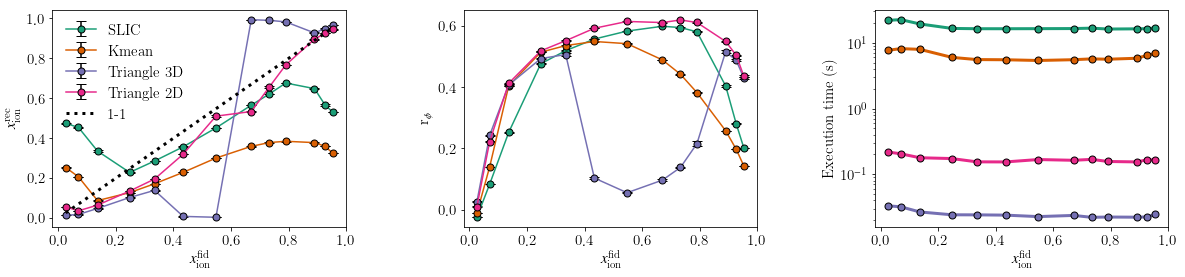

In [48]:
#PLOT THRESHOLDING RESULTS


linewidth = 3.
ms = 7
bmap = brewer2mpl.get_map('Dark2', 'qualitative', 4)
colors = bmap.mpl_colors
fig = plt.figure(figsize=(20,4))
plt.subplots_adjust(hspace=0.4,wspace = 0.4)

ax = plt.subplot(1, 3, 1)

fxhslic = np.median(xhslic, axis = 0)
err_xhslic = scipy.stats.sem(xhslic, axis = 0)
fxhkmean = np.median(xhkmean, axis = 0)
err_xhkmean = scipy.stats.sem(xhkmean, axis = 0)
fxhtriangle3d = np.median(xhtriangle, axis = 0)
err_xhtriangle3d = scipy.stats.sem(xhtriangle, axis = 0)
fxhtriangle2d = np.median(xhtrianglemed, axis = 0)
err_xhtriangle2d = scipy.stats.sem(xhtrianglemed, axis = 0)

ax.errorbar(xhref, fxhslic, yerr=err_xhslic, color=colors[0], ls='-', marker='o', markersize = ms, markeredgecolor = 'black',capsize=5, capthick=1, ecolor='black')
ax.errorbar(xhref, fxhkmean, yerr=err_xhkmean, color=colors[1], ls='-', marker='o',  markersize = ms,markeredgecolor = 'black',capsize=5, capthick=1, ecolor='black')
ax.errorbar(xhref, fxhtriangle3d, yerr=err_xhtriangle3d, color=colors[2], ls='-', marker='o', markersize = ms, markeredgecolor = 'black',capsize=5, capthick=1, ecolor='black')
ax.errorbar(xhref, fxhtriangle2d, yerr=err_xhtriangle2d, color=colors[3], ls='-', marker='o', markersize = ms, markeredgecolor = 'black',capsize=5, capthick=1, ecolor='black')
ax.errorbar(xhref, xhref, linestyle =':',linewidth=3, color = 'k')

ax.set_xlabel(r'$x_{\rm ion}^{\rm fid}$', fontsize=15)
ax.set_ylabel(r'$x_{\rm ion}^{\rm rec}$', fontsize=15)
ax.tick_params(axis = 'both', which = 'both', labelsize = 15)
ax.legend(labels = ['SLIC', 'Kmean', 'Triangle 3D', 'Triangle 2D', '1-1'],  fontsize=15, facecolor="white", frameon=False )


ax = plt.subplot(1, 3, 2)

fcorrslicref = np.median(corrslicref, axis = 0)
err_corrslicref = scipy.stats.sem(corrslicref, axis = 0)
fcorrkmeanref = np.median(corrkmeanref, axis = 0)
err_corrkmeanref = scipy.stats.sem(corrkmeanref, axis = 0)
fcorrtrianglemed3d = np.median(corrtriangleref, axis = 0)
err_corrtrianglemed3d = scipy.stats.sem(corrtriangleref, axis = 0)
fcorrtrianglemedref = np.median(corrtrianglemedref, axis = 0)
err_corrtrianglemedref = scipy.stats.sem(corrtrianglemedref, axis = 0)

ax.errorbar(xhref, fcorrslicref, yerr=err_corrslicref, color=colors[0],  ls='-', marker='o', markersize = ms, markeredgecolor = 'black',capsize=5, capthick=1, ecolor='black')
ax.errorbar(xhref, fcorrkmeanref, yerr=err_corrkmeanref, color=colors[1],  ls='-', marker='o', markersize = ms, markeredgecolor = 'black',capsize=5, capthick=1, ecolor='black')
ax.errorbar(xhref, fcorrtrianglemed3d, yerr=err_corrtrianglemed3d, color=colors[2],  ls='-', marker='o', markersize = ms, markeredgecolor = 'black', capsize=5, capthick=1, ecolor='black')
ax.errorbar(xhref, fcorrtrianglemedref, yerr=err_corrtrianglemedref, color=colors[3],  ls='-', marker='o', markersize = ms, markeredgecolor = 'black', capsize=5, capthick=1, ecolor='black')

# plt.plot(xhref, corrslicref[0], ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
# plt.plot(xhref, corrkmeanref[0], ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
# #plt.plot(xhref, corrtriangleref[0],ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
# plt.plot(xhref, corrtrianglemedref[0],ls ='-',color = colors[3], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)

ax.set_xlabel(r'$x_{\rm ion}^{\rm fid}$', fontsize=15)
ax.set_ylabel(r'r$_\phi$', fontsize=15)
ax.tick_params(axis = 'both', which = 'both', labelsize = 15)

ax = plt.subplot(1, 3 ,3)
ax.tick_params(axis = 'both', which = 'both', labelsize = 15)
ax.set_yscale('log')
plt.plot(xhref, np.mean(timeslic, axis=0), ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markersize = ms, markeredgecolor = 'black')
plt.plot(xhref, np.mean(timekmean, axis=0), ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markersize = ms, markeredgecolor = 'black')
#plt.plot(xhref, timetriangle[0], ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, np.mean(timetriangle, axis=0), ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markersize = ms, markeredgecolor = 'black')
plt.plot(xhref, np.mean(timetrianglemed, axis=0), ls ='-',color = colors[3], linewidth=linewidth,marker = 'o', markersize = ms, markeredgecolor = 'black')

#ax.legend(labels = ['SLIC', 'Kmean', 'Triangle','1-1'],  fontsize=15, frameon=False )

plt.xlabel(r'$x_{\rm ion}^{\rm fid}$', fontsize=15)
plt.ylabel('Execution time (s)', fontsize=15)
plt.show
plt.savefig('Comparison_thresholding_methods_rms2_56_fid.pdf', bbox_inches='tight')


# fig = plt.figure(figsize=(20,7))
# ax = plt.subplot(1, 2, 1)

# fxhsmo = np.median(xhsmo, axis=0)
# mask = (np.median(xhsmo, axis=0)[1:]- np.median(xhsmo, axis=0)[:-1])>-1000
# mask = np.append(mask,True)
# print mask
# mask = [ True , True , True,  False,  True  ,True , True , True  ,True  ,True , True , True, True]
# #fxhsmo[3] = 0.03

# ax.errorbar(fxhsmo[mask], fxhslic[mask], yerr=err_xhslic[mask], color=colors[0], ls='-', marker='o', markersize = 10, markeredgecolor = 'black', capsize=5, capthick=1, ecolor='black')
# ax.errorbar(fxhsmo[mask], fxhkmean[mask], yerr=err_xhkmean[mask], color=colors[1], ls='--', marker='o', markersize = 10, markeredgecolor = 'black', capsize=5, capthick=1, ecolor='black')
# ax.errorbar(fxhsmo[mask], fxhtriangle[mask], yerr=err_xhtriangle[mask], color=colors[2], ls='-', marker='o', markersize = 10, markeredgecolor = 'black', capsize=5, capthick=1, ecolor='black')
# ax.errorbar(fxhsmo[mask], fxhsmo[mask], linestyle =':',linewidth=3, color = 'k')

# ax.set_xlabel(r'x$_{\rm ion}^{\rm smo}$', fontsize=20)
# ax.set_ylabel(r'x$_{\rm ion}$ recovered', fontsize=20)
# ax.tick_params(axis = 'both', which = 'both', labelsize = 24)
# ax.legend(labels = ['SLIC', 'Kmean', 'Triangle','1-1'],  fontsize=15, frameon=False )

# ax = plt.subplot(1, 2, 2)

# fcorrslicsmo = np.median(corrslicsmo, axis = 0)
# err_corrslicsmo = scipy.stats.sem(corrslicsmo, axis = 0)
# fcorrkmeansmo = np.median(corrkmeansmo, axis = 0)
# err_corrkmeansmo = scipy.stats.sem(corrkmeansmo, axis = 0)
# fcorrtrianglemedsmo = np.median(corrtrianglemedsmo, axis = 0)
# err_corrtrianglemedsmo = scipy.stats.sem(corrtrianglemedsmo, axis = 0)

# ax.errorbar(fxhsmo[mask], fcorrslicsmo[mask], yerr=err_corrslicsmo[mask], color=colors[0], ls='-', marker='o', markersize = 10, markeredgecolor = 'black', capsize=5, capthick=1, ecolor='black')
# ax.errorbar(fxhsmo[mask], fcorrkmeansmo[mask], yerr=err_corrkmeansmo[mask], color=colors[1], ls='-', markersize = 10, markeredgecolor = 'black', marker='o', capsize=5, capthick=1, ecolor='black')
# ax.errorbar(fxhsmo[mask], fcorrtrianglemedsmo[mask], yerr=err_corrtrianglemedsmo[mask], color=colors[2], ls='-', markersize = 10, markeredgecolor = 'black', marker='o', capsize=5, capthick=1, ecolor='black')

# plt.xlabel(r'x$_{\rm ion}^{\rm smo}$', fontsize=20)
# plt.ylabel(r'r$_\phi$', fontsize=20)
# plt.tick_params(axis = 'both', which = 'both', labelsize = 24)

#plt.savefig('Comparison_thresholding_methods_rms2_56_smo.pdf', bbox_inches='tight')

# fig = plt.figure(figsize=(9,6))
# ax = plt.subplot(1, 1 ,1)
# ax.tick_params(axis = 'both', which = 'both', labelsize = 20)

# plt.plot(xhref, np.mean(timeslic, axis=0), ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markersize = 10, markeredgecolor = 'black')
# plt.plot(xhref, np.mean(timekmean, axis=0), ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markersize = 10, markeredgecolor = 'black')
# #plt.plot(xhref, timetriangle[0], ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
# plt.plot(xhref, np.mean(timetrianglemed, axis=0), ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markersize = 10, markeredgecolor = 'black')
# ax.legend(labels = ['SLIC', 'Kmean', 'Triangle','1-1'],  fontsize=15, frameon=False )

# plt.xlabel(r'x$_{\rm ion}^{\rm fid}$', fontsize=20)
# plt.ylabel('Execution time (s)', fontsize=20)
# ax = plt.gca()

    #ax.set_xscale('log')
#ax.set_yscale('log')

# zipped = zip(xhref,fxhsmo,fxhslic,fcorrslicref,fcorrslicsmo,  np.mean(timeslic, axis=0))
# np.savetxt('Slic_rms2.56.txt',  zipped, fmt='%f %f %f %f %f %f')

# zipped = zip(xhref,fxhsmo,fxhkmean,fcorrkmeanref,fcorrkmeansmo, np.mean(timekmean, axis=0))
# np.savetxt('Kmean_rms2.56.txt',  zipped, fmt='%f %f %f %f %f %f')

# # zipped = zip(xhref,xhsmo,xhtriangle,corrtriangleref,corrtrianglesmo, timetriangle)
# # np.savetxt('Triangle_rms2.56.txt',  zipped, fmt='%f %f %f %f %f %f')

# zipped = zip(xhref,fxhsmo,fxhtriangle,fcorrtrianglemedref,fcorrtrianglemedsmo, np.mean(timetrianglemed, axis=0))
# np.savetxt('Trianglemed_rms2.56.txt',  zipped, fmt='%f %f %f %f %f %f')

#plt.savefig('Comparison_thresholding_methods_time.pdf', bbox_inches='tight')

In [31]:
print xhref
print xhsmo
print fxhslic


[0.026 0.070 0.136 0.248 0.334 0.434 0.548 0.670 0.733 0.790 0.890 0.927
 0.953]
[[0.578 0.579 0.580 0.578 0.577 0.573 0.579 0.576 0.578 0.578 0.578 0.577
  0.579]
 [0.581 0.576 0.581 0.577 0.577 0.579 0.580 0.581 0.579 0.579 0.579 0.578
  0.584]
 [0.580 0.579 0.582 0.578 0.577 0.581 0.579 0.579 0.578 0.581 0.579 0.578
  0.581]
 [0.577 0.578 0.577 0.576 0.578 0.577 0.580 0.578 0.577 0.580 0.578 0.578
  0.577]
 [0.578 0.579 0.579 0.578 0.576 0.579 0.581 0.580 0.579 0.580 0.579 0.579
  0.580]]
[0.473 0.450 0.335 0.225 0.297 0.370 0.457 0.558 0.610 0.656 0.632 0.569
 0.530]


In [ ]:
#Test thresholding methods 2
import time
from skimage import filters

name = [ 'nf095','nf090','nf080','nf070','nf060','nf050',\
        'nf040', 'nf030', 'nf020','nf015','nf010','nf006','nf004']
namex = [ 'xH095','xH090','xH080','xH070','xH060','xH050',\
         'xH040','xH030','xH020','xH015','xH010','xH006','xH004']

ncells = 128   
boxsize = 256

z = 10.

baselines_test = [1.,1.5,2.,2.5,3.]
#baselines_test = [2.]
#snr = [[] for i in range(len(ntests))]

xhref= np.zeros(len(name))
xhsmo= np.zeros((len(baselines_test),len(name)))
xhslic = np.zeros((len(baselines_test),len(name)))
xhkmean = np.zeros((len(baselines_test),len(name)))
xhtriangle = np.zeros((len(baselines_test),len(name)))
xhtrianglemed = np.zeros((len(baselines_test),len(name)))

corrslicref = np.zeros((len(baselines_test),len(name)))
corrslicsmo = np.zeros((len(baselines_test),len(name)))
corrkmeanref = np.zeros((len(baselines_test),len(name)))
corrkmeansmo = np.zeros((len(baselines_test),len(name)))
corrtriangleref = np.zeros((len(baselines_test),len(name)))
corrtrianglesmo = np.zeros((len(baselines_test),len(name)))
corrtrianglemedref = np.zeros((len(baselines_test),len(name)))
corrtrianglemedsmo = np.zeros((len(baselines_test),len(name)))

timeslic = np.zeros((len(baselines_test),len(name)))
timekmean = np.zeros((len(baselines_test),len(name)))
timetriangle =np.zeros((len(baselines_test),len(name)))
timetrianglemed =np.zeros((len(baselines_test),len(name)))

for i, txt in enumerate(name):
    datax = load_binary_data('Simulations/128_fesc02/%s'%namex[i])
    datax = datax.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    datax.shape = (int(ncells), int(ncells), int(ncells))   
    
    newdata = datax < 0.5
    xhref[i] = np.count_nonzero(newdata)/ float(ncells**3)
    print 'Ref: global fraction: %f'%(xhref[i])

    
    data_dtb = np.zeros((int(ncells), int(ncells), int(ncells)))  
    #data_dtb = load_binary_data('21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/delta_T_1.000000_1.000000_z7.000000_128_256Mpc')
    data_dtb = load_binary_data('Simulations/128_fesc02/%s'%name[i])
    data_dtb = data_dtb.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data_dtb.shape = (int(ncells), int(ncells), int(ncells))   

    uv_map = np.loadtxt('21CMMC/21CMMC_SourceCode/Programs/NoiseData/UVmap_SKA/128/uv_map_z%1.6f.txt'%(z), ndmin=2)
    noise = t2c.noise_cube_coeval(int(ncells), z, obs_time=1000,  boxsize=boxsize,\
                          total_int_time=6., int_time=10., declination=-30., \
                          uv_map=uv_map, N_ant=512, verbose = False, fft_wrap=False)   
    
    for jj in range(len(baselines_test)):
  
        output_dtheta  = (1+z)*21e-5/baselines_test[jj]
        
        output_ang_res = output_dtheta*t2c.cm.z_to_cdist(z) * ncells/float(boxsize)
        kernel = gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
        kernelfft = np.fft.fft2(np.fft.ifftshift(kernel))
        kernelfft[uv_map == 0] = 0

        data_dtb_smo = np.zeros((data_dtb.shape))
        datax_smo = np.zeros((datax.shape))
        for ii in range(int(ncells)):
            data_dtb_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data_dtb[:,:,ii]+noise[:,:,ii]),\
                                                                   kernelfft)))
            datax_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(datax[:,:,ii]),\
                                                                kernelfft)))


        output_met1 = np.zeros(data_dtb_smo.shape)
        output_met2 = np.zeros(datax_smo.shape)

        kernel = t2c.tophat_kernel(int(ncells), output_ang_res)
    
        for ii in range(int(ncells)):
            output_met1[ii,:,:] = t2c.smooth_with_kernel(data_dtb_smo[ii,:,:], kernel)
            output_met2[ii,:,:] = t2c.smooth_with_kernel(datax_smo[ii,:,:], kernel)

        img = output_met1.astype(float)
        img = img - np.mean(img)
    

        
        datax_smo_ref = output_met2.astype(float) 
        newdata1 = datax_smo_ref < 0.5
        xhsmo[jj][i] = np.count_nonzero(newdata1)/ float(ncells**3)
        print 'Smoothed: global fraction: %f'%(xhsmo[jj][i])
        print 'STD: %f'%(np.std(img))


        #++++++++++++++++++++++ SLIC ++++++++++++++++++++++++++
        start_time = time.time()
        labels = t2c.slic_cube(img)
        slic = t2c.stitch_superpixels(img, labels,on_superpixel_map=False)
        timeslic[jj][i] =(time.time() - start_time)

        xhslic[jj][i] =(np.count_nonzero(slic)/ float(ncells**3)) 
        cm = np.corrcoef(newdata.flat, (slic.astype(float)).flat)
        corrslicref[jj][i] =(cm[0][1])
        cm = np.corrcoef(newdata1.flat, (slic.astype(float)).flat)
        corrslicsmo[jj][i] =(cm[0][1])

        print 'SLIC: global fraction: %f, corr coef ref: %f, smo: %f'%(xhslic[jj][i], corrslicref[jj][i],\
                                                                       corrslicsmo[jj][i])
        print("--- %f seconds ---\n\n" % (float(timeslic[jj][i])))


        #++++++++++++++++++++++ KMEAN ++++++++++++++++++++++++++
        start_time = time.time()
        kmea = t2c.threshold_kmeans_3cluster(img, upper_lim=True, n_jobs=5)
        timekmean[jj][i] =(time.time() - start_time)

        xhkmean[jj][i] = (np.count_nonzero(kmea)/ float(ncells**3)) 
        cm = np.corrcoef(newdata.flat, (kmea.astype(float)).flat)
        corrkmeanref[jj][i] =(cm[0][1])
        cm = np.corrcoef(newdata1.flat, (kmea.astype(float)).flat)
        corrkmeansmo[jj][i] =(cm[0][1])
        print 'KMEAN: global fraction: %f, corr coef ref: %f, smo: %f'%(xhkmean[jj][i], corrkmeanref[jj][i], \
                                                                        corrkmeansmo[jj][i])
        print("--- %s seconds ---\n\n" %(float(timekmean[jj][i])))    


        #++++++++++++++++++++++ Triangle ++++++++++++++++++++++++++

#         start_time = time.time()
#         th = skimage.filters.threshold_triangle(img)
#         newdata2 = img < th
#         timetriangle[jj][i] = (time.time() - start_time)

#         xhtriangle[jj][i] =(np.count_nonzero(newdata2)/ float(ncells**3))  
#         cm = np.corrcoef(newdata.flat, newdata2.flat)
#         corrtriangleref[jj][i] =(cm[0][1])
#         cm = np.corrcoef(newdata1.flat, newdata2.flat)
#         corrtrianglesmo[jj][i] =(cm[0][1])
#         print 'TRIANGLE: global fraction: %f, corr coef ref: %f, smo: %f'%(xhtriangle[jj][i],\
#                                                                            corrtriangleref[jj][i], \
#                                                                            corrtrianglesmo[jj][i])
#         print("--- %s seconds ---\n\n" %(float(timetriangle[jj][i])))    


        #++++++++++++++++++++++ Triangle Median ++++++++++++++++++++++++++

        start_time = time.time()
        allth = []
        for ii in range(ncells):
            th = skimage.filters.threshold_triangle(img[:,:,ii])
            allth.append(th)
        newdata2 = img < np.median(allth)

        timetrianglemed[jj][i] =(time.time() - start_time)

        xhtrianglemed[jj][i] =(np.count_nonzero(newdata2)/ float(ncells**3))  
        cm = np.corrcoef(newdata.flat, newdata2.flat)
        corrtrianglemedref[jj][i] =(cm[0][1])
        cm = np.corrcoef(newdata1.flat, newdata2.flat)
        corrtrianglemedsmo[jj][i] =(cm[0][1])
        print 'TRIANGLE Med: global fraction: %f, corr coef ref: %f, smo: %f'%(xhtrianglemed[jj][i],\
                                                                               corrtrianglemedref[jj][i],\
                                                                               corrtrianglemedsmo[jj][i])
        print("--- %s seconds ---\n\n" %(float(timetrianglemed[jj][i])))    


In [ ]:
# Plot thresholding BASELINES PLOT
bmap = brewer2mpl.get_map('Set1', 'qualitative', 5)
colors = bmap.mpl_colors

fig = plt.figure(figsize=(30,15))
ax = plt.subplot(2, 2, 1)

plt.plot(xhref, xhtrianglemed[0], ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, xhtrianglemed[1], ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, xhtrianglemed[2], ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, xhtrianglemed[3], ls ='-',color = colors[3], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, xhtrianglemed[4], ls ='-',color = colors[4], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, xhref, linestyle ='--',linewidth=3.0, color = 'k')

ax.set_xlabel(r'x$_{\rm ion}^{\rm ref}$', fontsize=20)
ax.set_ylabel(r'x$_{\rm ion}$ recovered', fontsize=20)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)

ax.legend(labels = ['B = 1 km','B = 1.5 km',  'B = 2 km', ' B = 2.5 km', ' B = 3 km', '1-1'],  fontsize=20, frameon=False )


ax = plt.subplot(2, 2, 2)
plt.plot(xhref, corrtrianglemedref[0], ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, corrtrianglemedref[1], ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, corrtrianglemedref[2], ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, corrtrianglemedref[3], ls ='-',color = colors[3], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhref, corrtrianglemedref[4], ls ='-',color = colors[4], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)

ax.set_xlabel(r'x$_{\rm ion}^{\rm ref}$', fontsize=20)
ax.set_ylabel(r'r$_\phi$', fontsize=20)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)


ax = plt.subplot(2, 2, 3)


plt.plot(xhsmo[0], xhtrianglemed[0], ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhsmo[1], xhtrianglemed[1], ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhsmo[2], xhtrianglemed[2], ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhsmo[3], xhtrianglemed[3], ls ='-',color = colors[3], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhsmo[4], xhtrianglemed[4], ls ='-',color = colors[4], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)

ax.set_xlabel(r'x$_{\rm ion}^{\rm smo}$', fontsize=20)
ax.set_ylabel(r'x$_{\rm ion}$ recovered', fontsize=20)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)


ax = plt.subplot(2, 2, 4)

plt.plot(xhsmo[0], corrtrianglemedsmo[0], ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhsmo[1], corrtrianglemedsmo[1], ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhsmo[2],corrtrianglemedsmo[2], ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhsmo[3], corrtrianglemedsmo[3], ls ='-',color = colors[3], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)
plt.plot(xhsmo[4], corrtrianglemedsmo[4], ls ='-',color = colors[4], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)

ax.set_xlabel(r'x$_{\rm ion}^{\rm smo}$', fontsize=20)
ax.set_ylabel(r'r$_\phi$', fontsize=20)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)

# ax.legend(labels = ['SLIC', 'Kmean', 'Triangle', ' Triangle_med', '1-1'],  fontsize=20, frameon=False )

# zipped = zip(xhref,xhsmo,xhslic,corrslicref,corrslicsmo, timeslic)
# np.savetxt('Slic_rms1_29.txt',  zipped, fmt='%f %f %f %f %f %f')

# zipped = zip(xhref,xhsmo,xhkmean,corrkmeanref,corrkmeansmo, timekmean)
# np.savetxt('Kmean_rms1_29.txt',  zipped, fmt='%f %f %f %f %f %f')

# zipped = zip(xhref,xhsmo,xhtriangle,corrtriangleref,corrtrianglesmo, timetriangle)
# np.savetxt('Triangle_rms1_29.txt',  zipped, fmt='%f %f %f %f %f %f')

# zipped = zip(xhref,xhsmo,xhtrianglemed,corrtrianglemedref,corrtrianglemedsmo, timeslic)
# np.savetxt('Trianglemec_rms1_29.txt',  zipped, fmt='%f %f %f %f %f %f')

plt.savefig('Comparison_baseline_rms_2_56.pdf', bbox_inches='tight')

In [ ]:
#Test thresholding for attributes


name = ['nf085', 'nf070','nf050','nf030']
namex = [ 'xH085','xH070','nf050','xH030']

ncells = 128   
boxsize = 256

z = 10.

#baselines_test = [1.75,2.,2.5,3.]
baselines_test = [2.]
ntests = 1
#snr = [[] for i in range(len(ntests))]

xhref= np.zeros(len(name))
xhsmo= np.zeros((ntests,len(name)))
xhslic =np.zeros((ntests,len(name)))
xhkmean = np.zeros((ntests,len(name)))
xhtriangle = np.zeros((ntests,len(name)))
xhtrianglemed =np.zeros((ntests,len(name)))

all_count_fid = np.zeros((ntests,len(name), len(vol_bins)-1))
all_elong_fid = np.zeros((ntests,len(name), len(vol_bins)-1))
all_spars_fid = np.zeros((ntests,len(name), len(vol_bins)-1))
all_count_fid_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_elong_fid_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_spars_fid_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_count_smo= np.zeros((ntests,len(name), len(vol_bins)-1))
all_elong_smo = np.zeros((ntests,len(name), len(vol_bins)-1))
all_spars_smo = np.zeros((ntests,len(name), len(vol_bins)-1))
all_count_smo_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_elong_smo_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_spars_smo_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_count_slic = np.zeros((ntests,len(name), len(vol_bins)-1))
all_elong_slic = np.zeros((ntests,len(name), len(vol_bins)-1))
all_spars_slic = np.zeros((ntests,len(name), len(vol_bins)-1))
all_count_slic_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_elong_slic_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_spars_slic_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_count_tri = np.zeros((ntests,len(name), len(vol_bins)-1))
all_elong_tri = np.zeros((ntests,len(name), len(vol_bins)-1))
all_spars_tri = np.zeros((ntests,len(name), len(vol_bins)-1))
all_count_tri_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_elong_tri_err = np.zeros((ntests,len(name), len(vol_bins)-1))
all_spars_tri_err = np.zeros((ntests,len(name), len(vol_bins)-1))

vol_bins = [10,100,1000,10000,100000,float(np.inf)]

for iii, txt in enumerate(name):
    datax = load_binary_data('Simulations/128_fesc02/%s'%namex[iii])
    datax = datax.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    datax.shape = (int(ncells), int(ncells), int(ncells))   
    
    newdata = (datax < 0.5).astype('float')
    xhref[iii] = np.count_nonzero(newdata)/ float(ncells**3)
    
    data_dtb = np.zeros((int(ncells), int(ncells), int(ncells)))  
    #data_dtb = load_binary_data('21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/delta_T_1.000000_1.000000_z7.000000_128_256Mpc')
    data_dtb = load_binary_data('Simulations/128_fesc02/%s'%name[iii])
    data_dtb = data_dtb.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data_dtb.shape = (int(ncells), int(ncells), int(ncells))   
#    print np.count_nonzero(data_dtb)/ float(ncells**3)


    uv_map = np.loadtxt('21CMMC/21CMMC_SourceCode/Programs/NoiseData/UVmap_SKA/128/uv_map_z%1.6f.txt'%(z), ndmin=2)

    for kk in range(ntests):
        noise = t2c.noise_cube_coeval(int(ncells), z, obs_time=1000,  boxsize=boxsize,\
                              total_int_time=6., int_time=10., declination=-30., \
                              uv_map=uv_map, N_ant=512, verbose = False, fft_wrap=False)      
        output_dtheta  = (1+z)*21e-5/2.
        
        output_ang_res = output_dtheta*t2c.cm.z_to_cdist(z) * ncells/float(boxsize)
        kernel = gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
        kernelfft = np.fft.fft2(np.fft.ifftshift(kernel))
        kernelfft[uv_map == 0] = 0
        #uv_map = kernel_fft

        data_dtb_smo = np.zeros((data_dtb.shape))
        datax_smo = np.zeros((datax.shape))
        for ii in range(int(ncells)):
            data_dtb_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data_dtb[:,:,ii]+noise[:,:,ii]),\
                                                                   kernelfft)))
            datax_smo[:,:,ii] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(datax[:,:,ii]),\
                                                                kernelfft)))


        output_met1 = np.zeros(data_dtb_smo.shape)
        output_met2 = np.zeros(datax_smo.shape)

        kernel = t2c.tophat_kernel(int(ncells), output_ang_res)
    
        for ii in range(int(ncells)):
            output_met1[ii,:,:] = t2c.smooth_with_kernel(data_dtb_smo[ii,:,:], kernel)
            output_met2[ii,:,:] = t2c.smooth_with_kernel(datax_smo[ii,:,:], kernel)

        img = output_met1.astype(float)
        img = img - np.mean(img)
    

        
        datax_smo_ref = output_met2.astype(float) 
        newdata1 = datax_smo_ref < 0.5
        xhsmo[kk][iii] = np.count_nonzero(newdata1)/ float(ncells**3)

        
        hdu = fits.PrimaryHDU(newdata.astype('uint8'))
        hdul = fits.HDUList([hdu])
        hdul.writeto('temp_fid%d.fits'%(iii), overwrite='true')
        command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
         --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
         --inprefix temp_fid%d --outprefix temp_fid%d  -v info "%(iii,iii)
        os.system(command)
        
        f = open('temp_fid%d_vol.bin'%(iii), "r")
        volume = np.fromfile(f, dtype=np.uint64)*2
        nbubbles = len(volume)      
        f = open('temp_fid%d_elong.bin'%(iii), "r")
        all_e = np.fromfile(f, dtype=np.float)
        f = open('temp_fid%d_spars.bin'%(iii), "r")
        all_s = np.fromfile(f, dtype=np.float)
        mean_count = []
        mean_elong = []
        mean_spars = []
        mean_count = []
        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_spar = np.array(all_s)[sel_id]

            mean_count.append(sel_n)
            mean_elong.append([np.nanmean(sel_elong), scipy.stats.sem(sel_elong)])
            mean_spars.append([np.nanmean(sel_spar), scipy.stats.sem(sel_spar)])

        all_count_fid[kk][iii] = np.asarray(mean_count)
        all_elong_fid[kk][iii] =(np.asarray(mean_elong))[:,0]
        all_spars_fid[kk][iii] = (np.asarray(mean_spars))[:,0]

        
        hdu = fits.PrimaryHDU(newdata1.astype('uint8'))
        hdul = fits.HDUList([hdu])
        hdul.writeto('temp_smo%d.fits'%(iii), overwrite='true')

        command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
         --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
         --inprefix temp_smo%d --outprefix temp_smo%d  -v info "%(iii,iii)
        os.system(command)

        f = open('temp_smo%d_vol.bin'%(iii), "r")
        volume = np.fromfile(f, dtype=np.uint64)*2
        nbubbles = len(volume)      
        f = open('temp_smo%d_elong.bin'%(iii), "r")
        all_e = np.fromfile(f, dtype=np.float)
        f = open('temp_smo%d_spars.bin'%(iii), "r")
        all_s = np.fromfile(f, dtype=np.float)
        mean_count = []
        mean_elong = []
        mean_spars = []
        mean_count = []


        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_spar = np.array(all_s)[sel_id]

            mean_count.append(sel_n)
            mean_elong.append([np.nanmean(sel_elong), scipy.stats.sem(sel_elong)])
            mean_spars.append([np.nanmean(sel_spar), scipy.stats.sem(sel_spar)])

        all_count_smo[kk][iii] = np.asarray(mean_count)
        all_elong_smo[kk][iii] = np.asarray(mean_elong)[:,0]
        all_spars_smo[kk][iii] = np.asarray(mean_spars)[:,0]
        
        #++++++++++++++++++++++ SLIC ++++++++++++++++++++++++++
        labels = t2c.slic_cube(img)
        slic = t2c.stitch_superpixels(img, labels,on_superpixel_map=False)
        hdu = fits.PrimaryHDU(slic.astype('uint8'))
        hdul = fits.HDUList([hdu])
        
        hdul.writeto('temp_rec_slic%d.fits'%(iii), overwrite='true')
        command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
         --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
         --inprefix temp_rec_slic%d --outprefix temp_rec_slic%d  -v info "%(iii,iii)
        os.system(command)

        f = open('temp_rec_slic%d_vol.bin'%(iii), "r")
        volume = np.fromfile(f, dtype=np.uint64)*2
        nbubbles = len(volume)      
        f = open('temp_rec_slic%d_elong.bin'%(iii), "r")
        all_e = np.fromfile(f, dtype=np.float)
        f = open('temp_rec_slic%d_spars.bin'%(iii), "r")
        all_s = np.fromfile(f, dtype=np.float)
        mean_count = []
        mean_elong = []
        mean_spars = []
        mean_count = []


        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_spar = np.array(all_s)[sel_id]

            mean_count.append(sel_n)
            mean_elong.append([np.nanmean(sel_elong), scipy.stats.sem(sel_elong)])
            mean_spars.append([np.nanmean(sel_spar), scipy.stats.sem(sel_spar)])

        all_count_slic[kk][iii] = np.asarray(mean_count)
        all_elong_slic[kk][iii] = np.asarray(mean_elong)[:,0]
        all_spars_slic[kk][iii] = np.asarray(mean_spars)[:,0]
        
        #++++++++++++++++++++++ KMEAN ++++++++++++++++++++++++++

#         kmea = t2c.threshold_kmeans_3cluster(img, upper_lim=True, n_jobs=5)
#         hdu = fits.PrimaryHDU(kmea.astype('uint8'))
#         hdul = fits.HDUList([hdu])
#         hdul.writeto('temp_rec_kmean%d.fits'%(i), overwrite='true')

#         command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
#          --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
#          --inprefix temp_rec_kmean%d --outprefix temp_rec_kmean%d  -v info "%(i,i)
#         os.system(command)

        #++++++++++++++++++++++ Triangle Median ++++++++++++++++++++++++++

        allth = []
        for ii in range(ncells):
            th = skimage.filters.threshold_triangle(img[:,:,ii])
            allth.append(th)
        newdata2 = img < np.median(allth)
        hdu = fits.PrimaryHDU(newdata2.astype('uint8'))
        hdul = fits.HDUList([hdu])
        hdul.writeto('temp_rec_tri%d.fits'%(iii), overwrite='true')

        command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
         --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
         --inprefix temp_rec_tri%d --outprefix temp_rec_tri%d  -v info "%(iii,iii)
        os.system(command)
        
        f = open('temp_rec_tri%d_vol.bin'%(iii), "r")
        volume = np.fromfile(f, dtype=np.uint64)*2
        nbubbles = len(volume)      
        f = open('temp_rec_tri%d_elong.bin'%(iii), "r")
        all_e = np.fromfile(f, dtype=np.float)
        f = open('temp_rec_tri%d_spars.bin'%(iii), "r")
        all_s = np.fromfile(f, dtype=np.float)
        mean_count = []
        mean_elong = []
        mean_spars = []
        mean_count = []


        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_spar = np.array(all_s)[sel_id]

            mean_count.append(sel_n)
            mean_elong.append([np.nanmean(sel_elong), scipy.stats.sem(sel_elong)])
            mean_spars.append([np.nanmean(sel_spar), scipy.stats.sem(sel_spar)])

        all_count_tri[kk][iii] = np.asarray(mean_count)
        all_elong_tri[kk][iii] = np.asarray(mean_elong)[:,0]
        all_spars_tri[kk][iii] = np.asarray(mean_spars)[:,0]
        

In [ ]:
#Plot Thresholding 2

vol_bins = [10,100,1000,10000,100000,float(np.inf)]
nf = ['Xion = 0.1', 'Xion = 0.2','Xion = 0.4','Xion = 0.6']
inprefix = ['temp_fid', 'temp_smo', 'temp_rec_slic', 'temp_rec_tri']
fig_bsd = plt.figure(figsize=(30,7))
ax_bsd={}

fig_elon = plt.figure(figsize=(30,7))
ax_elon = {}

fig_spar = plt.figure(figsize=(30,7))
ax_spar ={}

plt.subplots_adjust(hspace=0.4,wspace = 0.4)
xlegend = r'Volume (cMpc)$^3$'
labelsize = 15

bmap = brewer2mpl.get_map('Set1', 'qualitative', 5)
colors = bmap.mpl_colors
linewidth = 2.
for ii in range(len(nf)):
#    name = '%s/NeutralFraction_1.000000_1.000000_%1.6f.txt'%(directory, z_arr[ii])
#    nfxh =  np.loadtxt('%s'%(name))
#     indx_err = 0
#     if(nfxh < 0.3):
#         index_err = 2
#     elif nfxh < 0.7:
#         index_err = 1
        
#     noisebins = np.loadtxt('%s%s.txt'%(prenoielon, part[indx_err]), usecols=(0,))
#     noiseelon = np.loadtxt('%s%s.txt'%(prenoielon, part[indx_err]), usecols=(1,))
#     noiseflat = np.loadtxt('%s%s.txt'%(prenoiflat, part[indx_err]), usecols=(1,))
#     noisespar = np.loadtxt('%s%s.txt'%(prenoispar, part[indx_err]), usecols=(1,))
#     noisencom = np.loadtxt('%s%s.txt'%(prenoincom, part[indx_err]), usecols=(1,))
    
    
#     splined_elong = scipy.interpolate.splrep(noisebins,noiseelon,s=0)
#     noise_elong = scipy.interpolate.splev(vol_bins[:-1], splined_elong ,der = 0)

#     print noise_elong
#     splined_flat = scipy.interpolate.splrep(noisebins,noiseflat,s=0)
#     noise_flat = scipy.interpolate.splev(vol_bins[:-1], splined_flat ,der = 0)
    
#     splined_spars = scipy.interpolate.splrep(noisebins,noisespar,s=0)
#     noise_spars = scipy.interpolate.splev(vol_bins[:-1], splined_spars ,der = 0)
    
#     splined_ncomp = scipy.interpolate.splrep(noisebins,noisencom,s=0)
#     noise_ncomp = scipy.interpolate.splev(vol_bins[:-1], splined_ncomp ,der = 0)
    ax_bsd[ii] = fig_bsd.add_subplot(1,4,1+ii)
    ax_bsd[ii].set_xscale('log')
    ax_bsd[ii].set_yscale('log')

    ax_elon[ii] = fig_elon.add_subplot(1,4,1+ii)
    ax_elon[ii].set_xscale('log')
    
    ax_spar[ii] = fig_spar.add_subplot(1,4,1+ii)
    ax_spar[ii].set_xscale('log')
    
  #  for kk in range(len(inprefix)):    


    X = np.asarray(vol_bins[:-1])    
    fcfid =  np.nan_to_num(np.nanmedian(all_count_fid, axis=0))
    fcsmo = np.nan_to_num(np.nanmedian(all_count_smo, axis=0))
    fcslic =  np.nan_to_num(np.nanmedian(all_count_slic, axis=0))
    fctri = np.nan_to_num(np.nanmedian(all_count_tri, axis=0))
    fcfid_err =  np.nanstd(all_count_fid, axis = 0)
    fcsmo_err =  np.nanstd(all_count_smo, axis = 0)
    fctri_err =  np.nanstd(all_count_tri, axis = 0)
    fcslic_err =  np.nanstd(all_count_slic, axis = 0)
    
    ax_bsd[ii].errorbar(X+X,fcfid[ii], yerr = fcfid_err[ii], ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    ax_bsd[ii].errorbar(X+0.1*X, fcsmo[ii],yerr = fcsmo_err[ii],ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    ax_bsd[ii].errorbar(X+X*0.2,fcslic[ii],yerr = fcslic_err[ii],ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    ax_bsd[ii].errorbar(X+X*0.3, fctri[ii],yerr = fctri_err[ii],ls ='-',color = colors[3], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10, capsize = 10)  

    
    ax_bsd[ii].set_xlabel(xlegend, fontsize=labelsize)
    ax_bsd[ii].set_ylabel(r'Count', fontsize=labelsize)
    ax_bsd[ii].set_title('Bubbles size distribution %s'%(nf[ii]), fontsize=labelsize)
    ax_bsd[ii].tick_params(axis = 'both', which = 'major', labelsize = 24)
    ax_bsd[ii].legend(labels = ['Fid', 'Smoothed', 'SLIC', 'Triangle'], \
                      loc = 'upper right', fontsize=15, frameon=False )


    
    fcfid =  np.nanmedian(all_elong_fid,axis=0)[ii]
    fcsmo = np.nanmedian(all_elong_smo,axis=0)[ii]
    fcslic = np.nanmedian(all_elong_slic,axis=0)[ii]
    fctri = np.nanmedian(all_elong_tri,axis=0)[ii]
    fcfid_err = np.nanstd(all_elong_fid, axis = 0)[ii]
    fcsmo_err =  np.nanstd(all_elong_smo, axis = 0)[ii]
    fctri_err =  np.nanstd(all_elong_tri, axis = 0)[ii]
    fcslic_err =  np.nanstd(all_elong_slic, axis = 0)[ii]

    
    mask = np.isfinite(fcfid)
    newX = X[mask]

    ax_elon[ii].errorbar(newX,fcfid[mask],  ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    
    mask = np.isfinite(fcsmo)
    newX = X[mask]
    
    ax_elon[ii].errorbar(newX+0.1*newX, fcsmo[mask], ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    
    mask = np.isfinite(fcslic)
    newX = X[mask]
    
    ax_elon[ii].errorbar(newX+newX*0.2, fcslic[mask],yerr = fcslic_err[mask],ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    
    mask = np.isfinite(fctri)
    newX = X[mask]
    
    ax_elon[ii].errorbar(newX+newX*0.3, fctri[mask],yerr = fctri_err[mask],ls ='-',color = colors[3], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10, capsize = 10)  

    ax_elon[ii].set_xlabel(xlegend, fontsize=labelsize)
    ax_elon[ii].set_title('Elongation %s'%(nf[ii]), fontsize=labelsize)
#         ax_elon[ii].fill_between(X, mean_elong[:,0][mask]\
#                                  + np.sqrt(noise_elong[mask]+np.nan_to_num(mean_elong[:,1])[mask]**2),\
#                        mean_elong[:,0][mask], alpha=0.2, facecolor=color[kk], interpolate=True)
#         ax_elon[ii].fill_between(X, mean_elong[:,0][mask] \
#                                  - np.sqrt(noise_elong[mask]+np.nan_to_num(mean_elong[:,1])[mask]**2),\
#                      mean_elong[:,0][mask], alpha=0.2,facecolor=color[kk], interpolate=True)


    fcfid =  np.nanmedian(all_spars_fid,axis=0)[ii]
    fcsmo = np.nanmedian(all_spars_smo,axis=0)[ii]
    fcslic = np.nanmedian(all_spars_slic,axis=0)[ii]
    fctri = np.nanmedian(all_spars_tri,axis=0)[ii]
    fcfid_err = np.nanstd(all_spars_fid, axis = 0)[ii]
    fcsmo_err = np.nanstd(all_spars_smo, axis = 0)[ii]
    fctri_err =np.nanstd(all_spars_tri, axis = 0)[ii]
    fcslic_err = np.nanstd(all_spars_slic, axis = 0)[ii]


    mask = np.isfinite(fcfid)
    newX = X[mask]

    ax_spar[ii].errorbar(newX,fcfid[mask],  ls ='-',color = colors[0], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    
    mask = np.isfinite(fcsmo)
    newX = X[mask]
    
    ax_spar[ii].errorbar(newX+0.1*newX, fcsmo[mask], ls ='-',color = colors[1], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    
    mask = np.isfinite(fcslic)
    newX = X[mask]
    
    ax_spar[ii].errorbar(newX+newX*0.2, fcslic[mask],yerr = fcslic_err[mask],ls ='-',color = colors[2], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    
    mask = np.isfinite(fctri)
    newX = X[mask]
    
    ax_spar[ii].errorbar(newX+newX*0.3, fctri[mask],yerr = fctri_err[mask],ls ='-',color = colors[3], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10, capsize = 10)  
  
    ax_spar[ii].set_xlabel(xlegend, fontsize=labelsize)
    ax_spar[ii].set_title('Sparseness %s'%(nf[ii]), fontsize=labelsize)
#         ax_spar[ii].fill_between(X, mean_spars[:,0][mask]\
#                                  + np.sqrt(noise_spars[mask]+np.nan_to_num(mean_spars[:,1])[mask]**2),\
#                        mean_spars[:,0][mask], alpha=0.2, facecolor=color[kk], interpolate=True)
#         ax_spar[ii].fill_between(X, mean_spars[:,0][mask] \
#                                  - np.sqrt(noise_spars[mask]+np.nan_to_num(mean_spars[:,1])[mask]**2),\
#                      mean_spars[:,0][mask], alpha=0.2,facecolor=color[kk], interpolate=True)


plt.show()
    # plt.savefig('mockobs_hii.pdf', bbox_inches='tight')

+++++++++++++++++++

# Compute attributes


+++++++++++++++++++++++

250


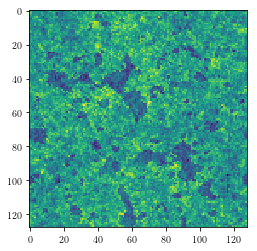

In [19]:
# Create Mock tomographic observations / Run disccoman 

z_arr = [9]

ncells = 128
boxsize = 250


Directory = '21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_gauss2/' #'Simulations/128_250_U2/30_8_47/'
#'21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_new/'#
#for j in range(18,50):
for ii in range(len(z_arr)):
    z = z_arr[ii]
   # print z
   # name = '%s/MockObs/3params_128/NeutralFraction_1.000000_1.000000_%1.6f.txt'%( Directory, z_arr[ii])
   # nfxh =  np.loadtxt('%s'%(name))

#     name = '%s/delta_T_1.000000_1.000000_z%1.6f_128_250Mpc'%( Directory, z_arr[ii])
#     data = load_binary_data(name)
#     data = data.reshape((int(ncells), int(ncells), int(ncells)), order='C')
#     data.shape = (int(ncells), int(ncells), int(ncells))
        
#     data_th = data < 1.
    
        
#     hdu = fits.PrimaryHDU(data_th.astype('uint8'))
#     hdul = fits.HDUList([hdu])
#     hdul.writeto('%s/ref_z%1.6f.fits'%(Directory,z), overwrite='true')
    data =  fits.open('21CMMC/21CMMC_Voronoi/Programs/MockObs/mock_gauss2/obs_z%d.fits'%z)[0].data
    plt.imshow(data[:,:,0])
    
    data2 = data.copy()
    
    uv_map = np.loadtxt('21CMMC/21CMMC_Voronoi/Programs/NoiseData/UVmap_SKA/128/uv_map_z%1.6f.txt'%(z), ndmin=2)

    noise = t2c.noise_cube_coeval(ncells, z, obs_time=1000, boxsize=250, total_int_time=6.,\
                                      int_time=10., declination=-30., uv_map=uv_map, N_ant=512, \
                                      verbose=False, fft_wrap=False)

    max_baseline = 2.
    output_dtheta  = (1+float(z))*21e-5/max_baseline
    output_ang_res = output_dtheta*t2c.cm.z_to_cdist(float(z)) \
                     * ncells/(float(boxsize))


    kernel = t2c.gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
    kernelfft = np.fft.fft2(np.fft.ifftshift(kernel))
    kernelfft[uv_map == 0] = 0
    uv_map = kernelfft

    data_dtb_smo = np.zeros((data.shape))


    for i in range(ncells):                                                 
        data_dtb_smo[:,:,i] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data[:,:,i]+noise[:,:,i]), \
                                                               uv_map/np.max(uv_map))))    


    output_met1 = data_dtb_smo#np.zeros(data.shape)


    kernel = t2c.tophat_kernel(ncells, output_ang_res)
    #kernel = t2c.gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
    for i in range(ncells):
         output_met1[i,:,:] =t2c.smooth_with_kernel(data_dtb_smo[i,:,:], kernel)


    img = output_met1.astype(float)

    hdu = fits.PrimaryHDU(img.astype('float'))
    hdul = fits.HDUList([hdu])
    hdul.writeto('%s/21cmobsgauss_z%1.6f.fits'%(Directory,z), overwrite='true')

    allth=[]
    for i in range(ncells):
        th = skimage.filters.threshold_triangle(img[:,:,i])
        allth.append(th)

    newdata2 = img < np.median(allth)


    curnf = 1. - np.count_nonzero(newdata2.astype(float)) / float(ncells**3)
   # nfdtb = 1. - np.count_nonzero(data_th.astype(float)) / float(ncells**3)
    

#     hdu = fits.PrimaryHDU(newdata2.astype('uint8'))
#     hdul = fits.HDUList([hdu])
#     hdul.writeto('%s/obs_z%1.6f.fits'%(Directory,z), overwrite='true')

#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 0 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hi   \
#      --inprefix %s/ref_z%1.6f --outprefix %s/ref_hi_z%1.6f \
#      -v info "%(Directory,z,Directory,z)
#     os.system(command)
        
#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 4 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
#      --inprefix %s/obs_z%1.6f --outprefix %s/obs_hii_z%1.6f \
#      -v info "%(Directory,z_arr[ii],Directory,z_arr[ii])
#     os.system(command)  
#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 0 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hi   \
#      --inprefix %s/obs_z%1.6f --outprefix %s/obs_hi_z%1.6f \
#      -v info "%(Directory,z_arr[ii],Directory,z_arr[ii])


In [133]:
# Covariance matrix attributes
%precision %.2f
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

D = np.asarray([np.array(np.log10(volume)),np.array(all_e),np.array(all_f),\
    np.array(all_s),np.array(all_n)])



from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(np.transpose(D))
print pca.components_ 
print pca.explained_variance_
print(pca.singular_values_) 
print pca.get_covariance()
print np.linalg.inv( pca.get_covariance())

# import corner
# # xlan = [r'$\epsilon_0$', 'Log10(Tvir)']
# # ylan = ['Log10(Tvir)','Rmfp (MpC)']
# names = [r'Log(Volume)', 'Elong','Flat', 'Spars', 'Comptact']
# # value1 = np.array([30.,4.7,15])
# # paramRanges = ((10,100),
# #                (4,6),
# #                (5,25))
# # D = np.asarray(zip(All_fstar, All_fesc, All_alphastar))
# # value2 = np.median(D, axis=0)
# #D2 = np.loadtxt('chains_3z.txt')

# released = {
#     "markersize" : (5),
#     "marker" : 'o',
#     "alpha": 1,
#     "color" : 'k',
#    # "colors" : ('b','r')
#     }
# fig = corner.corner(np.transpose(D), plot_contours = False, no_fill_contours=True, data_kwargs=released,\
#                     bins=50,range=[(1,4),(0.5,11),(0.5,8),(0.5,7),(0,2)], labels = names)

# D = np.asarray([np.array(np.log10(volume)),np.sqrt((all_f**2-1)/(all_f**2-1/all_e**2)),np.array(all_s)])
# #print np.sqrt((all_f**2-1)/(all_f**2-1/all_e**2))
# print np.cov(D)
# import corner
# # xlan = [r'$\epsilon_0$', 'Log10(Tvir)']
# # ylan = ['Log10(Tvir)','Rmfp (MpC)']
# names = [r'Log(Volume)', 'Ecc', 'Spars']
# # value1 = np.array([30.,4.7,15])
# # paramRanges = ((10,100),
# #                (4,6),
# #                (5,25))
# # D = np.asarray(zip(All_fstar, All_fesc, All_alphastar))
# # value2 = np.median(D, axis=0)
# #D2 = np.loadtxt('chains_3z.txt')

# released = {
#     "markersize" : (5),
#     "marker" : 'o',
#     "alpha": 1,
#     "color" : 'k',
#    # "colors" : ('b','r')
#     }
# fig = corner.corner(np.transpose(D), plot_contours = False, no_fill_contours=True, data_kwargs=released,\
#                     bins=50,range=[(1,4),(0,1.1),(0.5,7)], labels = names)



NameError: name 'volume' is not defined

In [ ]:
#Attributes versus volume mock observation

z_arr = [10]
ncells =128
boxsize = 256
mylegend1 = []
linestyle = [u'-', u'--']

bmap = brewer2mpl.get_map('Set1', 'qualitative', max([len(z_arr),3]))
colors = bmap.mpl_colors

fig_bsd = plt.figure(figsize=(30,7))
ax_bsd={}

fig_elon = plt.figure(figsize=(30,7))
ax_elon = {}

fig_flat = plt.figure(figsize=(30,7))
ax_flat = {}

fig_spar = plt.figure(figsize=(30,7))
ax_spar ={}

fig_ncom = plt.figure(figsize=(30,7))
ax_ncom ={}


labelsize = 30
plt.subplots_adjust(hspace=0.4,wspace = 0.4)


xlegend = r'Volume (cMpc)$^3$'

#part = ['p1', 'p2', 'p3']
objects = 'hii'
prenoielon= '21CMMC/21CMMC_SourceCode/Programs/NoiseData/Morph_SKA_128/bin_ind_hii/Error_%s_elong_univ_z'%objects
prenoiflat = '21CMMC/21CMMC_SourceCode/Programs/NoiseData/Morph_SKA_128/bin_ind_hii/Error_%s_flat_univ_z'%objects
prenoispar = '21CMMC/21CMMC_SourceCode/Programs/NoiseData/Morph_SKA_128/bin_ind_hii/Error_%s_spars_univ_z'%objects
prenoincom = '21CMMC/21CMMC_SourceCode/Programs/NoiseData/Morph_SKA_128/bin_ind_hii/Error_%s_ncomp_univ_z'%objects

# prenoielonnoi= '21CMMC/21CMMC_SourceCode/Programs/NoiseData/Morph_SKA_128/bin_ind_hi/Error_%s_elong_noise_z'%objects
# prenoiflatnoi = '21CMMC/21CMMC_SourceCode/Programs/NoiseData/Morph_SKA_128/bin_ind_hi/Error_%s_flat_noise_z'%objects
# prenoisparnoi = '21CMMC/21CMMC_SourceCode/Programs/NoiseData/Morph_SKA_128/bin_ind_hi/Error_%s_spars_noise_z'%objects
# prenoincomnoi = '21CMMC/21CMMC_SourceCode/Programs/NoiseData/Morph_SKA_128/bin_ind_hi/Error_%s_ncomp_noise_z'%objects

directory = '21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/'
inprefix = ['ref_%s_z'%objects,'obs_%s_z'%objects]
#prefixsave = 'Comp_mock_ref_%s'%objects

nfiles = len(inprefix)*len(z_arr)

vol_bins = [10,100,1000,10000,100000,1000000,float(np.inf)]


for ii in range(len(z_arr)):
        
    noisebins = np.loadtxt('%s%1.6f.txt'%(prenoielon, z_arr[ii]), usecols=(0,))
    noiseelon = np.loadtxt('%s%1.6f.txt'%(prenoielon, z_arr[ii]), usecols=(1,))
    noiseflat = np.loadtxt('%s%1.6f.txt'%(prenoiflat, z_arr[ii]), usecols=(1,))
    noisespar = np.loadtxt('%s%1.6f.txt'%(prenoispar, z_arr[ii]), usecols=(1,))
    noisencom = np.loadtxt('%s%1.6f.txt'%(prenoincom, z_arr[ii]), usecols=(1,))
    noisebins=  np.pad(noisebins, (0, 1),  'linear_ramp',end_values=1e7)
    noiseelon = np.pad(noiseelon, (0, 1),  'constant')
    noiseflat = np.pad(noiseflat, (0, 1),  'constant')
    noisespar = np.pad(noisespar, (0, 1),  'constant')
    noisencom = np.pad(noisencom, (0, 1),  'constant')

    splined_elong = scipy.interpolate.splrep(np.log10(noisebins),noiseelon,s=0, k = 1)
    noise_elong = scipy.interpolate.splev(np.log10(vol_bins[:-1]), splined_elong ,der = 0)
    print noisebins, noiseelon, noise_elong
    splined_flat = scipy.interpolate.splrep(np.log10(noisebins),noiseflat,s=0, k = 1)
    noise_flat = scipy.interpolate.splev(np.log10(vol_bins[:-1]), splined_flat ,der = 0)
    
    splined_spars = scipy.interpolate.splrep(np.log10(noisebins),noisespar,s=0, k = 1)
    noise_spars = scipy.interpolate.splev(np.log10(vol_bins[:-1]), splined_spars ,der = 0)

    splined_ncomp = scipy.interpolate.splrep(np.log10(noisebins),noisencom,s=0, k = 1)
    noise_ncomp = scipy.interpolate.splev(np.log10(vol_bins[:-1]), splined_ncomp ,der = 0)
    
#     noisebinsnoi = np.loadtxt('%s%1.6f.txt'%(prenoielonnoi, z_arr[ii]), usecols=(0,))
#     noiseelonnoi = np.loadtxt('%s%1.6f.txt'%(prenoielonnoi, z_arr[ii]), usecols=(1,))
#     noiseflatnoi = np.loadtxt('%s%1.6f.txt'%(prenoiflatnoi, z_arr[ii]), usecols=(1,))
#     noisesparnoi = np.loadtxt('%s%1.6f.txt'%(prenoisparnoi, z_arr[ii]), usecols=(1,))
#     noisencomnoi = np.loadtxt('%s%1.6f.txt'%(prenoincomnoi, z_arr[ii]), usecols=(1,))
    

#     splined_elongnoi = scipy.interpolate.splrep(noisebinsnoi,noiseelonnoi,s=0, k = 1)
#     noise_elongnoi = scipy.interpolate.splev(vol_bins[:-1], splined_elongnoi ,der = 0)

#     splined_flatnoi = scipy.interpolate.splrep(noisebinsnoi,noiseflatnoi,s=0, k = 1)
#     noise_flatnoi = scipy.interpolate.splev(vol_bins[:-1], splined_flatnoi ,der = 0)
    
#     splined_sparsnoi = scipy.interpolate.splrep(noisebinsnoi,noisesparnoi,s=0, k = 1)
#     noise_sparsnoi = scipy.interpolate.splev(vol_bins[:-1], splined_sparsnoi ,der = 0)

    
#     splined_ncompnoi = scipy.interpolate.splrep(noisebinsnoi,noisencomnoi,s=0, k = 1)
#     noise_ncompnoi = scipy.interpolate.splev(vol_bins[:-1], splined_ncompnoi ,der = 0)
    
    ax_bsd[ii] = fig_bsd.add_subplot(1,len(z_arr),1+ii)
    ax_bsd[ii].set_xscale('log')
    ax_bsd[ii].set_yscale('log')

    ax_elon[ii] = fig_elon.add_subplot(1,len(z_arr),1+ii)
    ax_elon[ii].set_xscale('log')
    
    ax_spar[ii] = fig_spar.add_subplot(1,len(z_arr),1+ii)
    ax_spar[ii].set_xscale('log')
    
    ax_flat[ii] = fig_flat.add_subplot(1,len(z_arr),1+ii)
    ax_flat[ii].set_xscale('log')
    
    ax_ncom[ii] = fig_ncom.add_subplot(1,len(z_arr),1+ii)
    ax_ncom[ii].set_xscale('log')
    
    
    for kk in range(len(inprefix)):    
        name = '%s/stats/%s%1.6f'%(directory,inprefix[kk],z_arr[ii])
        f = open(name+'_vol.bin', "r")
        volume = np.fromfile(f, dtype=np.uint64)*(boxsize/ncells)

        
        nbubbles = len(volume)
        f = open(name+'_elong.bin', "r")
        all_e = np.fromfile(f, dtype=np.float)

        f = open(name+'_flat.bin', "r")
        all_f = np.fromfile(f, dtype=np.float)

        f = open(name+'_spars.bin', "r")
        all_s = np.fromfile(f, dtype=np.float)
        #print volume
        f = open(name+'_ncomp.bin', "r")
        all_n = np.fromfile(f, dtype=np.float)

        mean_vol = []
        mean_count = []
        mean_elong = []
        mean_flat = []
        mean_ncomp = []
        mean_spars = []
        mean_count = []

        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]# 
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_flat = np.array(all_f)[sel_id]
            sel_ncomp = np.array(all_n)[sel_id]
            sel_spar = np.array(all_s)[sel_id]

            mean_vol.append((float)(np.sum(sel_vol)))
            mean_count.append(sel_n)
            mean_elong.append([np.nanmean(sel_elong), scipy.stats.sem(sel_elong)])
            mean_flat.append([np.nanmean(sel_flat), scipy.stats.sem(sel_flat)])
            mean_ncomp.append([np.nanmean(sel_ncomp), scipy.stats.sem(sel_ncomp)])
            mean_spars.append([np.nanmean(sel_spar), scipy.stats.sem(sel_spar)])

        mean_vol = np.asarray(mean_vol)
        mean_count = np.asarray(mean_count)
        mean_elong = np.asarray(mean_elong)
        mean_flat = np.asarray(mean_flat)
        mean_ncomp = np.asarray(mean_ncomp)
        mean_spars = np.asarray(mean_spars)
        X = np.asarray(vol_bins[:-1])    

 #       print np.nanmedian(all_elong_fid[ii], axis = 0)
 #       print mean_elong[:,0]

 #       print np.nanmedian(all_count_fid[ii], axis = 0)
 #       print mean_count


        ax_bsd[ii].plot(X, np.nan_to_num(mean_count.astype(float)), marker ="x", markersize=12, \
                    linewidth=3.0,color = colors[kk], linestyle = linestyle[kk])  
        ax_bsd[ii].set_xlabel(xlegend, fontsize=labelsize)
        ax_bsd[ii].set_ylabel(r'BSD', fontsize=labelsize)
        ax_bsd[ii].set_title('z = %f'%z_arr[ii], fontsize=labelsize)
        ax_bsd[ii].legend(labels = ['True', 'Recovered'], loc = 'upper right', fontsize=20, frameon=False )
        ax_bsd[ii].tick_params(axis = 'both', which = 'both', labelsize = 24)



        mask = np.isfinite(mean_elong[:,0])
        newX = X[mask]
      #  err_elon = np.sqrt(noise_elong[mask]**2 + noise_elongnoi[mask]**2)#np.nan_to_num((mean_elong[:,1][mask]))**2)
        err_elon = np.sqrt(noise_elong[mask]**2 +np.nan_to_num((mean_elong[:,1][mask]))**2)

        zipped = zip(newX,err_elon)
        np.savetxt('Total_elon_error_z%1.6f.txt'%(z_arr[ii]),  zipped, fmt='%d %f')
        
        ax_elon[ii].errorbar(newX,mean_elong[:,0][mask], yerr=err_elon, capsize = 10,ls ='-',color = colors[ii],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10, linestyle = linestyle[kk])  
        ax_elon[ii].tick_params(axis = 'both', which = 'both', labelsize = 24)
        ax_elon[ii].set_xlabel(xlegend, fontsize=labelsize)
        ax_elon[ii].set_ylabel(r'Elongation', fontsize=labelsize)

#        ax_elon[ii].set_title('z = %f'%z_arr[ii], fontsize=labelsize)
        
        mask = np.isfinite(mean_flat[:,0])
        newX = X[mask]
        #err_flat = np.sqrt(noise_flat[mask]**2 +noise_flatnoi[mask]**2)# np.nan_to_num(mean_flat[:,1][mask])**2)
        
        err_flat = np.sqrt(noise_flat[mask]**2 + np.nan_to_num((mean_flat[:,1][mask]))**2)
        zipped = zip(newX,err_flat)
        np.savetxt('Total_flat_error_z%1.6f.txt'%(z_arr[ii]),  zipped, fmt='%d %f')
        ax_flat[ii].errorbar(newX,mean_flat[:,0][mask], yerr=err_flat, capsize = 10,ls ='-',color = colors[ii],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10, linestyle = linestyle[kk])  
        ax_flat[ii].tick_params(axis = 'both', which = 'both', labelsize = 24)
        ax_flat[ii].set_xlabel(xlegend, fontsize=labelsize)
        ax_flat[ii].set_ylabel(r'Flatness', fontsize=labelsize)
#        ax_flat[ii].set_title('z = %f'%z_arr[ii], fontsize=labelsize)

        mask = np.isfinite(mean_spars[:,0])
        newX = X[mask]
        err_spar = np.sqrt(noise_spars[mask]**2 +np.nan_to_num(mean_spars[:,1][mask])**2)
#       print err_spar
        zipped = zip(newX,err_spar)
        np.savetxt('Total_spar_error_z%1.6f.txt'%(z_arr[ii]),  zipped, fmt='%d %f')
        ax_spar[ii].errorbar(newX,mean_spars[:,0][mask], yerr=err_spar, capsize = 10,ls ='-',color = colors[ii],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10, linestyle = linestyle[kk])  
        ax_spar[ii].tick_params(axis = 'both', which = 'both', labelsize = 24)
        ax_spar[ii].set_xlabel(xlegend, fontsize=labelsize)
        ax_spar[ii].set_ylabel(r'Sparseness', fontsize=labelsize)
        #ax_bsd[ii].set_title('Bubbles size distribution', fontsize=labelsize)
        
        mask = np.isfinite(mean_ncomp[:,0])
        newX = X[mask]
        
        err_ncom = np.sqrt(noise_ncomp[mask]**2 +np.nan_to_num(mean_ncomp[:,1][mask])**2)
        zipped = zip(newX,err_ncom)
        np.savetxt('Total_ncom_error_z%1.6f.txt'%(z_arr[ii]),  zipped, fmt='%d %f')
  
        ax_ncom[ii].errorbar(newX,mean_ncomp[:,0][mask], yerr=err_ncom, capsize = 10,ls ='-',color = colors[ii],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10, linestyle = linestyle[kk])  
        ax_ncom[ii].tick_params(axis = 'both', which = 'both', labelsize = 24)
        ax_ncom[ii].set_xlabel(xlegend, fontsize=labelsize)
        ax_ncom[ii].set_ylabel(r'Ncompactness', fontsize=labelsize)
        #ax_ncom[ii].set_title('Bubbles size distribution', fontsize=labelsize)


plt.show()
# fig_bsd.savefig('mockobs_hii_bsd.pdf', bbox_inches='tight')
# fig_elon.savefig('mockobs_hii_elon.pdf', bbox_inches='tight')
# fig_flat.savefig('mockobs_hii_flat.pdf', bbox_inches='tight')
# fig_spar.savefig('mockobs_hii_spar.pdf', bbox_inches='tight')
# fig_ncom.savefig('mockobs_hii_ncom.pdf', bbox_inches='tight')

In [10]:
# Create Mock tomographic observations / Run disccoman / 512 MPC

#z_arr = [13,11.6,10.4,9.7,9.22,8.8,8.53,8.28,7.85,7.62,7.45,7.29,7.15,6.95,6.8,6.6,6.45,6.25,6.0]

#z_arr = [11,10,9.3,8.9,8.6,8.35,8.20,7.95,7.8,7.67,7.50,7.35,7.1,6.92,6.8,6.67,6.5,6.3,6.05]
z_arr= [10]
ncells = 512
boxsize = 1024


Directory = 'Simulations/Paper/Mock_512_e30/'
nfxh = []
#for j in range(18,50):
for ii in range(len(z_arr)):
    z = z_arr[ii]
    print z
   # name = '%/NeutralFraction_1.000000_1.000000_%1.6f.txt'%( Directory, z_arr[ii])
   # nfxh.append(np.loadtxt('%s'%(name)))
    
    name = '%s/delta_T_1.000000_1.000000_z%1.6f_%d_%dMpc'%( Directory, z_arr[ii], ncells, boxsize)
    data = load_binary_data(name)
    data = data.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data.shape = (int(ncells), int(ncells), int(ncells))
        
    data_th = data < 1.
    
        
#     hdu = fits.PrimaryHDU(data_th.astype('uint8'))
#     hdul = fits.HDUList([hdu])
#     hdul.writeto('%s/ref_z%1.6f.fits'%(Directory, z), overwrite='true')
    
    
#     data2 = data.copy()
    
    uv_map = np.loadtxt('uv_map_512_z10.000000.txt', ndmin=2)

    noise = t2c.noise_cube_coeval(ncells, z, obs_time=1000, boxsize=boxsize, total_int_time=6.,\
                                     int_time=10., declination=-30., uv_map=uv_map, N_ant=512, \
                                     verbose=False, fft_wrap=False)

    max_baseline = 2.
    output_dtheta  = (1+float(z))*21e-5/max_baseline
    output_ang_res = output_dtheta*t2c.cm.z_to_cdist(float(z)) \
                     * ncells/(float(boxsize))


    kernel = t2c.gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
    kernelfft = np.fft.fft2(np.fft.ifftshift(kernel))
    kernelfft[uv_map == 0] = 0
    uv_map = kernelfft

    data_dtb_smo = np.zeros((data.shape))


    for i in range(ncells):                                                 
        data_dtb_smo[:,:,i] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data[:,:,i]+noise[:,:,i]), \
                                                               uv_map/np.max(uv_map))))   
        
#     hdu = fits.PrimaryHDU(data+noise)
#     hdul = fits.HDUList([hdu])
#     hdul.writeto('%s/z%1.6f_noise.fits'%(Directory, z), overwrite='true')

    output_met1 = data_dtb_smo#np.zeros(data.shape)


    kernel = t2c.tophat_kernel(ncells, output_ang_res)
    #kernel = t2c.gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
    for i in range(ncells):
         output_met1[i,:,:] =t2c.smooth_with_kernel(data_dtb_smo[i,:,:], kernel)


    img = output_met1.astype(float)

    allth=[]
    for i in range(ncells):
        th = skimage.filters.threshold_triangle(img[:,:,i])
        allth.append(th)

    newdata2 = img < np.median(allth)


    curnf = 1. - np.count_nonzero(newdata2.astype(float)) / float(ncells**3)
    nfdtb = 1. - np.count_nonzero(data_th.astype(float)) / float(ncells**3)
    

    hdu = fits.PrimaryHDU(newdata2.astype('uint8'))
    hdul = fits.HDUList([hdu])
    hdul.writeto('%s/obs_z%1.6f.fits'%(Directory,z),overwrite='true')

#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 0 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
#      --inprefix %s/ref_z%1.6f --outprefix %s/ref_hii_z%1.6f \
#      -v info "%(Directory,z,Directory,z)
#     os.system(command)
        
#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 0 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hi   \
#      --inprefix %s/ref_z%1.6f --outprefix %s/stats/ref_hi_z%1.6f \
#      -v info "%(Directory,z,Directory, z)
#     os.system(command)
    
    command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 4 --intype fits \
     --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
     --inprefix %s/obs_z%1.6f --outprefix %s/obs_hii_z%1.6f \
     -v info "%(Directory,z_arr[ii],Directory,z_arr[ii])
    os.system(command)     

10


/home/Simon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


1024


In [ ]:
# Attributes versus volume mock observation, compare two sets
xlegend = r'Volume (Mpc)$^3$'

#part = ['p1', 'p2', 'p3']
objects = 'hi'

directory = 'Simulations/'
inprefix = ['MockObs2/stats/ref_hii_z', 'Mock30/stats/ref_hii_z',  'MockObs3/stats/ref_hii_z']

z_arr = [6.3]#[10.4,8.53,7.62,6.95]
z_arr = [9.7,9.22,8.53]#[9.22,9.22,9.22]
mylegend1 = []
linestyle = [u'-',u'-', u'-',u'-']

bmap = brewer2mpl.get_map('Set1', 'qualitative', 3)
colors = bmap.mpl_colors

fig_bsd = plt.figure(figsize=(7,7))
ax_bsd={}

fig_elon = plt.figure(figsize=(7,7))
ax_elon = {}

fig_flat = plt.figure(figsize=(7,7))
ax_flat = {}

fig_spar = plt.figure(figsize=(7,7))
ax_spar ={}

fig_ncom = plt.figure(figsize=(7,7))
ax_ncom ={}


labelsize = 24
plt.subplots_adjust(hspace=0.4,wspace = 0.4)



#prefixsave = 'Comp_mock_ref_%s'%objects

nfiles = len(inprefix)*len(z_arr)

#vol_bins = [10,100,1000,10000,100000,1000000,float(np.inf)]
vol_bins = np.logspace(0.0, 10.0, num=11)#

boxsize = 1024
ncells = 512
   
ax_bsd = fig_bsd.add_subplot(1,1,1)
ax_bsd.set_xscale('log')
ax_bsd.set_yscale('log')

ax_elon = fig_elon.add_subplot(1,1,1)
ax_elon.set_xscale('log')

ax_spar = fig_spar.add_subplot(1,1,1)
ax_spar.set_xscale('log')

ax_flat = fig_flat.add_subplot(1,1,1)
ax_flat.set_xscale('log')

ax_ncom = fig_ncom.add_subplot(1,1,1)
ax_ncom.set_xscale('log')
    
for ii in range(len(inprefix)):
        
        kk=ii
   # for kk in range(len(z_arr)):    
        name = '%s%s%1.6f'%(directory,inprefix[ii], z_arr[ii])
        f = open(name+'_vol.bin', "r")
        volume = np.fromfile(f, dtype=np.uint64)*(boxsize/ncells)

        
        nbubbles = len(volume)
        f = open(name+'_elong.bin', "r")
        all_e = np.fromfile(f, dtype=np.float)

        f = open(name+'_flat.bin', "r")
        all_f = np.fromfile(f, dtype=np.float)

        f = open(name+'_spars.bin', "r")
        all_s = np.fromfile(f, dtype=np.float)
        #print volume
        f = open(name+'_ncomp.bin', "r")
        all_n = np.fromfile(f, dtype=np.float)

        mean_vol = []
        mean_count = []
        mean_elong = []
        mean_flat = []
        mean_ncomp = []
        mean_spars = []
        mean_count = []

        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]# 
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_flat = np.array(all_f)[sel_id]
            sel_ncomp = np.array(all_n)[sel_id]
            sel_spar = np.array(all_s)[sel_id]
            sel_elong[sel_elong > 6] = 3
            mean_vol.append((float)(np.sum(sel_vol)))
            mean_count.append(sel_n)
            mean_elong.append([np.nanmedian(sel_elong), scipy.stats.sem(sel_elong)])
            mean_flat.append([np.nanmedian(sel_flat), scipy.stats.sem(sel_flat)])
            mean_ncomp.append([np.nanmedian(sel_ncomp), scipy.stats.sem(sel_ncomp)])
            mean_spars.append([np.nanmedian(sel_spar), scipy.stats.sem(sel_spar)])

        mean_vol = np.asarray(mean_vol)
        mean_count = np.asarray(mean_count)
        mean_elong = np.asarray(mean_elong)
        mean_flat = np.asarray(mean_flat)
        mean_ncomp = np.asarray(mean_ncomp)
        mean_spars = np.asarray(mean_spars)
        X = np.asarray(vol_bins[:-1])    
        print mean_count
 #       print np.nanmedian(all_elong_fid[ii], axis = 0)
 #       print mean_elong[:,0]

 #       print np.nanmedian(all_count_fid[ii], axis = 0)
 #       print mean_count


        ax_bsd.plot(X, np.nan_to_num(mean_count.astype(float)), marker ="x", markersize=12, \
                    linewidth=3.0,color = colors[kk], linestyle = linestyle[ii])  
        ax_bsd.set_xlabel(xlegend, fontsize=labelsize)
        ax_bsd.set_ylabel(r'BSD', fontsize=labelsize)
        #ax_bsd[ii].set_title('z = %f'%z_arr[ii], fontsize=labelsize)
       # ax_bsd.legend(labels = [r'{15,10,4.23}',\
 #                               r'{30,15,4.70}',r'{130,20,5.38}'], loc = 'upper right', fontsize=20, frameon=False )
        ax_bsd.tick_params(axis = 'both', which = 'both', labelsize = 20)



        mask = np.isfinite(mean_elong[:,0])
        newX = X[mask]
      #  err_elon = np.sqrt(noise_elong[mask]**2 + noise_elongnoi[mask]**2)#np.nan_to_num((mean_elong[:,1][mask]))**2)
      #  err_elon = np.sqrt(noise_elong[mask]**2 +np.nan_to_num((mean_elong[:,1][mask]))**2)

        ax_elon.errorbar(newX,mean_elong[:,0][mask], capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
                         linestyle = linestyle[ii])  
        ax_elon.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_elon.set_xlabel(xlegend, fontsize=labelsize)
        ax_elon.set_ylabel(r'$\mathcal{E}$', fontsize=labelsize)
        ax_elon.legend(labels =[r'{15,10,4.23}',\
                                r'{30,15,4.70}',r'{130,20,5.38}'], 
                        fontsize=20, frameon=False )
    #        ax_elon[ii].set_title('z = %f'%z_arr[ii], fontsize=labelsize)

        mask = np.isfinite(mean_flat[:,0])
        newX = X[mask]
        #err_flat = np.sqrt(noise_flat[mask]**2 +noise_flatnoi[mask]**2)# np.nan_to_num(mean_flat[:,1][mask])**2)

     #   err_flat = np.sqrt(noise_flat[mask]**2 + np.nan_to_num((mean_flat[:,1][mask]))**2)

        ax_flat.errorbar(newX,mean_flat[:,0][mask],  capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
                         linestyle = linestyle[ii])  
        ax_flat.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_flat.set_xlabel(xlegend, fontsize=labelsize)
        ax_flat.set_ylabel(r'$\mathcal{F}$', fontsize=labelsize)
    #        ax_flat[ii].set_title('z = %f'%z_arr[ii], fontsize=labelsize)

        mask = np.isfinite(mean_spars[:,0])
        newX = X[mask]
     #   err_spar = np.sqrt(noise_spars[mask]**2 +np.nan_to_num(mean_spars[:,1][mask])**2)

        ax_spar.errorbar(newX,mean_spars[:,0][mask],  capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
                         linestyle = linestyle[ii])  
        ax_spar.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_spar.set_xlabel(xlegend, fontsize=labelsize)
        ax_spar.set_ylabel(r'$\mathcal{S}$', fontsize=labelsize)
        #ax_bsd[ii].set_title('Bubbles size distribution', fontsize=labelsize)

        mask = np.isfinite(mean_ncomp[:,0])
        newX = X[mask]

      #  err_ncom = np.sqrt(noise_ncomp[mask]**2 +np.nan_to_num(mean_ncomp[:,1][mask])**2)


        ax_ncom.errorbar(newX,mean_ncomp[:,0][mask], capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10, 
                         linestyle = linestyle[ii])  
        ax_ncom.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_ncom.set_xlabel(xlegend, fontsize=labelsize)
        ax_ncom.set_ylabel(r'$\mathcal{N}$', fontsize=labelsize)
        #ax_ncom[ii].set_title('Bubbles size distribution', fontsize=labelsize)


plt.show()
# fig_bsd.savefig('mockobs_hii_bsd_512_model_noise.pdf', bbox_inches='tight')
# fig_elon.savefig('mockobs_hii_elon_512_model_noise.pdf', bbox_inches='tight')
# fig_flat.savefig('mockobs_hii_flat_512_model_noise.pdf', bbox_inches='tight')
# fig_spar.savefig('mockobs_hii_spar_512_model_noise.pdf', bbox_inches='tight')
# fig_ncom.savefig('mockobs_hii_ncom_512_model_noise.pdf', bbox_inches='tight')

In [ ]:
#Attributes versus volume and xH 3D
fig = plt.figure(figsize=(30,20))
nfiles = 10
labelsize = 30
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
marker = [u's', u'D', u'o']
color = [u'winter', u'hot', u'summer', u'c', u'm',u'y']
#cmapp = 'winter'
cmapp = plt.cm.plasma
cmapp.set_under(color='white')    

vol_bins = np.logspace(0.0, 10.0, num=11)#
print vol_bins

volume =[[] for i in range(nfiles)]
nbubbles =[[] for i in range(nfiles)]

ylegend = 'Volume (MpC)'
xlegend = r'x$_{HII}$ global'

#z_arr = [13,11.6,10.4,9.7,9.22,8.8,8.53,8.28,7.85,7.62,7.45,7.29,7.15,6.95,6.8,6.6,6.45,6.25,6.0]
z_arr = [11,10,9.3,8.9,8.6,8.35,8.20,7.95,7.8,7.67,7.50,7.35,7.1,6.92,6.8,6.67,6.5,6.3,6.05]
nfxh = []

all_f =[[] for i in range(nfiles)]
all_e =[[] for i in range(nfiles)]
all_n =[[] for i in range(nfiles)]
all_s =[[] for i in range(nfiles)]

final_vol = []
final_count = []
final_elong = []
final_flat = []
final_ncomp = []
final_spars = []
final_hist = []
nfxh = []
Directory= 'Simulations/Mock200/stats/'
inprefix = 'ref_hii_z'
for ii in range(len(z_arr)):
    name = 'Simulations/Mock200/NeutralFraction_1.000000_1.000000_%1.6f.txt'%( z_arr[ii])
    nfxh.append(np.loadtxt('%s'%(name)))
    
    name = Directory+inprefix+'%1.6f'%z_arr[ii]
    f = open(name+'_vol.bin', "r")
    volume = np.fromfile(f, dtype=np.uint64)*2
#    print np.max(volume)
    nbubbles = len(volume)
    f = open(name+'_elong.bin', "r")
    all_e = np.fromfile(f, dtype=np.float)

    f = open(name+'_flat.bin', "r")
    all_f = np.fromfile(f, dtype=np.float)
    
    f = open(name+'_spars.bin', "r")
    all_s = np.fromfile(f, dtype=np.float)
    
    f = open(name+'_ncomp.bin', "r")
    all_n = np.fromfile(f, dtype=np.float)


 
    mean_vol = []
    mean_count = []
    mean_elong = []
    mean_flat = []
    mean_ncomp = []
    mean_spars = []
    for jj in range(len(vol_bins)-1):
        sel_id = [i for i in range(len(volume)) \
                    if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]

        sel_n = len(sel_id)
        sel_vol = np.array(volume)[sel_id]
        sel_elong = np.array(all_e)[sel_id]
        sel_flat = np.array(all_f)[sel_id]
        sel_ncomp = np.array(all_n)[sel_id]
        sel_spar = np.array(all_s)[sel_id]
       # mean_vol.append((float)(np.sum(sel_vol))/(256**3))
        mean_count.append(sel_n)
        mean_elong.append(np.nanmean(sel_elong))
        mean_flat.append(np.nanmean(sel_flat))
        mean_ncomp.append(np.nanmean(sel_ncomp))
        mean_spars.append(np.nanmean(sel_spar))
        #err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))
        
    mean_count = np.asarray(mean_count)
    mean_elong = np.asarray(mean_elong)
    mean_flat = np.asarray(mean_flat)
    mean_ncomp = np.asarray(mean_ncomp)
    mean_spars = np.asarray(mean_spars)
    #print mean_elong
    #final_vol.append(np.interp(x_all, int_bins[ii], np.asarray(mean_vol)))
    #tt =  np.asarray(mean_vol)
    #tt[1:] = (tt[1:]-tt[:-1])/max(tt[1:]-tt[:-1])
    #final_hist.append(np.interp(x_all, int_bins[ii],np.nan_to_num(np.asarray(tt))))
    final_count.append(mean_count/np.nanmax(mean_count))
    final_elong.append(np.nan_to_num(mean_elong))
    final_flat.append(np.nan_to_num(mean_flat))
    final_ncomp.append(np.nan_to_num(mean_ncomp))
    final_spars.append(np.nan_to_num(mean_spars))
    #fig = plt.figure()

#fig = plt.figure(figsize=(30,15))

plt.subplots_adjust(hspace=0.4,wspace = 0.4)

X, Y = np.meshgrid(1-np.asarray(nfxh),vol_bins[:-1])


ax = plt.subplot(2, 2, 1)
ax.set_yscale('log')
img = plt.contourf(X,Y, np.transpose(np.asarray(final_elong)), cmap=cmapp,\
                   levels=np.linspace(1, np.max(final_elong), 100), extend='both', vmin = 0.9,interpolation='bicubic')

cbar = plt.colorbar(img,boundaries=np.linspace(0, 5, 8))
cbar.ax.tick_params(labelsize=labelsize) 
#plt.xlim(xmin,xmax)
plt.ylim(1,10**9)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Elongation', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

ax = plt.subplot(2, 2, 3)
ax.set_yscale('log')

img = plt.contourf(X,Y, np.transpose(np.asarray(final_flat)), cmap=cmapp,\
                   levels=np.linspace(1, np.max(final_flat), 100), extend='both', vmin=0.9)

cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Flatness', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

ax = plt.subplot(2, 2, 2)
ax.set_yscale('log')

img = plt.contourf(X,Y, np.transpose(np.asarray(final_spars)), cmap=cmapp,\
                   levels=np.linspace(1, np.max(final_spars), 100), extend='both', vmin=0.9)
#contour_labels = plt.contour(Y, X, mean_spars, 8, colors='white', linewidth=.5)
#plt.clabel(contour_labels, inline=1, fontsize=10)
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 

#plt.clim(1,np.max(final_spars))

plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Sparsity', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

ax = plt.subplot(2, 2, 4)
ax.set_yscale('log')

img = plt.contourf(X,Y, np.transpose(np.asarray(final_ncomp)), cmap=cmapp,\
                   levels=np.linspace(0.2, np.max(final_ncomp), 100), extend='both', vmin=0.2)
#contour_labels = plt.contour(Y, X, mean_ncomp, 8, colors='white', linewidth=.5)
#plt.clabel(contour_labels, inline=1, fontsize=10)
cbar= plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 


plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Ncompactness', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
# plt.savefig(prefixsave+'_attr3D.pdf', bbox_inches='tight')


In [ ]:
#Attributes versus volume per bin
fig = plt.figure(figsize=(30,15))
labelsize = 30
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
color = [u'b', u'r', u'g', u'c', u'm',u'y',u'b', u'r', u'g', u'c', u'm',u'y']
linestyle = [u'-', u'-', u'-', u'-', u'-',u'-',u'-', u'-', u'-', u'-', u'-',u'-']
xlegend = r'Volume (cMpc)$^3$'
import struct
volume =[[] for i in range(nfiles)]
all_f =[[] for i in range(nfiles)]
all_e =[[] for i in range(nfiles)]
all_n =[[] for i in range(nfiles)]
all_s =[[] for i in range(nfiles)]
all_sca = [[] for i in range(nfiles)]
nbubbles = [[] for i in range(nfiles)]
curint =[[] for i in range(nfiles)]
int_bins = [[] for i in range(nfiles)]
vol_bins = [[] for i in range(nfiles)]
df = pd.read_csv('6univ_volume_noise_s.csv', header=None)
f2 = interp1d( df.iloc[:,0],  df.iloc[:,2], kind='linear', fill_value = "extrapolate")
for ii, name in enumerate(inprefix):
    f = open(directory+inprefix[ii]+'_vol.bin', "r")
    volume[ii] = np.fromfile(f, dtype=np.uint64)*384/256
    nbubbles[ii] = len(volume[ii])
    f = open(directory+inprefix[ii]+'_elong.bin', "r")
    all_e[ii] = np.fromfile(f, dtype=np.float)

    f = open(directory+inprefix[ii]+'_flat.bin', "r")
    all_f[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_spars.bin', "r")
    all_s[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_ncomp.bin', "r")
    all_n[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_curv.bin', "r")
    curint[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_bins.bin', "r")
    int_bins[ii] = np.fromfile(f, dtype=np.float)
    
    vol_bins[ii] = np.logspace(1.0, 8, num=8)#[0,10,100,1000,10000,100000,1000000, float(np.inf)]

    f = open(directory+inprefix[ii]+'_sca.bin', "r")
    all_sca[ii] = np.fromfile(f, dtype=np.uint32).reshape(-1,2)

    
    mean_vol = []
    mean_count = []
    mean_elong = []
    mean_flat = []
    mean_ncomp = []
    mean_spars = []
    
#     for jj in range(len(int_bins[ii])-1):
#         sel_id = [i for i in range(len(volume[ii])) \
#                     if (jj >= all_sca[ii][i][-2] and jj <=  all_sca[ii][i][-1])]
#         #sel_vol = np.array(volume[ii])[sel_id]
#         #sel_id = [sel_id[i] for i in range(len(sel_vol)) \
#         #        if (sel_vol[i] == np.max(sel_vol))]
#         sel_n = len(sel_id)
#         mean_count.append(sel_n)

#     goodscale = np.argmax(mean_count)
#     print goodscale
    
    #totvolbin = [volume[ii][i] for i in range(len(volume[ii])) \
    #                if (all_sca[ii][0] == jj)]
    #p = 1
    #while(len(totvolbin)<100):
    #    p+=1
    #    totvolbin = [volume[ii][i] for i in range(len(volume[ii])) \
    #                if (curint[ii][i]<int_bins[ii][p])]
        
    #countbin = len(totvolbin)
    mean_count = []
    for jj in range(len(vol_bins[ii])-1):
        sel_id = [i for i in range(len(volume[ii])) \
                    if (volume[ii][i] >= vol_bins[ii][jj] and volume[ii][i] < vol_bins[ii][jj+1])]
                  #and goodscale >= all_sca[ii][i][0] and goodscale < all_sca[ii][i][1])]
        sel_n = len(sel_id)
        sel_vol = np.array(volume[ii])[sel_id]
        sel_elong = np.array(all_e[ii])[sel_id]
        sel_flat = np.array(all_f[ii])[sel_id]
        sel_ncomp = np.array(all_n[ii])[sel_id]
        sel_spar = np.array(all_s[ii])[sel_id]

        mean_vol.append((float)(np.sum(sel_vol)))
        mean_count.append(sel_n)
        mean_elong.append([np.nanmean(sel_elong), scipy.stats.sem(sel_elong)])
        mean_flat.append([np.nanmean(sel_flat), scipy.stats.sem(sel_flat)])
        mean_ncomp.append([np.nanmean(sel_ncomp), scipy.stats.sem(sel_ncomp)])
        mean_spars.append([np.nanmean(sel_spar), scipy.stats.sem(sel_spar)])
        #err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))

    mean_vol = np.asarray(mean_vol)
    mean_count = np.asarray(mean_count)
    mean_elong = np.asarray(mean_elong)
    mean_flat = np.asarray(mean_flat)
    mean_ncomp = np.asarray(mean_ncomp)
    mean_spars = np.asarray(mean_spars)

        
    X = np.asarray(vol_bins[ii][:-1])
    ax = plt.subplot(2, 3, 4)
    plt.loglog(X, np.nan_to_num(mean_vol),linestyle ="-", marker =" ", markersize=12, color = color[ii])
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r'$\frac{V}{V_{ionized}}P(V)$', fontsize=labelsize)
    plt.title('Distribution of ionized pixels', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax.legend(labels = mylegend1, loc = 'lower right', fontsize=20, frameon=False )

    
    
    ax = plt.subplot(2, 3, 1)
    ax.set_xscale('log')
    plt.loglog(X, mean_count.astype(float),linestyle ="-", marker =" ", markersize=12, \
               color = color[ii])  
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r'P(V) = $\frac{d(n)}{d(log(V))}$', fontsize=labelsize)
    plt.title('Bubbles size distribution', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax.legend(labels = mylegend1, loc = 'upper right', fontsize=20, frameon=False )
    plt.xlim(min(volume[ii]), round(max(volume[ii])))
    
    
    
    mask = np.isfinite(mean_elong[:,0])
    X = np.asarray(vol_bins[ii][:-1])[mask]
    ax = plt.subplot(2, 3, 2)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r' $\frac{\lambda_1}{\lambda_2}$', fontsize=labelsize)
    plt.title('Elongation', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax = plt.gca()
    ax.set_xscale('log')
    #(_, caps, _) =  ax.errorbar(X, mean_elong[:,0][mask], mean_elong[:,1][mask],\
    #                            linestyle ="-", marker =" ", markersize=12, capsize = 15,color = color[ii])  

    plt.plot(X, mean_elong[:,0][mask], marker='', markersize=12, linestyle ="-",\
             color = color[ii])
#     ax.fill_between(X, mean_elong[:,0][mask] +  toterr_e[mask],\
#                     mean_elong[:,0][mask], alpha=0.2, facecolor=color[ii], interpolate=True)
#     ax.fill_between(X, mean_elong[:,0][mask] - toterr_e[mask],\
#                     mean_elong[:,0][mask], alpha=0.2,facecolor=color[ii], interpolate=True)
    ax.legend(labels = mylegend1, loc = 'upper right', fontsize=20, frameon=False )

  

    ax = plt.subplot(2, 3, 5)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r' $\frac{\lambda_2}{\lambda_3}$', fontsize=labelsize)
    plt.title('Flatness', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax = plt.gca()
    ax.set_xscale('log')
    #(_, caps, _) =  ax.errorbar(X, mean_flat[:,0][mask], mean_flat[:,1][mask],\
    #                            linestyle ="-", marker =" ", markersize=12, capsize = 15,color = color[ii])  
    plt.plot(X, mean_flat[:,0][mask], marker='', markersize=12, linestyle ="-",\
             color = color[ii])
#     ax.fill_between(X, mean_flat[:,0][mask] +  toterr_f[mask],\
#                     mean_flat[:,0][mask], alpha=0.2, facecolor=color[ii], interpolate=True)
#     ax.fill_between(X, mean_flat[:,0][mask] -  toterr_f[mask],\
#                     mean_flat[:,0][mask], alpha=0.2,facecolor=color[ii], interpolate=True)
    ax.legend(labels = mylegend1, loc = 'upper right', fontsize=20, frameon=False )

        
        
    ax = plt.subplot(2, 3, 3)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r'$\frac{\pi \sqrt{ \prod_{i=1}^{3}{\frac{20|\lambda_i|}{V(O)}}}}{6*V(O)}$', fontsize=labelsize)
    plt.title('Sparseness', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax = plt.gca()
    ax.set_xscale('log')
    #(_, caps, _) =  ax.errorbar(X, mean_spars[:,0][mask], mean_spars[:,1][mask],\
   #                             linestyle ="-", marker =" ", markersize=12, color = color[ii],capsize = 15)
    
    plt.plot(X, mean_spars[:,0][mask], marker='', markersize=12, linestyle ="-",\
              color = color[ii], linewidth=3.0)
#     ax.fill_between(X, mean_spars[:,0][mask] + f2(X),\
#                     mean_spars[:,0][mask], alpha=0.2, facecolor=color[ii], interpolate=True)
#     ax.fill_between(X, mean_spars[:,0][mask] -  f2(X),\
#                     mean_spars[:,0][mask], alpha=0.2,facecolor=color[ii], interpolate=True)

#     ax.fill_between(X, mean_spars[:,0][mask] +  toterr_s[mask],\
#                     mean_spars[:,0][mask], alpha=0.2, facecolor=color[ii], interpolate=True)
#     ax.fill_between(X, mean_spars[:,0][mask] - toterr_s[mask],\
#                     mean_spars[:,0][mask], alpha=0.2,facecolor=color[ii], interpolate=True)
    ax.legend(labels = mylegend1, loc = 'upper left', fontsize=20, frameon=False )

        
        
    plt.subplot(2, 3, 6)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r' $\frac{Tr(I(O))}{V^{5/3}(O)}$', fontsize=labelsize)
    plt.title('Non-Compactness', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax = plt.gca()
    ax.set_xscale('log')
    #(_, caps, _) =  ax.errorbar(X, mean_ncomp[:,0][mask], mean_ncomp[:,1][mask],\
    #                           linestyle ="-", marker =" ", markersize=12, capsize = 15,color = color[ii])  
    plt.plot(X, mean_ncomp[:,0][mask], marker='', markersize=12, linestyle ="-",\
             color = color[ii])
#     ax.fill_between(X, mean_ncomp[:,0][mask] +  toterr_n[mask],\
#                    mean_ncomp[:,0][mask], alpha=0.2, facecolor=color[ii], interpolate=True)
#     ax.fill_between(X, mean_ncomp[:,0][mask] -  toterr_n[mask],\
#                    mean_ncomp[:,0][mask], alpha=0.2,facecolor=color[ii], interpolate=True)
    ax.legend(labels = mylegend1, loc = 'upper left', fontsize=20, frameon=False )

        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)


#plt.savefig(prefixsave+'_attr_bin0.pdf', bbox_inches='tight')

In [ ]:
#Attributes versus intensity
import struct
fig = plt.figure(figsize=(30,15))
labelsize = 24
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
marker = [u's', u'D', u'o']
#color = [u'k', u'k', u'k', u'c', u'm',u'y']
color = [u'b', u'r', u'g', u'c', u'm',u'y',u'b', u'r', u'g', u'c', u'm',u'y']
linestyle = [u'-', u'-', u'-', u'-', u'-',u'-',u'-', u'-', u'-', u'-', u'-',u'-']
#linestyle = [u'-', u'--', u':', u'-', u'-',u'-']
vol_bins = np.logspace(1.0, 10.0, num=20)#[0,10,100,1000,10000,100000,1000000, float(np.inf)]
#xlegend = r'$\frac{\mathrm{dTb} - \mathrm{\overline{dTb}}}{\sigma(dTb)}$'
xlegend = r'dTb (mK)'
#xlegend = r'dTb (mK)'
#int_bins = np.linspace(0,75,101);
#print int_bins

df = pd.read_csv('Simulations/21cmFAST/256/fesc02_error/6univ_noise_s.csv', header=None)
f2 = interp1d( df.iloc[:,0],  df.iloc[:,2], kind='linear', fill_value = "extrapolate")
#print df.iloc[:,2]


volume =[[] for i in range(nfiles)]
curint =[[] for i in range(nfiles)]
int_bins = [[] for i in range(nfiles)]

xmax = 40
xmin = -10
all_f =[[] for i in range(nfiles)]
all_e =[[] for i in range(nfiles)]
all_n =[[] for i in range(nfiles)]
all_s =[[] for i in range(nfiles)]
all_sca = [[] for i in range(nfiles)]
nbubbles = [[] for i in range(nfiles)]
for ii, name in enumerate(inprefix):
    f = open(directory+inprefix[ii]+'_vol.bin', "r")
    volume[ii] = np.fromfile(f, dtype=np.uint64)
    nbubbles[ii] = len(volume[ii])
    f = open(directory+inprefix[ii]+'_elong.bin', "r")
    all_e[ii] = np.fromfile(f, dtype=np.float)

    f = open(directory+inprefix[ii]+'_flat.bin', "r")
    all_f[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_spars.bin', "r")
    all_s[ii] = np.fromfile(f, dtype=np.float)

    f = open(directory+inprefix[ii]+'_ncomp.bin', "r")
    all_n[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_curv.bin', "r")
    curint[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_bins.bin', "r")
    int_bins[ii] = np.fromfile(f, dtype=np.float)

    f = open(directory+inprefix[ii]+'_sca.bin', "r")
    all_sca[ii] = np.fromfile(f, dtype=np.uint32).reshape(-1,2)
    
    
    mean_vol = []
    mean_count = []
    mean_elong = []
    mean_flat = []
    mean_ncomp = []
    mean_spars = []
    for jj in range(len(int_bins[ii])-1):
        sel_id = [i for i in range(len(volume[ii])) \
                    if (jj >= all_sca[ii][i][0] and jj <  all_sca[ii][i][1])]
        #sel_vol = np.array(volume[ii])[sel_id]
        #sel_id = [sel_id[i] for i in range(len(sel_vol)) \
        #        if (sel_vol[i] == np.max(sel_vol))]
        sel_n = len(sel_id)
        sel_vol = np.array(volume[ii])[sel_id]
        sel_elong = np.array(all_e[ii])[sel_id]
        sel_flat = np.array(all_f[ii])[sel_id]
        sel_ncomp = np.array(all_n[ii])[sel_id]
        sel_spar = np.array(all_s[ii])[sel_id]
        #if(sel_elong > 1.1):continue
        mean_vol.append((float)(np.sum(sel_vol))/(256**3))
        mean_count.append(sel_n)
        mean_elong.append([np.nanmean(sel_elong), scipy.stats.sem(sel_elong)])
        mean_flat.append([np.nanmean(sel_flat), scipy.stats.sem(sel_flat)])
        mean_ncomp.append([np.nanmean(sel_ncomp), scipy.stats.sem(sel_ncomp)])
        mean_spars.append([np.nanmean(sel_spar), scipy.stats.sem(sel_spar)])
        #mean_spars.append([np.nanmean(np.multiply(sel_spar, sel_vol)), scipy.stats.sem(sel_spar)])
        #err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))
        

    totvol = np.sum(volume[ii])
    mean_vol = np.asarray(mean_vol[:])
    hist = mean_vol[:-1] - mean_vol[1:]
    mean_count = np.asarray(mean_count[:])
    mean_elong = np.asarray(mean_elong[:])
    mean_flat = np.asarray(mean_flat[:])
    mean_ncomp = np.asarray(mean_ncomp[:])
    mean_spars = np.asarray(mean_spars[:])
    #if ii == 0:        mean_spars[:45] = mean_spars[:45]*1.2
   # all_dens_e.append(mean_elong[:,0])
   # all_dens_f.append(mean_flat[:,0])
   # all_dens_n.append(mean_spars[:,0])
   # all_dens_s.append(mean_ncomp[:,0])
    
    mask = mean_vol > 0
    ax = plt.subplot(2, 3, 1)
    #ax.set_yscale('log')

    X = np.asarray(int_bins[ii][:-1])[mask]
    ax.plot(X, mean_vol[mask],linestyle =linestyle[ii], marker =" ", markersize=12, \
               color = color[ii],linewidth=3.0)  

    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r'P(V) = $\frac{\mathrm{Volume}}{\mathrm{Total\; volume}}$', fontsize=labelsize)
    plt.title('Fraction of volume ', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax.legend(labels = mylegend1, fontsize=20, frameon=False )
    plt.xlim(xmin,xmax)
    ax = plt.subplot(2, 3, 4)

   # plt.plot(X,  (mean_count.astype(float)/max(mean_count))[mask],linestyle =linestyle[ii], marker =" ", markersize=12, \
   #            color = color[ii],linewidth=3.0)
    tt = mean_vol
    tt[1:] = (mean_vol[1:]-mean_vol[:-1])/max(mean_vol[1:]-mean_vol[:-1])
    plt.plot(X,  tt[mask],linestyle ='-', marker =" ", markersize=12, color = color[ii],linewidth=3.0)  
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r'Count (normalized)', fontsize=labelsize)
    plt.title('Histogram ', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax.legend(labels = mylegend1,  fontsize=20, frameon=False )
    plt.xlim(xmin,xmax)

    #mask = (mean_flat[:,0] <1.6)[mean_elong[:,0] <1.6]

    ax = plt.subplot(2, 3, 2)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r' $\frac{\lambda_1}{\lambda_2}$', fontsize=labelsize)
    plt.title('Elongation', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax = plt.gca()
    #ax.set_xscale('log')
    #(_, caps, _) =  ax.errorbar(np.asarray(int_bins[:-1])[mask], mean_elong[:,0][mask], mean_elong[:,1][mask],\
                               # linestyle ="-", marker =" ", markersize=12, capsize = 15,color = color[ii])  

    plt.plot(X, mean_elong[:,0][mask], marker='', markersize=12, linestyle =linestyle[ii],\
            color = color[ii],linewidth=3.0)
    #ax.fill_between(X, mean_elong[:,0][mask] +  toterr_e[mask],\
     #               mean_elong[:,0][mask], alpha=0.2, facecolor=color[ii], interpolate=True)
    #ax.fill_between(X, mean_elong[:,0][mask] -   toterr_e[mask],\
    #                mean_elong[:,0][mask], alpha=0.2,facecolor=color[ii], interpolate=True)
    ax.legend(labels = mylegend1,  fontsize=20, frameon=False )
    plt.xlim(xmin,xmax)


    ax = plt.subplot(2, 3, 5)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r' $\frac{\lambda_2}{\lambda_3}$', fontsize=labelsize)
    plt.title('Flatness', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax = plt.gca()
    #ax.set_xscale('log')
    #(_, caps, _) =  ax.errorbar(np.asarray(int_bins[:-1])[mask], mean_flat[:,0][mask], mean_flat[:,1][mask],\
    #                            linestyle ="-", marker =" ", markersize=12, capsize = 15,color = color[ii])  
    plt.plot(X, mean_flat[:,0][mask], marker='', markersize=12, linestyle =linestyle[ii],\
            color = color[ii],linewidth=3.0)
    #ax.fill_between(X, mean_flat[:,0][mask] +   toterr_f[mask],\
    #                mean_flat[:,0][mask], alpha=0.2, facecolor=color[ii], interpolate=True)
    #ax.fill_between(X, mean_flat[:,0][mask] -   toterr_f[mask],\
    #                mean_flat[:,0][mask], alpha=0.2,facecolor=color[ii], interpolate=True)

    ax.legend(labels = mylegend1, fontsize=20, frameon=False )
    plt.xlim(xmin,xmax)

        
    ax = plt.subplot(2, 3, 3)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r'$\frac{\pi \sqrt{ \prod_{i=1}^{3}{\frac{20|\lambda_i|}{V(O)}}}}{6*V(O)}$', fontsize=labelsize)
    plt.title('Sparsity', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax = plt.gca()
    #ax.set_xscale('log')
    #(_, caps, _) =  ax.errorbar(np.asarray(int_bins[:-1])[mask], mean_spars[:,0][mask], mean_spars[:,1][mask],\
    #                            linestyle ="-", marker =" ", markersize=12, color = color[ii],capsize = 15)
    #savgol_filter(mean_spars[:,0][mask],11,3)
    plt.plot(X,savgol_filter(mean_spars[:,0][mask],3,1), marker='', markersize=12, linestyle =linestyle[ii],\
            color = color[ii],linewidth=3.0)
    #ax.fill_between(X, savgol_filter(mean_spars[:,0][mask] + f2(X),3,1),\
    #                savgol_filter(mean_spars[:,0][mask],3,1), alpha=0.2, facecolor=color[ii], interpolate=True)
    #ax.fill_between(X, savgol_filter(mean_spars[:,0][mask] -  f2(X),3,1),\
    #                savgol_filter(mean_spars[:,0][mask],3,1), alpha=0.2,facecolor=color[ii], interpolate=True)
#     plt.plot(X,mean_spars[:,0][mask], marker='', markersize=12, linestyle =linestyle[ii],\
#             color = color[ii],linewidth=3.0)
#     ax.fill_between(X, mean_spars[:,0][mask] + f2(X),\
#                     mean_spars[:,0][mask], alpha=0.2, facecolor=color[ii], interpolate=True)
#     ax.fill_between(X, mean_spars[:,0][mask] -  f2(X),\
#                     mean_spars[:,0][mask], alpha=0.2,facecolor=color[ii], interpolate=True)

    ax.legend(labels = mylegend1,  fontsize=20, frameon=False )
    plt.xlim(xmin,xmax)
    #plt.ylim(1,1.8)
        
        
    plt.subplot(2, 3, 6)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(r' $\frac{Tr(I(O))}{V^{5/3}(O)}$', fontsize=labelsize)
    plt.title('Non-Compactness', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
    ax = plt.gca()
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #(_, caps, _) =  ax.errorbar(np.asarray(int_bins[:-1])[mask], mean_ncomp[:,0][mask], mean_ncomp[:,1][mask],\
    #                            linestyle ="-", marker =" ", markersize=12, capsize = 15,color = color[ii])  
    plt.plot(X, mean_ncomp[:,0][mask], marker='', markersize=12, linestyle =linestyle[ii],\
            color = color[ii],linewidth=3.0)
   # ax.fill_between(X, mean_ncomp[:,0][mask] +  toterr_n[mask], \
   #                 mean_ncomp[:,0][mask], alpha=0.2, facecolor=color[ii], interpolate=True)
   # ax.fill_between(X, mean_ncomp[:,0][mask] -  toterr_n[mask], \
   #                 mean_ncomp[:,0][mask], alpha=0.2,facecolor=color[ii], interpolate=True)

    ax.legend(labels = mylegend1,  fontsize=20, frameon=False )
    plt.xlim(xmin,xmax)

        
   # plt.xticks(fontsize=20)
 #   plt.yticks(fontsize=20)

#plt.savefig(prefixsave+'_attr_allbins.pdf', bbox_inches='tight')

In [ ]:
#Attributes versus intensity and volume 3D
fig = plt.figure(figsize=(30,15))

labelsize = 24
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
marker = [u's', u'D', u'o']
color = [u'winter', u'hot', u'summer', u'c', u'm',u'y']
cmapp = 'hot_r'
vol_bins = np.logspace(1.0, 10.0, num=20)#
#int_bins = np.linspace(0,1,101);
#print int_bins
import struct
volume =[[] for i in range(nfiles)]
curint =[[] for i in range(nfiles)]
int_bins =[[] for i in range(nfiles)]
xlegend = 'dTb'
ylegend = 'Volume (log(voxels))'
all_f =[[] for i in range(nfiles)]
all_e =[[] for i in range(nfiles)]
all_n =[[] for i in range(nfiles)]
all_s =[[] for i in range(nfiles)]
all_dens=[[] for i in range(nfiles)]
all_dens_f =[[] for i in range(nfiles)]
all_dens_e =[[] for i in range(nfiles)]
all_dens_n =[[] for i in range(nfiles)]
all_dens_s =[[] for i in range(nfiles)]
nbubbles = [[] for i in range(nfiles)]
for ii, name in enumerate(inprefix):
    fig = plt.figure(figsize=(30,15))
    f = open(directory+inprefix[ii]+'_vol.bin', "r")
    volume[ii] = np.fromfile(f, dtype=np.uint64)
    nbubbles[ii] = len(volume[ii])
    f = open(directory+inprefix[ii]+'_elong.bin', "r")
    all_e[ii] = np.fromfile(f, dtype=np.float)

    f = open(directory+inprefix[ii]+'_flat.bin', "r")
    all_f[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_spars.bin', "r")
    all_s[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_ncomp.bin', "r")
    all_n[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_curv.bin', "r")
    curint[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_bins.bin', "r")
    int_bins[ii] = np.fromfile(f, dtype=np.float)
    
    mean_vol = [[] for i in range(len(int_bins[ii])-1)]
    mean_count = [[] for i in range(len(int_bins[ii])-1)]
    mean_elong = [[] for i in range(len(int_bins[ii])-1)]
    mean_flat = [[] for i in range(len(int_bins[ii])-1)]
    mean_ncomp = [[] for i in range(len(int_bins[ii])-1)]
    mean_spars = [[] for i in range(len(int_bins[ii])-1)]
    for jj in range(len(int_bins[ii])-1):
        sel_id = [i for i in range(len(volume[ii])) \
                    if (curint[ii][i] >= int_bins[ii][jj] and curint[ii][i] < int_bins[ii][jj+1])]
        sel_n = len(sel_id)

        sel_vol = np.array(volume[ii])[sel_id]
        sel_elong = np.array(all_e[ii])[sel_id]
        sel_flat = np.array(all_f[ii])[sel_id]
        sel_ncomp = np.array(all_n[ii])[sel_id]
        sel_spar = np.array(all_s[ii])[sel_id]
        for kk in range(len(vol_bins)-1):
            sel_id2 = [i for i in range(sel_n) \
            if (sel_vol[i] >= vol_bins[kk] and sel_vol[i] < vol_bins[kk+1])]
            sel_n2 = len(sel_id2)
            sel_vol2 = sel_vol[sel_id2]
            
            sel_elong2 = sel_elong[sel_id2]
            sel_flat2 = sel_flat[sel_id2]
            sel_ncomp2 = sel_ncomp[sel_id2]
            sel_spar2 = sel_spar[sel_id2]
            if sel_n == 0 :
                mean_vol[jj].append(0)
            else:
                mean_vol[jj].append((float)(np.sum(sel_vol2))/((float)(np.sum(sel_vol))))
            mean_count[jj].append(sel_n2)
            mean_elong[jj].append(np.nanmean(sel_elong2))
            #print np.nanmean(sel_elong2)

            mean_flat[jj].append(np.nanmean(sel_flat2))
            mean_ncomp[jj].append(np.nanmean(sel_ncomp2))
            mean_spars[jj].append(np.nanmean(sel_spar2))
        #err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))

    #print mean_elong
    mean_vol = np.asarray(mean_vol)
    mean_count = np.asarray(mean_count)
    mean_elong = np.nan_to_num(np.asarray(mean_elong))
    mean_flat = np.nan_to_num(np.asarray(mean_flat))
    mean_ncomp = np.nan_to_num(np.asarray(mean_ncomp))
    mean_spars = np.nan_to_num(np.asarray(mean_spars))
    #fig = plt.figure()

    totvol = np.sum(volume[ii])
    vol_binsp = np.log10(vol_bins)
    
    X, Y = np.meshgrid(np.asarray(vol_binsp[:-1]), np.asarray(int_bins[ii][:-1]))
    
    ax = plt.subplot(2, 3, 1)
    img = plt.contourf(Y, X, mean_vol, 8, cmap=cmapp)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(ylegend, fontsize=labelsize)
    plt.title('PDF of ionized pixels', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    #ax.legend(labels = mylegend1, loc = 'lower right', fontsize=10, frameon=False )
    plt.colorbar(img)
    plt.xlim(-1,30)

    ax = plt.subplot(2, 3, 4)

    img = plt.contourf(Y, X, mean_count, 8, cmap=cmapp)
 
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(ylegend, fontsize=labelsize)
    plt.title('Bubbles size distribution', fontsize=labelsize)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
    #ax.legend(labels = mylegend1, loc = 'upper right', fontsize=10, frameon=False )
    plt.colorbar(img)
    plt.xlim(-1,30)

    #mask = np.isfinite(mean_elong[:,0])
    #print X, Y, mean_elong.shape
    #ax.set_xscale('log')
    #mask = np.isfinite(mean_elong)
    #print mask
    #ax = fig.gca(projection='3d')

    ax = plt.subplot(2, 3, 2)
    img = plt.contourf(Y, X, mean_elong, 8, cmap=cmapp)
    #contour_labels = plt.contour(Y, X, mean_elong, 8, colors='white', linewidth=.5)
    #plt.clabel(contour_labels, inline=1, fontsize=10)
    plt.colorbar(img)
    plt.xlim(-1,30)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(ylegend, fontsize=labelsize)
    plt.title('Elongation', fontsize=labelsize) 

    ax = plt.subplot(2, 3, 5)
    img = plt.contourf(Y, X, mean_flat, 8, cmap=cmapp)
    #contour_labels = plt.contour(Y, X, mean_elong, 8, colors='white', linewidth=.5)
    #plt.clabel(contour_labels, inline=1, fontsize=10)
    plt.colorbar(img)
    plt.xlim(-1,30)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(ylegend, fontsize=labelsize)
    plt.title('Flatness', fontsize=labelsize) 
    
    ax = plt.subplot(2, 3, 3)
    img = plt.contourf(Y, X, mean_spars, 8, cmap=cmapp)
    #contour_labels = plt.contour(Y, X, mean_spars, 8, colors='white', linewidth=.5)
    #plt.clabel(contour_labels, inline=1, fontsize=10)
    plt.colorbar(img)
    plt.xlim(-1,30)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(ylegend, fontsize=labelsize)
    plt.title('Sparsity', fontsize=labelsize) 
    
    ax = plt.subplot(2, 3, 6)
    img = plt.contourf(Y, X, mean_ncomp, 8, cmap=cmapp)
    #contour_labels = plt.contour(Y, X, mean_ncomp, 8, colors='white', linewidth=.5)
    #plt.clabel(contour_labels, inline=1, fontsize=10)
    plt.colorbar(img)
    plt.xlim(-1,30)
    plt.xlabel(xlegend, fontsize=labelsize)
    plt.ylabel(ylegend, fontsize=labelsize)
    plt.title('Ncompactness', fontsize=labelsize) 
    plt.savefig(prefixsave+'_attr_'+str(ii)+'.pdf', bbox_inches='tight')
    

In [ ]:
#Attributes versus intensity and xH 3D
fig = plt.figure(figsize=(30,15))
nfiles = 10
labelsize = 24
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
marker = [u's', u'D', u'o']
color = [u'winter', u'hot', u'summer', u'c', u'm',u'y']
cmapp = 'hot_r'
vol_bins = np.logspace(1.0, 10.0, num=20)#
#int_bins = np.linspace(0,1,101);
#print int_bins
import struct
volume =[[] for i in range(nfiles)]
curint =[[] for i in range(nfiles)]
int_bins =[[] for i in range(nfiles)]
nbubbles =[[] for i in range(nfiles)]

xlegend = 'dTb (mk)'
#r'x$_{HI}$ threshold'
ylegend = r'x$_{HI}$ global'
all_f =[[] for i in range(nfiles)]
all_e =[[] for i in range(nfiles)]
all_n =[[] for i in range(nfiles)]
all_s =[[] for i in range(nfiles)]
all_sca =[[] for i in range(nfiles)]
#x_h = [0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
x_h = [0.9,0.8,0.5,0.2]
xmin =-10
xmax =40
x_all = np.linspace(xmin,xmax,300)
final_vol = []
final_count = []
final_elong = []
final_flat = []
final_ncomp = []
final_spars = []
final_hist = []

for ii, name in enumerate(inprefix):
    fig = plt.figure(figsize=(30,15))
    f = open(directory+inprefix[ii]+'_vol.bin', "r")
    volume[ii] = np.fromfile(f, dtype=np.uint64)
    nbubbles[ii] = len(volume[ii])
    f = open(directory+inprefix[ii]+'_elong.bin', "r")
    all_e[ii] = np.fromfile(f, dtype=np.float)

    f = open(directory+inprefix[ii]+'_flat.bin', "r")
    all_f[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_spars.bin', "r")
    all_s[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_ncomp.bin', "r")
    all_n[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_curv.bin', "r")
    curint[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_bins.bin', "r")
    int_bins[ii] = np.fromfile(f, dtype=np.float)
    
    f = open(directory+inprefix[ii]+'_sca.bin', "r")
    all_sca[ii] = np.fromfile(f, dtype=np.uint32).reshape(-1,2)
 
    mean_vol = []
    mean_count = []
    mean_elong = []
    mean_flat = []
    mean_ncomp = []
    mean_spars = []
    for jj in range(len(int_bins[ii])):
        sel_id = [i for i in range(len(volume[ii])) \
                    if (jj >= all_sca[ii][i][0] and jj <  all_sca[ii][i][1] and volume[ii][i] > 1)]
#         sel_vola = np.array(volume[ii])[sel_idd]
#         if len(sel_vola) > 0:
#             sel_id = [i for i in range(len(volume[ii])) \
#                     if (jj >= all_sca[ii][i][0] and jj <  all_sca[ii][i][1] and volume[ii][i] == np.max(sel_vola))]
#         else :
#             sel_id = []
        
        sel_n = len(sel_id)
        sel_vol = np.array(volume[ii])[sel_id]
        sel_elong = np.array(all_e[ii])[sel_id]
        sel_flat = np.array(all_f[ii])[sel_id]
        sel_ncomp = np.array(all_n[ii])[sel_id]
        sel_spar = np.array(all_s[ii])[sel_id]
        mean_vol.append((float)(np.sum(sel_vol))/(256**3))
        mean_count.append(sel_n)
        mean_elong.append(np.nanmean(sel_elong))
        mean_flat.append(np.nanmean(sel_flat))
        mean_ncomp.append(np.nanmean(sel_ncomp))
        mean_spars.append(np.nanmean(sel_spar))
        #err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))
        

    #print mean_elong
    final_vol.append(np.interp(x_all, int_bins[ii], np.asarray(mean_vol)))
    tt =  np.asarray(mean_vol)
    tt[1:] = (tt[1:]-tt[:-1])/max(tt[1:]-tt[:-1])
    final_hist.append(np.interp(x_all, int_bins[ii],np.nan_to_num(np.asarray(tt))))
    final_count.append(np.interp(x_all, int_bins[ii],np.asarray(mean_count).astype(float)/max(mean_count)))
    final_elong.append(np.interp(x_all, int_bins[ii],np.nan_to_num(np.asarray(mean_elong))))
    final_flat.append(np.interp(x_all, int_bins[ii],np.nan_to_num(np.asarray(mean_flat))))
    final_ncomp.append(np.interp(x_all, int_bins[ii],np.nan_to_num(np.asarray(mean_ncomp))))
    final_spars.append(np.interp(x_all, int_bins[ii],np.nan_to_num(np.asarray(mean_spars))))
    #fig = plt.figure()

fig = plt.figure(figsize=(30,15))

plt.subplots_adjust(hspace=0.4,wspace = 0.4)

X, Y = np.meshgrid(x_all, np.asarray(x_h[:ii+1]))

ax = plt.subplot(2, 3, 1)
img = plt.contourf(X,Y, final_vol, cmap=cmapp, extend='both')
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('PDF of ionized pixels', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
#ax.legend(labels = mylegend1, loc = 'lower right', fontsize=10, frameon=False )
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 
plt.xlim(xmin,xmax)
plt.ylim(min(x_h),max(x_h))

ax = plt.subplot(2, 3, 4)

img = plt.contourf(X,Y, final_hist, cmap=cmapp)

plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Histogram', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
#ax.legend(labels = mylegend1, loc = 'upper right', fontsize=10, frameon=False )
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 
plt.xlim(xmin,xmax)
plt.ylim(min(x_h),max(x_h))

#mask = np.isfinite(mean_elong[:,0])
#print X, Y, mean_elong.shape
#ax.set_xscale('log')
#mask = np.isfinite(mean_elong)
#print mask
#ax = fig.gca(projection='3d')

ax = plt.subplot(2, 3, 2)
img = plt.contourf(X,Y, final_elong, cmap=cmapp, levels=np.linspace(1, 5, 9), extend='both')
#contour_labels = plt.contour(Y, X, mean_elong, 8, colors='white', linewidth=.5)
#plt.clabel(contour_labels, inline=1, fontsize=10)
cbar = plt.colorbar(img,boundaries=np.linspace(0, 5, 8))
cbar.ax.tick_params(labelsize=labelsize) 
plt.xlim(xmin,xmax)
plt.ylim(min(x_h),max(x_h))


plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Elongation', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

ax = plt.subplot(2, 3, 5)
img = plt.contourf(X,Y, final_flat, cmap=cmapp, levels=np.linspace(1, 5, 9))
#contour_labels = plt.contour(Y, X, mean_elong, 8, colors='white', linewidth=.5)
#plt.clabel(contour_labels, inline=1, fontsize=10)
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 
plt.xlim(xmin,xmax)
plt.ylim(min(x_h),max(x_h))
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Flatness', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

ax = plt.subplot(2, 3, 3)
img = plt.contourf(X,Y, final_spars, cmap=cmapp)
#contour_labels = plt.contour(Y, X, mean_spars, 8, colors='white', linewidth=.5)
#plt.clabel(contour_labels, inline=1, fontsize=10)
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 
plt.xlim(xmin,xmax)
plt.ylim(min(x_h),max(x_h))
#plt.clim(1,np.max(final_spars))

plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Sparsity', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

ax = plt.subplot(2, 3, 6)
img = plt.contourf(X,Y, final_ncomp, cmap=cmapp)
#contour_labels = plt.contour(Y, X, mean_ncomp, 8, colors='white', linewidth=.5)
#plt.clabel(contour_labels, inline=1, fontsize=10)
cbar= plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 
plt.xlim(xmin,xmax)
plt.ylim(min(x_h),max(x_h))

plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Ncompactness', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
plt.savefig(prefixsave+'_attr3D.pdf', bbox_inches='tight')


In [ ]:
#Attributes versus volume and xH 3D
fig = plt.figure(figsize=(30,20))
nfiles = 10
labelsize = 30
plt.subplots_adjust(hspace=0.4,wspace = 0.4)
marker = [u's', u'D', u'o']
color = [u'winter', u'hot', u'summer', u'c', u'm',u'y']
#cmapp = 'winter'
cmapp = plt.cm.plasma
cmapp.set_under(color='white')    

vol_bins = np.logspace(0.0, 10.0, num=11)#
print vol_bins

volume =[[] for i in range(nfiles)]
nbubbles =[[] for i in range(nfiles)]

ylegend = 'Volume (MpC)'
xlegend = r'x$_{HII}$ global'

#z_arr = [13,11.6,10.4,9.7,9.22,8.8,8.53,8.28,7.85,7.62,7.45,7.29,7.15,6.95,6.8,6.6,6.45,6.25,6.0]
z_arr = [10.4]#[11,10,9.3,8.9,8.6,8.35,8.20,7.95,7.8,7.67,7.50,7.35,7.1,6.92,6.8,6.67,6.5,6.3,6.05]
nfxh = []

all_f =[[] for i in range(nfiles)]
all_e =[[] for i in range(nfiles)]
all_n =[[] for i in range(nfiles)]
all_s =[[] for i in range(nfiles)]

final_vol = []
final_count = []
final_elong = []
final_flat = []
final_ncomp = []
final_spars = []
final_hist = []
nfxh = []
Directory= 'Simulations/Mock30/stats/'
inprefix = 'ref_hii_z'
for ii in range(len(z_arr)):
    name = 'Simulations/Mock30/NeutralFraction_1.000000_1.000000_%1.6f.txt'%( z_arr[ii])
    nfxh.append(np.loadtxt('%s'%(name)))
    
    name = Directory+inprefix+'%1.6f'%z_arr[ii]
    f = open(name+'_vol.bin', "r")
    volume = np.fromfile(f, dtype=np.uint64)*2
#    print np.max(volume)
    nbubbles = len(volume)
    f = open(name+'_elong.bin', "r")
    all_e = np.fromfile(f, dtype=np.float)

    f = open(name+'_flat.bin', "r")
    all_f = np.fromfile(f, dtype=np.float)
    
    f = open(name+'_spars.bin', "r")
    all_s = np.fromfile(f, dtype=np.float)
    
    f = open(name+'_ncomp.bin', "r")
    all_n = np.fromfile(f, dtype=np.float)


 
    mean_vol = []
    mean_count = []
    mean_elong = []
    mean_flat = []
    mean_ncomp = []
    mean_spars = []
    for jj in range(len(vol_bins)-1):
        sel_id = [i for i in range(len(volume)) \
                    if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]

        sel_n = len(sel_id)
        sel_vol = np.array(volume)[sel_id]
        sel_elong = np.array(all_e)[sel_id]
        sel_flat = np.array(all_f)[sel_id]
        sel_ncomp = np.array(all_n)[sel_id]
        sel_spar = np.array(all_s)[sel_id]
       # mean_vol.append((float)(np.sum(sel_vol))/(256**3))
        mean_count.append(sel_n)
        mean_elong.append(np.nanmean(sel_elong))
        mean_flat.append(np.nanmean(sel_flat))
        mean_ncomp.append(np.nanmean(sel_ncomp))
        mean_spars.append(np.nanmean(sel_spar))
        #err_z.append(np.nanstd(sel_z)/np.sqrt(len(sel_z)))
        
    mean_count = np.asarray(mean_count)
    mean_elong = np.asarray(mean_elong)
    mean_flat = np.asarray(mean_flat)
    mean_ncomp = np.asarray(mean_ncomp)
    mean_spars = np.asarray(mean_spars)
    #print mean_elong
    #final_vol.append(np.interp(x_all, int_bins[ii], np.asarray(mean_vol)))
    #tt =  np.asarray(mean_vol)
    #tt[1:] = (tt[1:]-tt[:-1])/max(tt[1:]-tt[:-1])
    #final_hist.append(np.interp(x_all, int_bins[ii],np.nan_to_num(np.asarray(tt))))
    final_count.append(mean_count/np.nanmax(mean_count))
    final_elong.append(np.nan_to_num(mean_elong))
    final_flat.append(np.nan_to_num(mean_flat))
    final_ncomp.append(np.nan_to_num(mean_ncomp))
    final_spars.append(np.nan_to_num(mean_spars))
    #fig = plt.figure()

#fig = plt.figure(figsize=(30,15))

plt.subplots_adjust(hspace=0.4,wspace = 0.4)

X, Y = np.meshgrid(1-np.asarray(nfxh),vol_bins[:-1])


ax = plt.subplot(2, 2, 1)
ax.set_yscale('log')
img = plt.contourf(X,Y, np.transpose(np.asarray(final_elong)), cmap=cmapp,\
                   levels=np.linspace(1, np.max(final_elong), 100), extend='both', vmin = 0.9,interpolation='bicubic')

cbar = plt.colorbar(img,boundaries=np.linspace(0, 5, 8))
cbar.ax.tick_params(labelsize=labelsize) 
#plt.xlim(xmin,xmax)
plt.ylim(1,10**9)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Elongation', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

ax = plt.subplot(2, 2, 3)
ax.set_yscale('log')

img = plt.contourf(X,Y, np.transpose(np.asarray(final_flat)), cmap=cmapp,\
                   levels=np.linspace(1, np.max(final_flat), 100), extend='both', vmin=0.9)

cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Flatness', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

ax = plt.subplot(2, 2, 2)
ax.set_yscale('log')

img = plt.contourf(X,Y, np.transpose(np.asarray(final_spars)), cmap=cmapp,\
                   levels=np.linspace(1, np.max(final_spars), 100), extend='both', vmin=0.9)
#contour_labels = plt.contour(Y, X, mean_spars, 8, colors='white', linewidth=.5)
#plt.clabel(contour_labels, inline=1, fontsize=10)
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 

#plt.clim(1,np.max(final_spars))

plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Sparsity', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)

ax = plt.subplot(2, 2, 4)
ax.set_yscale('log')

img = plt.contourf(X,Y, np.transpose(np.asarray(final_ncomp)), cmap=cmapp,\
                   levels=np.linspace(0.2, np.max(final_ncomp), 100), extend='both', vmin=0.2)
#contour_labels = plt.contour(Y, X, mean_ncomp, 8, colors='white', linewidth=.5)
#plt.clabel(contour_labels, inline=1, fontsize=10)
cbar= plt.colorbar(img)
cbar.ax.tick_params(labelsize=labelsize) 


plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(ylegend, fontsize=labelsize)
plt.title('Ncompactness', fontsize=labelsize) 
plt.tick_params(axis = 'both', which = 'major', labelsize = 24)
# plt.savefig(prefixsave+'_attr3D.pdf', bbox_inches='tight')


In [ ]:
# Compute error on attributes from multiple universe
direc = 'Universes/univ'
#nf = ['nf095','nf09','nf08','nf07','nf06','nf05','nf04','nf03','nf02','nf01']
#z = [11.5,11,10,9.5,9,8.7,8.3,8,7.8,7.5,7.1,6.5,6]
z = [10,9,8,7.1,6.5,6]
#nf = ['03','025','015','01','00']

ncells =128
boxsize = 256
nfiles = len(z)
nuniv  = 50
flatten = lambda l: [item for sublist in l for item in sublist]

color = [u'b', u'r', u'g', u'c', u'm',u'y',u'b', u'r', u'g', u'c', u'm',u'y']
linestyle = [u'-', u'-', u'-', u'-', u'-',u'-',u'-', u'-', u'-', u'-', u'-',u'-']
xlegend = r'Volume (cMpc)$^3$'
vol_bins = [10,100,1000,10000,100000, 1000000,float(np.inf)]#np.logspace(1.0, 5, num=5)#[0,10,100,1000,10000,100000,1000000, float(np.inf)]

all_count_fid = np.zeros((nfiles, nuniv, len(vol_bins)-1))
all_elong_fid = np.zeros((nfiles, nuniv, len(vol_bins)-1))
all_spars_fid = np.zeros((nfiles, nuniv, len(vol_bins)-1))
all_flat_fid = np.zeros((nfiles, nuniv, len(vol_bins)-1))
all_ncomp_fid = np.zeros((nfiles, nuniv, len(vol_bins)-1))
# all_count_fid_err = np.zeros((nuniv, nfiles, len(vol_bins)-1))
# all_elong_fid_err = np.zeros((nuniv, nfiles, len(vol_bins)-1))
# all_spars_fid_err= np.zeros((nuniv, nfiles, len(vol_bins)-1))
# all_flat_fid_err = np.zeros((nuniv, nfiles, len(vol_bins)-1))
# all_ncomp_fid_err= np.zeros((nuniv, nfiles, len(vol_bins)-1))
all_vtot = []
all_etot = []
all_ftot = []
all_ntot = []
all_stot = []
for kk in range(1,nuniv+1):
    for ii in range(len(z)):
  
        name = '%s%d/delta_T_1.000000_1.000000_z%1.6f_128_256Mpc'%(direc,kk,z[ii])
        
        data = load_binary_data(name)
        data = data.reshape((int(ncells), int(ncells), int(ncells)), order='C')
        data.shape = (int(ncells), int(ncells), int(ncells))
    
        data_th = data < 1.
        if np.count_nonzero(data_th.astype(float)) == 128**3:
           # print("ISSUE")
           
            continue
        hdu = fits.PrimaryHDU(data_th.astype('uint8'))
        hdul = fits.HDUList([hdu])
        hdul.writeto('temp.fits', overwrite='true')


        command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 5 --intype fits \
         --attribute 4 -c 26   --threads 1   -f eor --eor hi   \
         --inprefix temp --outprefix temp  -v info "
        os.system(command)

        
#         try:
        f = open('temp_vol.bin', "r")
#         except IOError:
#             print 'Error %d'%(jj)
#             continue
            
        volume = np.fromfile(f, dtype=np.uint64)*(boxsize/ncells)
        nbubbles = len(volume)
        all_vtot.append(volume)
        f = open('temp_elong.bin', "r")
        all_e = np.fromfile(f, dtype=np.float)
        all_etot.append(all_e)

        f = open('temp_flat.bin', "r")
        all_f = np.fromfile(f, dtype=np.float)
        all_ftot.append(all_f)

        f = open('temp_spars.bin', "r")
        all_s = np.fromfile(f, dtype=np.float)
        all_stot.append(all_s)

        f = open('temp_ncomp.bin', "r")
        all_n = np.fromfile(f, dtype=np.float)
        all_ntot.append(all_n)

    
        mean_vol = []
        mean_count = []
        mean_elong = []
        mean_flat = []
        mean_ncomp = []
        mean_spars = []
        mean_count = []
#         volume = flatten(all_vtot)
#         elong = flatten(all_etot)
#         flat = flatten(all_ftot)
#         spars = flatten(all_stot)
#         ncomp = flatten(all_ntot)

        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj])and volume[i] < vol_bins[jj+1]] #
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_flat = np.array(all_f)[sel_id]
            sel_ncomp = np.array(all_n)[sel_id]
            sel_spar = np.array(all_s)[sel_id]

            mean_vol.append((float)(np.sum(sel_vol)))
            mean_count.append(sel_n)
            mean_elong.append([np.nanmean(sel_elong), np.nanstd(sel_elong)])
            mean_flat.append([np.nanmean(sel_flat),np.nanstd(sel_flat)])
            mean_ncomp.append([np.nanmean(sel_ncomp), np.nanstd(sel_ncomp)])
            mean_spars.append([np.nanmean(sel_spar), np.nanstd(sel_spar)])


        all_count_fid[ii][kk-1] =  np.asarray(mean_count)
        all_elong_fid[ii][kk-1]  = np.asarray(mean_elong)[:,0]
        all_flat_fid[ii][kk-1]  = np.asarray(mean_flat)[:,0]
        all_ncomp_fid[ii][kk-1]  = np.asarray(mean_ncomp)[:,0]
        all_spars_fid[ii][kk-1]  = np.asarray(mean_spars)[:,0]
#   print all_spars_fid[0][kk-1]


In [ ]:
# Compute error as function of redshift

fig = plt.figure(figsize=(30,15))
labelsize = 20
plt.subplots_adjust(hspace=0.4,wspace = 0.4)

z = [11.5,11,10,9.5,9,8.7,8.3,8,7.8,7.5,7.1,6.5,6]
xion = [0.05,0.07,0.12,0.17,0.23,0.27,0.35,0.41,0.46,0.54,0.66,0.82,0.93]

ax = plt.subplot(2, 2, 1)
plt.xlabel('Ionisation fraction', fontsize=labelsize)
plt.ylabel(r' Relative Error ', fontsize=labelsize)
plt.title('Relative Error on Elongation', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = labelsize)
ax = plt.gca()


for i in range(len(vol_bins)-1):
    fcfid = np.nanmean(all_elong_fid, axis = 1)[:,i] 
    fcfid_err =  np.nanstd(all_elong_fid, axis = 1)[:,i] 
    fcfid = fcfid_err/fcfid
    fcfid = fcfid[1:]
    idx = np.argwhere(fcfid == 0.)
    fcfid = np.delete(fcfid, idx)
    mask = np.isfinite(fcfid)
    X = np.asarray(xion[1:])
    newX = np.delete(X,idx)
    #ewX = X[mask]
    ax.errorbar(newX[mask], fcfid[mask], capsize = 10,ls ='-', linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
plt.legend([r'$10 < V < 100$',r'$100 < V < 1000$',r'$1000 < V < 10000$',\
            r'$10000 < V < 100000$',r'$100000 < V < \infty$'], fontsize = 15)

ax = plt.subplot(2, 2, 2)
plt.xlabel('Ionisation fraction', fontsize=labelsize)
plt.ylabel(r' Relative Error ', fontsize=labelsize)
plt.title('Relative Error on Flatness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = labelsize)
ax = plt.gca()

for i in range(len(vol_bins)-1):
    fcfid = np.nanmean(all_flat_fid, axis = 1)[:,i] 
    fcfid_err =  np.nanstd(all_flat_fid, axis = 1)[:,i] 
    fcfid = fcfid_err/fcfid
    fcfid = fcfid[1:]
    idx = np.argwhere(fcfid == 0.)
    fcfid = np.delete(fcfid, idx)
    mask = np.isfinite(fcfid)
    X = np.asarray(xion[1:])
    newX = np.delete(X,idx)
    #ewX = X[mask]
    ax.errorbar(newX[mask], fcfid[mask], capsize = 10,ls ='-', linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
plt.legend([r'$10 < V < 100$',r'$100 < V < 1000$',r'$1000 < V < 10000$',\
            r'$10000 < V < 100000$',r'$100000 < V < \infty$'], fontsize = 15)

ax = plt.subplot(2, 2, 3)
plt.xlabel('Ionisation fraction', fontsize=labelsize)
plt.ylabel(r' Relative Error ', fontsize=labelsize)
plt.title('Relative Error on Sparsity', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = labelsize)
ax = plt.gca()

for i in range(len(vol_bins)-1):
    fcfid = np.nanmean(all_spars_fid, axis = 1)[:,i] 
    fcfid_err =  np.nanstd(all_spars_fid, axis = 1)[:,i] 
    fcfid = fcfid_err/fcfid
    fcfid = fcfid[1:]
    idx = np.argwhere(fcfid == 0.)
    fcfid = np.delete(fcfid, idx)
    mask = np.isfinite(fcfid)
    X = np.asarray(xion[1:])
    newX = np.delete(X,idx)
    #ewX = X[mask]
    ax.errorbar(newX[mask], fcfid[mask], capsize = 10,ls ='-', linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
plt.legend([r'$10 < V < 100$',r'$100 < V < 1000$',r'$1000 < V < 10000$',\
            r'$10000 < V < 100000$',r'$100000 < V < \infty$'],fontsize = 15)
ax = plt.subplot(2, 2, 4)
plt.xlabel('Ionisation fraction', fontsize=labelsize)
plt.ylabel(r' Relative Error ', fontsize=labelsize)
plt.title('Relative Error on Noncompactness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = labelsize)
ax = plt.gca()

for i in range(len(vol_bins)-1):
    fcfid = np.nanmean(all_ncomp_fid, axis = 1)[:,i] 
    fcfid_err =  np.nanstd(all_ncomp_fid, axis = 1)[:,i] 
    fcfid = fcfid_err/fcfid
    fcfid = fcfid[1:]

    idx = np.argwhere(fcfid == 0.)
    fcfid = np.delete(fcfid, idx)
    mask = np.isfinite(fcfid)
    X = np.asarray(xion[1:])
    newX = np.delete(X,idx)
    #ewX = X[mask]
    ax.errorbar(newX[mask], fcfid[mask], capsize = 10,ls ='-', linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
plt.legend([r'$10 < V < 100$',r'$100 < V < 1000$',r'$1000 < V < 10000$',\
            r'$10000 < V < 100000$',r'$100000 < V < \infty$'],fontsize=15)





In [ ]:
# Plot error on attributes as function of z

fig = plt.figure(figsize=(30,15))
labelsize = 30
plt.subplots_adjust(hspace=0.4,wspace = 0.4)

X = np.array( vol_bins[:-1])

#z = [11.5,11,10,9.5,9,8.7,8.3,8,7.8,7.5,7.1,6.5,6]
#z = [10,9,8]

bmap = brewer2mpl.get_map('Set1', 'qualitative', len(z))
colors = bmap.mpl_colors
objects ='hi'

ax = plt.subplot(2, 2, 1)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{\lambda_1}{\lambda_2}$', fontsize=labelsize)
plt.title('Mean elongation ', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')

for ii in range(len(z)):
    all_elong_fid[ii][all_elong_fid[ii]==0] = np.nan
        
    fcfid =  np.nanmedian(all_elong_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_elong_fid, axis = 1)[ii]

    idx = np.argwhere(fcfid_err == 0.)
    fcfid = np.delete(fcfid, idx)
    fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
    newX = np.delete(X, idx)[mask]

    ax.errorbar(newX,fcfid[mask],   yerr=fcfid_err[mask], capsize = 10,ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    zipped = zip(newX,fcfid_err[mask])
    np.savetxt('Error_%s_elong_univ_z%f.txt'%(objects,z[ii]), zipped, fmt='%d %f')

ax = plt.subplot(2, 2, 2)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{\lambda_2}{\lambda_3}$', fontsize=labelsize)
plt.title('Flatness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')


for ii in range(len(z)):
    all_flat_fid[ii][all_flat_fid[ii]==0] = np.nan

    fcfid =  np.nanmedian(all_flat_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_flat_fid, axis = 1)[ii]
    idx = np.argwhere(fcfid_err == 0.)
    fcfid = np.delete(fcfid, idx)
    fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
    newX = np.delete(X, idx)[mask]

    ax.errorbar(newX, fcfid[mask],   yerr=fcfid_err[mask],ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    zipped = zip(newX,fcfid_err[mask])
    np.savetxt('Error_%s_flat_univ_z%f.txt'%(objects,z[ii]), zipped, fmt='%d %f')
    
    
ax = plt.subplot(2, 2, 3)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r'$\frac{\pi \sqrt{ \prod_{i=1}^{3}{\frac{20|\lambda_i|}{V(O)}}}}{6*V(O)}$', fontsize=labelsize)
plt.title('Sparseness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')


for ii in range(len(z)):
    all_spars_fid[ii][all_spars_fid[ii]==0] = np.nan

    fcfid =  np.nanmedian(all_spars_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_spars_fid, axis = 1)[ii]

    idx = np.argwhere(fcfid_err == 0.)
    fcfid = np.delete(fcfid, idx)
    fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
    newX = np.delete(X, idx)[mask]

    ax.errorbar(newX, fcfid[mask],   yerr=fcfid_err[mask],ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    zipped = zip(newX,fcfid_err[mask])
    np.savetxt('Error_%s_spars_univ_z%f.txt'%(objects,z[ii]), zipped, fmt='%d %f')
    
 


plt.subplot(2, 2, 4)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{Tr(I(O))}{V^{5/3}(O)}$', fontsize=labelsize)
plt.title('Non-Compactness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')

for ii in range(len(z)):
    all_ncomp_fid[ii][all_ncomp_fid[ii]==0] = np.nan

    fcfid =  np.nanmedian(all_ncomp_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_ncomp_fid, axis = 1)[ii]
    print fcfid
    idx = np.argwhere(fcfid_err <= 0.)
    fcfid = np.delete(fcfid, idx)
    fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
    newX = np.delete(X, idx)[mask]

    ax.errorbar(newX, fcfid[mask],  yerr=fcfid_err[mask], ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    zipped = zip(newX,fcfid_err[mask])
    np.savetxt('Error_%s_ncomp_univ_z%f.txt'%(objects,z[ii]), zipped, fmt='%d %f')
    
 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



In [ ]:
# Compare noise effects with ref sim

#z_arr = [11,10,9.5,9,8.7,8.3,8,7.8,7.5,7.1,6.5]
#z_arr = [10,9,8,7.5,7,6.5,6]
z_arr = [7,6.5,6]

ncells = 128
boxsize = 256
ntests = 10
vol_bins = [10,100,1000,10000,100000, 1000000, float(np.inf)]

all_count_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_elong_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_spars_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_flat_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_ncomp_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))

all_vtot=[]
all_etot=[]
all_ftot=[]
all_stot=[]
all_ntot=[]
Directory = '21CMMC/21CMMC_SourceCode/Programs/'
#for j in range(18,50):
for ii in range(len(z_arr)):
    z = z_arr[ii]
    name = '%s/MockObs/3params_128/NeutralFraction_1.000000_1.000000_%1.6f.txt'%( Directory, z_arr[ii])
    nfxh =  np.loadtxt('%s'%(name))

    name = '%s/MockObs/3params_128/delta_T_1.000000_1.000000_z%1.6f_128_256Mpc'%( Directory, z_arr[ii])
    #name = '21CMMC/21CMMC_SourceCode/Boxes/delta_T_1.000000_1.000000_z%1.6f_128_256Mpc'%(  z_arr[ii])
    data = load_binary_data(name)
    data = data.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data.shape = (int(ncells), int(ncells), int(ncells))
        
    data_th = data<1.
    
    plt.figure()
    plt.imshow(data_th.astype(float)[:,:,50])
        
    #hdu = fits.PrimaryHDU(data_th.astype('uint8'))
    #hdul = fits.HDUList([hdu])
    #hdul.writeto('ref_z%1.6f.fits'%(z), overwrite='true')
    


    
    for kk in range(ntests):
        data = load_binary_data(name)
        data = data.reshape((int(ncells), int(ncells), int(ncells)), order='C')
        data.shape = (int(ncells), int(ncells), int(ncells))
        uv_map = np.loadtxt('%s/NoiseData/UVmap_SKA/128/uv_map_z%1.6f.txt'%(Directory,z), ndmin=2)

        noise = t2c.noise_cube_coeval(ncells, z, obs_time=1000, boxsize=boxsize, total_int_time=6.,\
                                      int_time=10., declination=-30., uv_map=uv_map, N_ant=512, \
                                      verbose=False, fft_wrap=False)

        max_baseline = 2.
        output_dtheta  = (1+float(z))*21e-5/max_baseline
        output_ang_res = output_dtheta*t2c.cm.z_to_cdist(float(z)) \
                         * ncells/(float(boxsize))


        kernel = t2c.gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
        kernelfft = np.fft.fft2(np.fft.ifftshift(kernel))
        kernelfft[uv_map == 0] = 0
        uv_map = kernelfft

        data_dtb_smo = np.zeros((data.shape))
        data_dtb_bin = np.zeros((data.shape))

        for i in range(ncells):
            # data_dtb_bin[:,:,i] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data2[:,:,i]), \
             #                                                      uv_map/np.max(uv_map))))
            data_dtb_smo[:,:,i] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data[:,:,i])\
                                                                  +np.fft.fft2(noise[:,:,i]), \
                                                                   uv_map/np.max(uv_map))))    


        output_met1 = np.zeros(data.shape)
        output_met2 = np.zeros(data.shape)

        kernel = t2c.tophat_kernel(ncells, output_ang_res)
        for i in range(ncells):
             output_met1[i,:,:] =t2c.smooth_with_kernel(data_dtb_smo[i,:,:], kernel)
            # output_met2[i,:,:] =t2c.smooth_with_kernel(data_dtb_bin[i,:,:], kernel)



        img = output_met1.astype(float)
       # img_bin = output_met2.astype(float)


        allth=[]
        for i in range(ncells):
            th = skimage.filters.threshold_triangle(img[:,:,i])
            allth.append(th)

        newdata2 = img < np.median(allth)
#         plt.figure()
#         plt.imshow(img.astype(float)[:,:,50])
#         plt.show()
        curnf = 1. - np.count_nonzero(newdata2.astype(float)) / float(ncells**3)
        nfdtb = 1. - np.count_nonzero(data_th.astype(float)) / float(ncells**3)
    
    # nfdtbbin = 1. - np.count_nonzero(newdata1.astype(float)) / float(ncells**3)
        print "NF 21cmFast %f, DTB seg %f, Recovered is %f"%(nfxh, nfdtb, curnf)
    
   # cm = np.corrcoef(newdata2.astype(float).flat, (data_th.astype(float)).flat)
   # cm2 = np.corrcoef(newdata2.astype(float).flat, (newdata1.astype(float)).flat)

   # print "COrrelation coef with ref is %f, with smo is %f"%(cm[0][1],cm2[0][1])

        hdu = fits.PrimaryHDU(newdata2.astype('uint8'))
        hdul = fits.HDUList([hdu])
        hdul.writeto('temp.fits', overwrite='true')

        command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 5 --intype fits \
         --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
         --inprefix temp --outprefix temp  -v info "
        os.system(command)
        
        f = open('temp_vol.bin', "r")
        volume = np.fromfile(f, dtype=np.uint64)*(boxsize/ncells)
        nbubbles = len(volume)
        all_vtot.append(volume)
        f = open('temp_elong.bin', "r")
        all_e = np.fromfile(f, dtype=np.float)
        all_etot.append(all_e)

        f = open('temp_flat.bin', "r")
        all_f = np.fromfile(f, dtype=np.float)
        all_ftot.append(all_f)

        f = open('temp_spars.bin', "r")
        all_s = np.fromfile(f, dtype=np.float)
        all_stot.append(all_s)

        f = open('temp_ncomp.bin', "r")
        all_n = np.fromfile(f, dtype=np.float)
        all_ntot.append(all_n)

    
        mean_vol = []
        mean_count = []
        mean_elong = []
        mean_flat = []
        mean_ncomp = []
        mean_spars = []
        mean_count = []

        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]#
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_flat = np.array(all_f)[sel_id]
            sel_ncomp = np.array(all_n)[sel_id]
            sel_spar = np.array(all_s)[sel_id]

            mean_vol.append((float)(np.sum(sel_vol)))
            mean_count.append(sel_n)
            mean_elong.append([np.nanmean(sel_elong), np.nanstd(sel_elong)])
            mean_flat.append([np.nanmean(sel_flat),np.nanstd(sel_flat)])
            mean_ncomp.append([np.nanmean(sel_ncomp), np.nanstd(sel_ncomp)])
            mean_spars.append([np.nanmean(sel_spar), np.nanstd(sel_spar)])


        all_count_fid[ii][kk] =  np.asarray(mean_count)
        all_elong_fid[ii][kk]  = np.asarray(mean_elong)[:,0]
        all_flat_fid[ii][kk]  = np.asarray(mean_flat)[:,0]
        all_ncomp_fid[ii][kk]  = np.asarray(mean_ncomp)[:,0]
        all_spars_fid[ii][kk]  = np.asarray(mean_spars)[:,0]   
       # print np.asarray(mean_spars)[:,0]  
    
#     plt.figure()
#     ax =plt.subplot(121)
#     plt.imshow(data_th.astype('uint8')[:,:,50])
# #     ax =plt.subplot(132)
# #     plt.imshow(newdata1.astype('uint8')[:,:,50])
#     ax =plt.subplot(122)
#     plt.imshow(newdata2.astype('uint8')[:,:,50])

#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
#      --inprefix obs_z%1.6f --outprefix 21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/stats/mock_hii_z%1.6f  -v info "%(z,z)
#     os.system(command)
#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hi   \
#      --inprefix obs_z%1.6f --outprefix 21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/stats/mock_hi_z%1.6f -v info "%(z,z)
#     os.system(command)

#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
#      --inprefix ref_z%1.6f --outprefix 21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/stats/ref_hii_z%1.6f  -v info "%(z,z)
#     os.system(command)
#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hi   \
#      --inprefix ref_z%1.6f --outprefix 21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/stats/ref_hi_z%1.6f -v info "%(z,z)
#     os.system(command)
    
#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
#      --inprefix smo_z%1.6f --outprefix 21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/stats/smo_hii_z%1.6f  -v info "%(z,z)
#     os.system(command)
#     command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 10 --intype fits \
#      --attribute 4 -c 26   --threads 1   -f eor --eor hi   \
#      --inprefix smo_z%1.6f --outprefix 21CMMC/21CMMC_SourceCode/Programs/MockObs/3params_128/stats/smo_hi_z%1.6f -v info "%(z,z)
#     os.system(command)

In [ ]:
# Plot error on attributes as function of ref

fig = plt.figure(figsize=(30,15))
labelsize = 30
plt.subplots_adjust(hspace=0.4,wspace = 0.4)

#vol_bins = [10,100,1000,10000,100000, float(np.inf)]
X = np.array( vol_bins[:-1])
linewidth =2
#z = [10,9,8]
z = z_arr

bmap = brewer2mpl.get_map('Set1', 'qualitative', len(z))
colors = bmap.mpl_colors
objects = 'hii'


ax = plt.subplot(2, 2, 1)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{\lambda_1}{\lambda_2}$', fontsize=labelsize)
plt.title('Mean elongation ', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')

for ii in range(len(z)):
    fcfid =  np.nanmedian(all_elong_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_elong_fid, axis = 1)[ii]

    idx = np.argwhere(fcfid_err == 0.)
    fcfid = np.delete(fcfid, idx)
    fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
    newX = np.delete(X, idx)[mask]

    ax.errorbar(newX,fcfid[mask],   yerr=fcfid_err[mask], capsize = 10,ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    zipped = zip(newX,fcfid_err[mask])
    np.savetxt('Error_%s_elong_noise_z%f.txt'%(objects,z[ii]), zipped, fmt='%d %f')
plt.legend(['Xion = 0.1', 'Xion = 0.2', 'Xion = 0.4'],fontsize=15)

ax = plt.subplot(2, 2, 2)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{\lambda_2}{\lambda_3}$', fontsize=labelsize)
plt.title('Flatness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')


for ii in range(len(z)):
    fcfid =  np.nanmedian(all_flat_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_flat_fid, axis = 1)[ii]
    idx = np.argwhere(fcfid_err == 0.)
    fcfid = np.delete(fcfid, idx)
    fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
    newX = np.delete(X, idx)[mask]

    ax.errorbar(newX, fcfid[mask],   yerr=fcfid_err[mask],ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    zipped = zip(newX,fcfid_err[mask])
    np.savetxt('Error_%s_flat_noise_z%f.txt'%(objects,z[ii]), zipped, fmt='%d %f')
    
    
ax = plt.subplot(2, 2, 3)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r'$\frac{\pi \sqrt{ \prod_{i=1}^{3}{\frac{20|\lambda_i|}{V(O)}}}}{6*V(O)}$', fontsize=labelsize)
plt.title('Sparseness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')


for ii in range(len(z)):
    fcfid =  np.nanmean(all_spars_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_spars_fid, axis = 1)[ii]

    idx = np.argwhere(fcfid_err == 0.)
    fcfid = np.delete(fcfid, idx)
    fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
    newX = np.delete(X, idx)[mask]

    ax.errorbar(newX, fcfid[mask],   yerr=fcfid_err[mask],ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    zipped = zip(newX,fcfid_err[mask])
    np.savetxt('Error_%s_spars_noise_z%f.txt'%(objects,z[ii]), zipped, fmt='%d %f')
    
 


plt.subplot(2, 2, 4)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{Tr(I(O))}{V^{5/3}(O)}$', fontsize=labelsize)
plt.title('Non-Compactness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')

for ii in range(len(z)):

    fcfid =  np.nanmedian(all_ncomp_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_ncomp_fid, axis = 1)[ii]

    idx = np.argwhere(fcfid_err == 0.)
    fcfid = np.delete(fcfid, idx)
    fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
    newX = np.delete(X, idx)[mask]

    ax.errorbar(newX, fcfid[mask],  yerr=fcfid_err[mask], ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    zipped = zip(newX,fcfid_err[mask])
    np.savetxt('Error_%s_ncomp_noise_z%f.txt'%(objects,z[ii]), zipped, fmt='%d %f')
    
 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#fig.savefig('median_error_mock.pdf', bbox_inches='tight')

In [ ]:
# Compare noise universe real

#z_arr = [11,10,9.5,9,8.7,8.3,8,7.8,7.5,7.1,6.5]
#z_arr = [10,9,8,7.5,7,6.5,6]
z_arr = [10,9,8]

ncells = 128
boxsize = 256
ntests = 10
vol_bins = [10,100,1000,10000,100000,1000000, float(np.inf)]

all_count_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_elong_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_spars_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_flat_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_ncomp_fid = np.zeros((len(z_arr), ntests, len(vol_bins)-1))

all_count_fid2 = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_elong_fid2 = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_spars_fid2 = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_flat_fid2 = np.zeros((len(z_arr), ntests, len(vol_bins)-1))
all_ncomp_fid2 = np.zeros((len(z_arr), ntests, len(vol_bins)-1))

all_vtot=[]
all_etot=[]
all_ftot=[]
all_stot=[]
all_ntot=[]
Directory = '21CMMC/21CMMC_SourceCode/Programs/'
#for j in range(18,50):
for ii in range(len(z_arr)):
    z = z_arr[ii]
    name = '%s/MockObs/3params_128/NeutralFraction_1.000000_1.000000_%1.6f.txt'%( Directory, z_arr[ii])
    nfxh =  np.loadtxt('%s'%(name))

    name = '%s/MockObs/3params_128/delta_T_1.000000_1.000000_z%1.6f_128_256Mpc'%( Directory, z_arr[ii])
    #name = '21CMMC/21CMMC_SourceCode/Boxes/delta_T_1.000000_1.000000_z%1.6f_128_256Mpc'%(  z_arr[ii])
    data = load_binary_data(name)
    data = data.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data.shape = (int(ncells), int(ncells), int(ncells))
    
    data_th = data < 1.
    
    name = '21CMMC/21CMMC_SourceCode/Programs/MockObs/delta_T_1.000000_1.000000_z%1.6f_128_256Mpc'%(  z_arr[ii])
    data1 = load_binary_data(name)
    data1 = data1.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data1.shape = (int(ncells), int(ncells), int(ncells))
    
    data1_th = data1 < 1.
    
    for kk in range(ntests):

        uv_map = np.loadtxt('%s/NoiseData/UVmap_SKA/128/uv_map_z%1.6f.txt'%(Directory,z), ndmin=2)

 noise = t2c.noise_cube_coeval(ncells, z, obs_time=1000, boxsize=boxsize, total_int_time=6.,\
                                      int_time=10., declination=-30., uv_map=uv_map, N_ant=512, \
                                      verbose=False, fft_wrap=False)
            data_dtb_smo[:,:,i] =np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data[:,:,i])\
                                                                  +np.fft.fft2(noise[:,:,i]), \
                                                                   uv_map/np.max(uv_map))))    


        output_met1 = np.zeros(data.shape)
        output_met2 = np.zeros(data1.shape)

        kernel = t2c.tophat_kernel(ncells, output_ang_res)
        for i in range(ncells):
             output_met1[i,:,:] =t2c.smooth_with_kernel(data_dtb_smo[i,:,:], kernel)
             output_met2[i,:,:] =t2c.smooth_with_kernel(data1_dtb_smo[i,:,:], kernel)



        img = output_met1.astype(float)
        img1 = output_met2.astype(float)


        allth=[]
        for i in range(ncells):
            th = skimage.filters.threshold_triangle(img[:,:,i])
            allth.append(th)

        newdata2 = img < np.median(allth)
            

        hdu = fits.PrimaryHDU(newdata2.astype('uint8'))
        hdul = fits.HDUList([hdu])
        hdul.writeto('temp.fits', overwrite='true')

        command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 5 --intype fits \
         --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
         --inprefix temp --outprefix temp  -v info "
        os.system(command)
        

        
        f = open('temp_vol.bin', "r")
        volume = np.fromfile(f, dtype=np.uint64)
        nbubbles = len(volume)
        all_vtot.append(volume)
        f = open('temp_elong.bin', "r")
        all_e = np.fromfile(f, dtype=np.float)
        all_etot.append(all_e)

        f = open('temp_flat.bin', "r")
        all_f = np.fromfile(f, dtype=np.float)
        all_ftot.append(all_f)

        f = open('temp_spars.bin', "r")
        all_s = np.fromfile(f, dtype=np.float)
        all_stot.append(all_s)

        f = open('temp_ncomp.bin', "r")
        all_n = np.fromfile(f, dtype=np.float)
        all_ntot.append(all_n)

    
        mean_vol = []
        mean_count = []
        mean_elong = []
        mean_flat = []
        mean_ncomp = []
        mean_spars = []
        mean_count = []

        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj]) and volume[i] < vol_bins[jj+1]] #
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_flat = np.array(all_f)[sel_id]
            sel_ncomp = np.array(all_n)[sel_id]
            sel_spar = np.array(all_s)[sel_id]

            mean_vol.append((float)(np.sum(sel_vol)))
            mean_count.append(sel_n)
            mean_elong.append([np.nanmean(sel_elong), np.nanstd(sel_elong)])
            mean_flat.append([np.nanmean(sel_flat),np.nanstd(sel_flat)])
            mean_ncomp.append([np.nanmean(sel_ncomp), np.nanstd(sel_ncomp)])
            mean_spars.append([np.nanmean(sel_spar), np.nanstd(sel_spar)])


        all_count_fid[ii][kk] =  np.asarray(mean_count)
        all_elong_fid[ii][kk]  = np.asarray(mean_elong)[:,0]
        all_flat_fid[ii][kk]  = np.asarray(mean_flat)[:,0]
        all_ncomp_fid[ii][kk]  = np.asarray(mean_ncomp)[:,0]
        all_spars_fid[ii][kk]  = np.asarray(mean_spars)[:,0]   
    
        
        allth=[]
        for i in range(ncells):
            th = skimage.filters.threshold_triangle(img1[:,:,i])
            allth.append(th)

        newdata2 = img1 < np.median(allth)      

        hdu = fits.PrimaryHDU(newdata2.astype('uint8'))
        hdul = fits.HDUList([hdu])
        hdul.writeto('temp.fits', overwrite='true')

        command = "mpirun -np 1 ./disccoman/disccoman -g 1,1,1 -l 5 --intype fits \
         --attribute 4 -c 26   --threads 1   -f eor --eor hii   \
         --inprefix temp --outprefix temp  -v info "
        os.system(command)
        
        f = open('temp_vol.bin', "r")
        volume = np.fromfile(f, dtype=np.uint64)
        nbubbles = len(volume)
        all_vtot.append(volume)
        f = open('temp_elong.bin', "r")
        all_e = np.fromfile(f, dtype=np.float)
        all_etot.append(all_e)

        f = open('temp_flat.bin', "r")
        all_f = np.fromfile(f, dtype=np.float)
        all_ftot.append(all_f)

        f = open('temp_spars.bin', "r")
        all_s = np.fromfile(f, dtype=np.float)
        all_stot.append(all_s)

        f = open('temp_ncomp.bin', "r")
        all_n = np.fromfile(f, dtype=np.float)
        all_ntot.append(all_n)

    
        mean_vol = []
        mean_count = []
        mean_elong = []
        mean_flat = []
        mean_ncomp = []
        mean_spars = []
        mean_count = []

        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj]and volume[i] < vol_bins[jj+1] )]#
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_flat = np.array(all_f)[sel_id]
            sel_ncomp = np.array(all_n)[sel_id]
            sel_spar = np.array(all_s)[sel_id]

            mean_vol.append((float)(np.sum(sel_vol)))
            mean_count.append(sel_n)
            mean_elong.append([np.nanmean(sel_elong), np.nanstd(sel_elong)])
            mean_flat.append([np.nanmean(sel_flat),np.nanstd(sel_flat)])
            mean_ncomp.append([np.nanmean(sel_ncomp), np.nanstd(sel_ncomp)])
            mean_spars.append([np.nanmean(sel_spar), np.nanstd(sel_spar)])


        all_count_fid2[ii][kk] =  np.asarray(mean_count)
        all_elong_fid2[ii][kk]  = np.asarray(mean_elong)[:,0]
        all_flat_fid2[ii][kk]  = np.asarray(mean_flat)[:,0]
        all_ncomp_fid2[ii][kk]  = np.asarray(mean_ncomp)[:,0]
        all_spars_fid2[ii][kk]  = np.asarray(mean_spars)[:,0]

In [ ]:
# Plot error on attributes as function of real
fig = plt.figure(figsize=(30,15))
labelsize = 30
plt.subplots_adjust(hspace=0.4,wspace = 0.4)

#vol_bins = [10,100,1000,10000,100000,1000000, float(np.inf)]
X = np.array( vol_bins[:-1])
linewidth =2
xlegend='Volume'


bmap = brewer2mpl.get_map('Set1', 'qualitative', 3)
colors = bmap.mpl_colors


ax = plt.subplot(2, 3, 1)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{\lambda_1}{\lambda_2}$', fontsize=labelsize)
plt.title('BSD cumulative ', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
for ii in range(len(z_arr)):
    fcfid =  np.nanmedian(all_count_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_count_fid, axis = 1)[ii]

#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]

    ax.errorbar(newX,fcfid[mask],   yerr=fcfid_err[mask], capsize = 10,ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    
    fcfid =  np.nanmedian(all_count_fid2,axis=1)[ii]
    fcfid_err = np.nanstd(all_count_fid2, axis = 1)[ii]

#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]

    ax.errorbar(newX,fcfid[mask],   yerr=fcfid_err[mask], capsize = 10,ls ='-',color = colors[ii],\
                linestyle = '--', linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  




ax = plt.subplot(2, 3, 2)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{\lambda_1}{\lambda_2}$', fontsize=labelsize)
plt.title('Mean elongation ', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')

for ii in range(len(z_arr)):
    fcfid =  np.nanmedian(all_elong_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_elong_fid, axis = 1)[ii]

#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]

    ax.errorbar(newX,fcfid[mask],   yerr=fcfid_err[mask], capsize = 10,ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  

    
    fcfid =  np.nanmedian(all_elong_fid2,axis=1)[ii]
    fcfid_err = np.nanstd(all_elong_fid2, axis = 1)[ii]
#     print fcfid
#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]

    ax.errorbar(newX,fcfid[mask],   yerr=fcfid_err[mask], capsize = 10,ls ='-',color = colors[ii], linestyle = '--',linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    
    
    
ax = plt.subplot(2, 3, 3)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{\lambda_2}{\lambda_3}$', fontsize=labelsize)
plt.title('Flatness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')


for ii in range(len(z_arr)):
    fcfid =  np.nanmedian(all_flat_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_flat_fid, axis = 1)[ii]
#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]

    ax.errorbar(newX, fcfid[mask],   yerr=fcfid_err[mask],ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  
    fcfid =  np.nanmedian(all_flat_fid2,axis=1)[ii]
    fcfid_err = np.nanstd(all_flat_fid2, axis = 1)[ii]
#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]

    ax.errorbar(newX, fcfid[mask],   yerr=fcfid_err[mask],ls ='-',color = colors[ii], linestyle = '--',linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  

    
ax = plt.subplot(2, 3, 4)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r'$\frac{\pi \sqrt{ \prod_{i=1}^{3}{\frac{20|\lambda_i|}{V(O)}}}}{6*V(O)}$', fontsize=labelsize)
plt.title('Sparseness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')


for ii in range(len(z_arr)):
    fcfid =  np.nanmean(all_spars_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_spars_fid, axis = 1)[ii]

#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]
    ax.errorbar(newX, fcfid[mask],   yerr=fcfid_err[mask],ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  

    fcfid =  np.nanmean(all_spars_fid2,axis=1)[ii]
    fcfid_err = np.nanstd(all_spars_fid2, axis = 1)[ii]

#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]

    ax.errorbar(newX, fcfid[mask],   yerr=fcfid_err[mask],ls ='-',color = colors[ii], linestyle = '--', linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  

 
 


plt.subplot(2, 3, 5)
plt.xlabel(xlegend, fontsize=labelsize)
plt.ylabel(r' $\frac{Tr(I(O))}{V^{5/3}(O)}$', fontsize=labelsize)
plt.title('Non-Compactness', fontsize=labelsize)
plt.tick_params(axis = 'both', which = 'both', labelsize = 24)
ax = plt.gca()
ax.set_xscale('log')

for ii in range(len(z_arr)):

    fcfid =  np.nanmedian(all_ncomp_fid,axis=1)[ii]
    fcfid_err = np.nanstd(all_ncomp_fid, axis = 1)[ii]

#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]

    ax.errorbar(newX, fcfid[mask],  yerr=fcfid_err[mask], ls ='-',color = colors[ii], linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  

    fcfid =  np.nanmean(all_ncomp_fid2,axis=1)[ii]
    fcfid_err = np.nanstd(all_ncomp_fid2, axis = 1)[ii]

#     idx = np.argwhere(fcfid_err == 0.)
#     fcfid = np.delete(fcfid, idx)
#     fcfid_err = np.delete(fcfid_err, idx)
    mask = np.isfinite(fcfid)
#     newX = np.delete(X, idx)[mask]
    newX = X[mask]

    ax.errorbar(newX, fcfid[mask],   yerr=fcfid_err[mask],ls ='-',color = colors[ii], linestyle = '--', linewidth=linewidth,marker = 'o', markeredgecolor = 'black', markersize = 10)  


 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#fig.savefig('median_error_mock.pdf', bbox_inches='tight')

In [ ]:
#Attributes versus volume mock observation, compare two sets
xlegend = r'Volume (Mpc)$^3$'

#part = ['p1', 'p2', 'p3']
objects = 'hi'

directory = 'Simulations/'
inprefix = ['Mock_128_R8/ref_hi_z', 'Mock_128_R15/ref_hi_z',  'Mock_128_R25/ref_hi_z']

z_arr = [6.3]#[10.4,8.53,7.62,6.95]
z_arr = [10,9,8,7,6]#[9.22,9.22,9.22]
mylegend1 = []
linestyle = [u'-',u'-', u'-',u'-',u'-']

bmap = brewer2mpl.get_map('Set1', 'qualitative', 5)
colors = bmap.mpl_colors

fig_bsd = plt.figure(figsize=(50,7))

fig_vol = plt.figure(figsize=(50,7))

#ax_bsd={}

fig_elon = plt.figure(figsize=(50,7))
#ax_elon = {}

fig_flat = plt.figure(figsize=(50,7))
#ax_flat = {}

fig_spar = plt.figure(figsize=(50,7))
#ax_spar ={}

fig_ncom = plt.figure(figsize=(50,7))
#ax_ncom ={}
fig_rmfp = plt.figure(figsize=(50,7))

labelsize = 24
plt.subplots_adjust(hspace=0.4,wspace = 0.4)



#prefixsave = 'Comp_mock_ref_%s'%objects

nfiles = len(inprefix)*len(z_arr)

#vol_bins = [10,100,1000,10000,100000,1000000,float(np.inf)]
vol_bins = np.logspace(0.0, 10.0, num=11)#

boxsize = 1024
ncells = 512
   

    
for ii in range(len(z_arr)):
        
        #kk=ii
    for kk in range(len(inprefix)):    
        name = '%s%s%1.6f'%(directory,inprefix[kk], z_arr[ii])
        f = open(name+'_vol.bin', "r")
        volume = np.fromfile(f, dtype=np.uint64)*(boxsize/ncells)

        
        nbubbles = len(volume)
        f = open(name+'_elong.bin', "r")
        all_e = np.fromfile(f, dtype=np.float)

        f = open(name+'_flat.bin', "r")
        all_f = np.fromfile(f, dtype=np.float)

        f = open(name+'_spars.bin', "r")
        all_s = np.fromfile(f, dtype=np.float)
        #print volume
        f = open(name+'_ncomp.bin', "r")
        all_n = np.fromfile(f, dtype=np.float)

        mean_vol = []
        mean_count = []
        mean_elong = []
        mean_flat = []
        mean_ncomp = []
        mean_spars = []
        mean_count = []

        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj] and volume[i] < vol_bins[jj+1])]# 
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_flat = np.array(all_f)[sel_id]
            sel_ncomp = np.array(all_n)[sel_id]
            sel_spar = np.array(all_s)[sel_id]
            sel_elong[sel_elong > 6] = 3
            
            mean_vol.append((float)(np.sum(sel_vol))/np.sum(volume))
            mean_count.append(sel_n)
            mean_elong.append([np.nanmedian(sel_elong), scipy.stats.sem(sel_elong)])
            mean_flat.append([np.nanmedian(sel_flat), scipy.stats.sem(sel_flat)])
            mean_ncomp.append([np.nanmedian(sel_ncomp), scipy.stats.sem(sel_ncomp)])
            mean_spars.append([np.nanmedian(sel_spar), scipy.stats.sem(sel_spar)])

        mean_vol = np.asarray(mean_vol)
        mean_count = np.asarray(mean_count)
        mean_elong = np.asarray(mean_elong)
        mean_flat = np.asarray(mean_flat)
        mean_ncomp = np.asarray(mean_ncomp)
        mean_spars = np.asarray(mean_spars)
        X = np.asarray(vol_bins[:-1])    
        print mean_count
 #       print np.nanmedian(all_elong_fid[ii], axis = 0)
 #       print mean_elong[:,0]

 #       print np.nanmedian(all_count_fid[ii], axis = 0)
 #       print mean_count
        mask = np.isfinite(mean_elong[:,0])
        newX = X[mask]
        
        
        ax_vol = fig_vol.add_subplot(1,len(z_arr),1+ii)
        ax_vol.set_xscale('log')
        ax_vol.set_yscale('log')
        ax_vol.plot(X[mask], np.nan_to_num(mean_vol.astype(float))[mask], marker ="x", markersize=12, \
                    linewidth=3.0,color = colors[kk], linestyle = linestyle[ii])  
        ax_vol.set_xlabel(xlegend, fontsize=labelsize)
        ax_vol.set_ylabel(r'VSD', fontsize=labelsize)
        ax_vol.set_title('z = %f'%z_arr[ii], fontsize=labelsize)
        ax_vol.legend(labels = [r'R = 8',\
                                r'R = 15',r'R = 25'], fontsize=20, frameon=False )
        ax_vol.tick_params(axis = 'both', which = 'both', labelsize = 20)
        
        
        
        ax_bsd = fig_bsd.add_subplot(1,len(z_arr),1+ii)
        ax_bsd.set_xscale('log')
        ax_bsd.set_yscale('log')
        ax_bsd.plot(X[mask], np.nan_to_num(mean_count.astype(float))[mask], marker ="x", markersize=12, \
                    linewidth=3.0,color = colors[kk], linestyle = linestyle[ii])  
        ax_bsd.set_xlabel(xlegend, fontsize=labelsize)
        ax_bsd.set_ylabel(r'BSD', fontsize=labelsize)
        ax_bsd.set_title('z = %f'%z_arr[ii], fontsize=labelsize)
        ax_bsd.legend(labels = [r'R = 8',\
                                r'R = 15',r'R = 25'], fontsize=20, frameon=False )
        ax_bsd.tick_params(axis = 'both', which = 'both', labelsize = 20)



        mask = np.isfinite(mean_elong[:,0])
        newX = X[mask]
      #  err_elon = np.sqrt(noise_elong[mask]**2 + noise_elongnoi[mask]**2)#np.nan_to_num((mean_elong[:,1][mask]))**2)
      #  err_elon = np.sqrt(noise_elong[mask]**2 +np.nan_to_num((mean_elong[:,1][mask]))**2)
        ax_elon = fig_elon.add_subplot(1,len(z_arr),1+ii)
        ax_elon.set_xscale('log')



        ax_elon.errorbar(newX,mean_elong[:,0][mask], capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
                         linestyle = linestyle[ii])  
        ax_elon.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_elon.set_xlabel(xlegend, fontsize=labelsize)
        ax_elon.set_ylabel(r'$\mathcal{E}$', fontsize=labelsize)

    #        ax_elon[ii].set_title('z = %f'%z_arr[ii], fontsize=labelsize)

#         mask = np.isfinite(mean_flat[:,0])
#         newX = X[mask]
#         #err_flat = np.sqrt(noise_flat[mask]**2 +noise_flatnoi[mask]**2)# np.nan_to_num(mean_flat[:,1][mask])**2)

#      #   err_flat = np.sqrt(noise_flat[mask]**2 + np.nan_to_num((mean_flat[:,1][mask]))**2)

#         ax_flat.errorbar(newX,mean_flat[:,0][mask],  capsize = 10,ls ='-',color = colors[kk],\
#                              linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
#                          linestyle = linestyle[ii])  
#         ax_flat.tick_params(axis = 'both', which = 'both', labelsize = 20)
#         ax_flat.set_xlabel(xlegend, fontsize=labelsize)
#         ax_flat.set_ylabel(r'$\mathcal{F}$', fontsize=labelsize)
#     #        ax_flat[ii].set_title('z = %f'%z_arr[ii], fontsize=labelsize)

        mask = np.isfinite(mean_spars[:,0])
        newX = X[mask]
#      #   err_spar = np.sqrt(noise_spars[mask]**2 +np.nan_to_num(mean_spars[:,1][mask])**2)


        ax_spar = fig_spar.add_subplot(1,len(z_arr),1+ii)
        ax_spar.set_xscale('log')
        ax_spar.errorbar(newX,mean_spars[:,0][mask],  capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
                         linestyle = linestyle[ii])  
        ax_spar.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_spar.set_xlabel(xlegend, fontsize=labelsize)
        ax_spar.set_ylabel(r'$\mathcal{S}$', fontsize=labelsize)
        
#         ax_rmfp = fig_rmfp.add_subplot(1,len(z_arr),1+ii)
#         #ax_rmfp.set_xscale('log')
#         ax_rmfp.errorbar(R_arr[kk][ii],dFdR_arr[kk][ii],  capsize = 10,ls ='-',color = colors[kk],\
#                              linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
#                          linestyle = linestyle[ii])  
#         ax_rmfp.tick_params(axis = 'both', which = 'both', labelsize = 20)
#         ax_rmfp.set_xlabel(xlegend, fontsize=labelsize)
#         ax_rmfp.set_ylabel(r'$\mathcal{S}$', fontsize=labelsize)
        #ax_bsd[ii].set_title('Bubbles size distribution', fontsize=labelsize)

#         mask = np.isfinite(mean_ncomp[:,0])
#         newX = X[mask]

#       #  err_ncom = np.sqrt(noise_ncomp[mask]**2 +np.nan_to_num(mean_ncomp[:,1][mask])**2)


#         ax_ncom.errorbar(newX,mean_ncomp[:,0][mask], capsize = 10,ls ='-',color = colors[kk],\
#                              linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10, 
#                          linestyle = linestyle[ii])  
#         ax_ncom.tick_params(axis = 'both', which = 'both', labelsize = 20)
#         ax_ncom.set_xlabel(xlegend, fontsize=labelsize)
#         ax_ncom.set_ylabel(r'$\mathcal{N}$', fontsize=labelsize)
#         #ax_ncom[ii].set_title('Bubbles size distribution', fontsize=labelsize)


plt.show()
# fig_bsd.savefig('mockobs_hii_bsd_512_model_noise.pdf', bbox_inches='tight')
# fig_elon.savefig('mockobs_hii_elon_512_model_noise.pdf', bbox_inches='tight')
# fig_flat.savefig('mockobs_hii_flat_512_model_noise.pdf', bbox_inches='tight')
# fig_spar.savefig('mockobs_hii_spar_512_model_noise.pdf', bbox_inches='tight')
# fig_ncom.savefig('mockobs_hii_ncom_512_model_noise.pdf', bbox_inches='tight')

In [ ]:
# Create uvmaps
z =[10,6]
boxsize = 1024
ncells = 512
obs_time = 1000.
int_time = 10.
for i in range(len(z)):
    uv_map, N_ant  = t2c.get_uv_map(ncells, z[i], total_int_time=6., boxsize=boxsize)
    np.savetxt('uv_map_512_z%1.6f.txt'%(z[i]),  uv_map, fmt='%d')


In [ ]:
#Test UVMAPS
import scipy.ndimage as ndimage
plt.figure(figsize=(25,20))

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

boxsize = 300
ncells = 200
obs_time = 2000.
int_time = 10.
z = 10.
uv_map = np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/SKA_uvmaps/uv_map_z%d.000000.txt'%(z), ndmin=2)

noise = t2c.noise_cube_coeval(ncells, z, obs_time=1000,  boxsize=300,total_int_time=4., \
                              int_time=10., declination=-30., uv_map=uv_map, N_ant=512,verbose = False)
#dfft = np.fft.fft2(d/np.max(d))
#uv_map = np.multiply(dfft, uv_map)
output_dtheta  = (1+z)*21e-5/2.
output_ang_res = output_dtheta*t2c.cm.z_to_cdist(z) * ncells/boxsize

kernel = gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
#kernel = np.outer(scipy.signal.gaussian(200, output_ang_res), scipy.signal.gaussian(200, output_ang_res))
kernelfft = np.fft.fft2(np.fft.ifftshift(kernel))
kernelfft[uv_map == 0] = 0
uv_map = kernelfft
#uv_map = np.fft.fftshift(uv_map)
#for i in range(len(uv_map)):
#   for j in range(len(uv_map)):
#       if(((i-100)**2+(j-100)**2) > 35.**2):
#              uv_map[i][j] = 0
#uv_map =  np.fft.fftshift(uv_map)# np.fft.fftshift(np.multiply(d, uv_map)) #np.fft.fftshift(uv_map)
# s=0.001

# for i in range(len(uv_map)):
#       for j in range(len(uv_map)):
#              uv_map[i][j] = np.nan_to_num(uv_map[i][j]/uv_map[i][j])#uv_map[i][j]*(1+s)/(1+s*uv_map[i][j])#np.nan_to_num(uv_map[i][j]/uv_map[i][j]) # * (1+s)/(1+s*uv_map[i][j])

# uv_map = np.fft.fftshift(np.multiply(np.fft.fftshift(uv_map), np.fft.fftshift(np.fft.fft2(kernel))))
ax = plt.subplot(321)
#cs= plt.imshow(np.log10(np.fft.fftshift(np.multiply(1/d,uv_mapz10))).astype(float), cmap='Greys')
plt.imshow(np.abs(np.fft.fftshift(uv_map)), cmap='plasma')
plt.title('SKA UV map, total integration time is 4h, z = %d, 300 Mpc observation (1.5 Mpc cell width)'%(z), fontsize = 20)


ax = plt.subplot(322)
#plt.imshow(np.abs(np.fft.fftshift(np.fft.ifft2(uv_mapz10))), cmap='plasma')
plt.imshow(np.abs(np.fft.ifft2(uv_map)), cmap='jet')
plt.title('SKA Uv map log10', fontsize = 20)

ax = plt.subplot(323)
hduin  = fits.open('Simulations/21cmFAST/Mock_300Mpc/delta_T_1.000000_1.000000_z%d.000000_200_300Mpc.fits'%(z))[0]
cs = plt.imshow(hduin.data[:,:,0].astype(float), cmap='jet')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
plt.title('Slice in simulation box, z = %d'%(z), fontsize = 20)
img_arr  = np.fft.fft2(hduin.data[:,:,0])



# METHOD 1, doing everything in fourier space 


img_method1 = np.zeros(hduin.data.shape)
for i in range(200):
    img_method1[:,:,i] = np.real(np.fft.ifft2(np.multiply(np.fft.fft2(hduin.data[:,:,i]) \
                                                      + np.fft.fft2(noise[:,:,i]), uv_map/np.max(uv_map))))

output_met1 = np.zeros(img_method1.shape)
#kernel = t2c.tophat_kernel(200, output_ang_res)
for i in range(200):
    output_met1[i,:,:] =t2c.smooth_with_kernel(img_method1[i,:,:], kernel)

output_met1 = output_met1.astype(float)


ax = plt.subplot(325)
cs = plt.imshow(output_met1[:,:,0].astype(float), cmap='jet')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
plt.title('Final image with method 1', fontsize = 20)

# METHOD 1, Adding and smoothing after


img_method2 = np.zeros(hduin.data.shape)
for i in range(200):
    img_method2[:,:,i] = np.real(np.fft.ifft2(np.multiply(np.fft.fft2(hduin.data[:,:,i]), uv_map/np.max(uv_map))))

output_method2 = t2c.smooth_coeval(img_method2+noise,z, box_size_mpc = 300, max_baseline = 2.)       

ax = plt.subplot(326)
cs = plt.imshow(output_method2[:,:,0], cmap='jet')
cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)
plt.title('Final image with method =2', fontsize = 20)


noise_rms = t2c.smooth_coeval(noise,10, box_size_mpc = 300, max_baseline =2.)
print  np.sqrt(np.mean(noise_rms**2))#np.std(noise_rms)
#ndimage.filters.gaussian_filter(noise+img_map,output_ang_res/(2.*np.sqrt(2.*np.log(2))))
#cs = plt.imshow(img_smo[:,:,0]-np.mean(img_smo), cmap='jet')
#cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)

#plt.title('Smoothed noise %f + observation (B = 2km)'%(np.std(img_map)), fontsize = 20)

# hdu = fits.PrimaryHDU(img[:,:,0].astype(float))
# hdul = fits.HDUList([hdu])
#hdul.writeto('obs_z%d_0.fits'%(z), overwrite='true')

#plt.savefig('Noise_smoothing_ska_z%d.pdf'%(z))

In [ ]:
#TEST ARR
name = ['nf0.95','nf0.90','nf0.80','nf0.70','nf0.60','nf0.50']#,'nf0.40','nf0.30','nf0.20','nf0.10']
namex = ['xH0.95','xH0.90','xH0.80','xH0.70','xH0.60','xH0.50']#,'xH0.40','xH0.30','xH0.20','xH0.10']
z_arr = [12,11,10,9,9,8,8,8,7,7]


boxsize = 300.
ncells = 200.
obs_time = 1000.
int_time = 10.
max_baseline = 1.

xh_ref = []
xh_smo  = []
xhslic = []
xhkmean = []
xhtriangle = []
xhentropmean = []
xhentropit = []
corrslic = []
corrkmean = []
corrtriangle = []
correntropmean = []
correntropit = []
timeslic = []
timekmean = []
timetriangle = []
timeentropmean = []
timeentropit = []
rms_noise_bef = []
rms_noise_af= []


for i, txt in enumerate(name):
    uv_map = np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/SKA_uvmaps/uv_map_z%d.000000.txt'%(z_arr[i]), ndmin=2)
    z = z_arr[i]
    uv_map = np.fft.fftshift(uv_map)
    s = 0.0001
    uplim = 20
    lowlim = 180
    for ii in range(len(uv_map)):
        for jj in range(len(uv_map)):
            if(((ii-100)**2+(jj-100)**2) > 10.**2):
                 uv_map[ii][jj] = 0
            uv_map[ii][jj] = uv_map[ii][jj] * (1+s)/(1+s*uv_map[ii][jj])

    
    uv_map = np.fft.fftshift(uv_map)

    datax = load_binary_data('Simulations/21cmFAST/200/fesc02/'+namex[i])
    datax = datax.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    datax.shape = (int(ncells), int(ncells), int(ncells))

    datax_thr = datax < 0.5
    xh_ref.append(np.count_nonzero(datax_thr)/ ncells**3)
    print 'Ref: global fraction: ' + str(xh_ref[i])

    #datax_fft   = np.fft.fft2(datax.data)# np.fft.fft2(t2c.kelvin_2_jansky(hduin.data[0,:,:],z, boxsize = boxsize))
    datax_smo   = datax

    for ii in range(200):
        #datax_smo[:,:,ii] =np.fft.fft2(datax_smo[:,:,ii])
        #datax_smo[:,:,ii][uv_map == 0] = 0
        #datax_smo[:,:,ii] = np.real(np.fft.ifft2( datax_smo[:,:,ii]))
        datax_smo[:,:,ii] = np.real(np.fft.ifft2(np.multiply(np.fft.fft2(datax_smo[:,:,ii] ), uv_map/np.max(uv_map))))

    datax_smo_thr = datax_smo.astype(float) < 0.5
    xh_smo.append(np.count_nonzero(datax_smo_thr)/ ncells**3)

    print 'Ref Smo: global fraction: ' + str(xh_smo[i])
    
    
    data_dtb = load_binary_data('Simulations/21cmFAST/200/fesc02/'+name[i])
    data_dtb = data_dtb.reshape((int(ncells), int(ncells), int(ncells)), order='C')
    data_dtb.shape = (int(ncells), int(ncells), int(ncells))

    data_dtb_smo = data_dtb
    for ii in range(200):
        data_dtb_smo[:,:,ii] = np.real(np.fft.ifft2(np.multiply(np.fft.fft2(data_dtb[:,:,ii] ), uv_map/np.max(uv_map))))
             #t2c.jansky_2_kelvin(np.multiply(img_map_fft, uv_map/np.max(uv_map)),z, boxsize = boxsize)
    data_dtb_smo= data_dtb_smo.astype(float) #+ noise_real

    noise = t2c.noise_cube_coeval(int(ncells), z, obs_time=1000,  boxsize=boxsize,total_int_time=4., \
                              int_time=10., declination=-30., uv_map=uv_map, N_ant=512)
    rms_noise_bef.append(np.std(noise))
    
    noise_smo = t2c.smooth_coeval(noise,z, box_size_mpc = boxsize, max_baseline =max_baseline)
    rms_noise_af.append(np.std(noise_smo))

    img = t2c.smooth_coeval(noise+data_dtb_smo,z, box_size_mpc = boxsize, max_baseline = max_baseline)
    
    hdu = fits.PrimaryHDU(img.astype(float))
    hdul = fits.HDUList([hdu])
    hdul.writeto('Simulations/21cmFAST/200/fesc02/obs_z%d.fits'%(z), overwrite='true')
    

#     start_time = time.time()
#     kmea = t2c.threshold_kmeans_3cluster(img, upper_lim=True, n_jobs=5)
#     timekmean.append(time.time() - start_time)
#     xhkmean.append(np.count_nonzero(kmea)/ ncells**3) 
#     cm_ref = np.corrcoef(datax_thr.flat, (kmea.astype(float)).flat)
#     cm_smo = np.corrcoef(datax_smo_thr.flat, (kmea.astype(float)).flat)
#     corrkmean.append([cm_ref[0][1],cm_smo[0][1]])    
#     print 'Kmean: global fraction: ' + str(xhkmean[i]) + ', corr coef : '+ str(corrkmean[i])
#     print("--- %s seconds ---\n\n" % (timekmean[i]))
    
#     start_time = time.time()
#     labels = t2c.slic_cube(img)
#     slic = t2c.binary_stitch(img, labels)
#     xhslic.append(np.count_nonzero(slic)/ ncells**3) 
#     timeslic.append(time.time() - start_time)
#     cm_ref = np.corrcoef(datax_thr.flat, (slic.astype(float)).flat)
#     cm_smo = np.corrcoef(datax_smo_thr.flat, (slic.astype(float)).flat)
#     corrslic.append([cm_ref[0][1],cm_smo[0][1]])    
#     print 'SLIC: global fraction: ' + str(xhslic[i]) + ', corr coef ref : '+ str(corrslic[i][0]) + \
#     'corr coef smo: ' +  str(corrslic[i][1])
#     print("--- %s seconds ---\n\n" % (timeslic[i]))

    
    start_time = time.time()
    newdata2 = img.copy()
#     for ii in range(200):
#         th = skimage.filters.threshold_triangle(img[:,:,ii])
#         newdata2[:,:,ii] = img[:,:,ii] < th
    th = skimage.filters.threshold_triangle(img)
    newdata2 = img < th
    xhtriangle.append(np.count_nonzero(newdata2)/ ncells**3) 
    timetriangle.append(time.time() - start_time)
    cm_ref = np.corrcoef(datax_thr.flat, (newdata2.astype(float)).flat)
    cm_smo = np.corrcoef(datax_smo_thr.flat, (newdata2.astype(float)).flat)
    corrtriangle.append([cm_ref[0][1],cm_smo[0][1]])
    print 'Triangle: global fraction: ' + str(xhtriangle[i]) + ', corr coef is ' + str(corrtriangle[i])
    print("--- %s seconds ---\n\n" % (timetriangle[i]))

    start_time = time.time()
    thr=np.histogram(img)[1][max_entropy(np.histogram(img)[0])]
    img_thr = img <  thr
    timeentropmean.append(time.time() - start_time)
    xhentropmean.append(np.count_nonzero(img_thr)/ ncells**3) 
    cm_ref = np.corrcoef(datax_thr.flat, (img_thr.astype(float)).flat)
    cm_smo = np.corrcoef(datax_smo_thr.flat, (img_thr.astype(float)).flat)
    correntropmean.append([cm_ref[0][1],cm_smo[0][1]])
    print 'Entropy tot: global fraction: ' + str(xhentropmean[i]) + ', corr coef : '+ str(correntropmean[i])
    print("--- %s seconds ---\n\n" % (timeentropmean[i]))
    
   
#th = skimage.filters.threshold_triangle(data.data, nbins=256)
    #plt.imshow(newdata[0,:,:], cmap = 'hot')


   # data = fits.open('Simulations/21cmFAST/256/256_Default_fesc02_R075/'+name[i]+'_fesc02_1000h.fits')[0]
    


In [ ]:
#Load error files attributes
neutralf = ['nf01','nf02','nf03','nf04','nf05','nf06','nf07','nf08','nf09','nf095']
multi_z_Error_elong = []
multi_z_Error_flat = []
multi_z_Error_spars = []
multi_z_Error_ncomp = []
for i in range(len(neutralf)):

    multi_z_Error_bins = np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/DCT/Error_vol_elong_alluniv_%s.txt'%(neutralf[i]), usecols=(0,))                
    multi_z_Error_elong.append(np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/DCT/Error_vol_elong_alluniv_%s.txt'%(neutralf[i]), usecols=(1,)))
    multi_z_Error_flat.append(np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/DCT/Error_vol_flat_alluniv_%s.txt'%(neutralf[i]), usecols=(1,)))                        
    multi_z_Error_spars.append(np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/DCT/Error_vol_spars_alluniv_%s.txt'%(neutralf[i]), usecols=(1,)))                        
    multi_z_Error_ncomp.append(np.loadtxt('21CMMC-master/21CMMC_SourceCode/Programs/NoiseData/DCT/Error_vol_ncomp_alluniv_%s.txt'%(neutralf[i]), usecols=(1,)))

    splined_elong = scipy.interpolate.splrep(np.log10(multi_z_Error_bins),multi_z_Error_elong[i],s=0, k = 2)
    error_elong = scipy.interpolate.splev(np.log10(np.logspace(1.0, 8, num=8)), splined_elong ,der = 0)
    plt.figure()
    plt.plot(np.logspace(1.0, 8, num=8),error_elong)

In [ ]:
# Load configuration antennas
Nbase, na = t2c.from_antenna_config(None, 10)
theta_max = 300./t2c.cm.z_to_cdist(10)
NewNbase = []
for i in range(len(Nbase)):
    xx,yy,zz = np.abs(Nbase[i])
   # print xx, yy, zz
    if(xx < 2000 and yy < 2000 and zz < 2000):
        NewNbase.append(Nbase[i])
print  np.asarray(NewNbase)
Nb  = np.round(np.abs(NewNbase)*theta_max)
print np.max(Nb)
print theta_max
print Nb

In [ ]:
#Find depth observation + frequency
z = 10
boxsize = 300
ncells = 200
max_baseline = 2.
nu_cen = t2c.cm.z_to_nu(10)
depth_mhz = (t2c.cm.z_to_nu(t2c.cm.cdist_to_z(t2c.cm.z_to_cdist(z)-boxsize/2))-\
             t2c.cm.z_to_nu(t2c.cm.cdist_to_z(t2c.cm.z_to_cdist(z)+boxsize/2)))/ncells
print depth_mhz

uv_map_cube = []
#for i in range(200):
#    zinc = t2c.cm.nu_to_z(nu_cen-(i-100)*depth_mhz)
#    print zinc
#    uv_map, N_ant  = t2c.get_uv_map(200, 10+t2c.cm.nu_to_z(nu_cen-(i-100)*depth_mhz), total_int_time=4., boxsize=300)
#    uv_map_cube.append(uv_map)
        
output_dtheta  = (1+z)*21e-5/max_baseline
output_ang_res = output_dtheta*t2c.cm.z_to_cdist(z) * ncells/boxsize

kernel = gauss_kernel(ncells, sigma=1., fwhm=output_ang_res)
plt.imshow(kernel)
t2c.cm.z_to_nu(9)
2000/2.11
#output_cube = smooth_coeval_tophat(cube, output_ang_res*ratio, nu_axis=nu_axis)
#output_cube = smooth_coeval_gauss(output_cube, output_ang_res, nu_axis=nu_axis)

In [ ]:
#COORD SKA

import utm
df = pd.read_csv('21cmSense-master/SKA_Conf.csv')
#print df['LAT']
x = 6371*1e3*df["lat"]*np.cos(df["long"][0])
y = 6371*1e3*df["long"]
#print x - x[0]

u = []
for i in range(len(df["lat"])):
    u.append(utm.from_latlon(df["lat"][i], df["long"][i]))

x,y,z,t = zip(*u)
lfi = zip(x-x[0],y-y[0])
#print lfi[1:]
with open('ska_arr.txt', 'w') as f:
    for item in lfi[1:]:
        print item
        f.write("%f %f\n" % (item[0], item[1]))


In [ ]:
#Attributes versus volume mock observation, compare two sets
xlegend = r'Volume (Mpc)$^3$'

#part = ['p1', 'p2', 'p3']
objects = 'hi'

directory = '21CMMC/21CMMC_SourceCode/Programs/'
inprefix = ['MockObs/3params_128/stats/ref_hii_z', 'ref_hii_z', \
            'MockObs/3params_128/stats/obs_hii_z', 'obs_hii_z']


z_arr = [10,9,8]#[9.22,9.22,9.22]
mylegend1 = []
linestyle = [u'-',u'-', u'--',u'--',u'-']

bmap = brewer2mpl.get_map('Set1', 'qualitative', 5)
colors = [u'b',u'r', u'b',u'r']#bmap.mpl_colors

fig_bsd = plt.figure(figsize=(50,7))
#ax_bsd={}

fig_elon = plt.figure(figsize=(50,7))
#ax_elon = {}

fig_flat = plt.figure(figsize=(50,7))
#ax_flat = {}

fig_spar = plt.figure(figsize=(50,7))
#ax_spar ={}

fig_ncom = plt.figure(figsize=(50,7))
#ax_ncom ={}


labelsize = 24
plt.subplots_adjust(hspace=0.4,wspace = 0.4)



#prefixsave = 'Comp_mock_ref_%s'%objects

nfiles = len(inprefix)*len(z_arr)

#vol_bins = [10,100,1000,10000,100000,1000000,float(np.inf)]
vol_bins = np.logspace(0.0, 10.0, num=11)

boxsize = 256
ncells = 128
   

    
for ii in range(len(z_arr)):
        
        #kk=ii
    for kk in range(len(inprefix)):    
        name = '%s%s%1.6f'%(directory,inprefix[kk], z_arr[ii])
        f = open(name+'_vol.bin', "r")
        volume = np.fromfile(f, dtype=np.uint64)*(boxsize/ncells)

        
        nbubbles = len(volume)
        f = open(name+'_elong.bin', "r")
        all_e = np.fromfile(f, dtype=np.float)

        f = open(name+'_flat.bin', "r")
        all_f = np.fromfile(f, dtype=np.float)

        f = open(name+'_spars.bin', "r")
        all_s = np.fromfile(f, dtype=np.float)
        #print volume
        f = open(name+'_ncomp.bin', "r")
        all_n = np.fromfile(f, dtype=np.float)

        mean_vol = []
        mean_count = []
        mean_elong = []
        mean_flat = []
        mean_ncomp = []
        mean_spars = []
        mean_count = []

        for jj in range(len(vol_bins)-1):
            sel_id = [i for i in range(len(volume)) \
                        if (volume[i] >= vol_bins[jj]and volume[i] < vol_bins[jj+1])]# 
            sel_n = len(sel_id)
            sel_vol = np.array(volume)[sel_id]
            sel_elong = np.array(all_e)[sel_id]
            sel_flat = np.array(all_f)[sel_id]
            sel_ncomp = np.array(all_n)[sel_id]
            sel_spar = np.array(all_s)[sel_id]
           # sel_elong[sel_elong > 6] = 3
            mean_vol.append((float)(np.mean(sel_vol)))
            mean_count.append(sel_n)
            mean_elong.append([np.nanmedian(sel_elong), scipy.stats.sem(sel_elong)])
            mean_flat.append([np.nanmedian(sel_flat), scipy.stats.sem(sel_flat)])
            mean_ncomp.append([np.nanmedian(sel_ncomp), scipy.stats.sem(sel_ncomp)])
            mean_spars.append([np.nanmedian(sel_spar), scipy.stats.sem(sel_spar)])

        mean_vol = np.asarray(mean_vol)
        mean_count = np.asarray(mean_count)
        mean_elong = np.asarray(mean_elong)
        mean_flat = np.asarray(mean_flat)
        mean_ncomp = np.asarray(mean_ncomp)
        mean_spars = np.asarray(mean_spars)
        X = np.asarray(vol_bins[:-1])    

 #       print np.nanmedian(all_elong_fid[ii], axis = 0)
 #       print mean_elong[:,0]

 #       print np.nanmedian(all_count_fid[ii], axis = 0)
 #       print mean_count
        mask = np.isfinite(mean_elong[:,0])
        newX = X[mask]
        
        ax_bsd = fig_bsd.add_subplot(1,len(z_arr),1+ii)
        ax_bsd.set_xscale('log')
        ax_bsd.set_yscale('log')
        ax_bsd.plot(X[mask], np.nan_to_num(mean_count.astype(float))[mask], marker ="x", markersize=12, \
                    linewidth=3.0,color = colors[kk], linestyle = linestyle[kk])  
        ax_bsd.set_xlabel(xlegend, fontsize=labelsize)
        ax_bsd.set_ylabel(r'BSD', fontsize=labelsize)
        ax_bsd.set_title('z = %f'%z_arr[ii], fontsize=labelsize)
       # ax_bsd.legend(labels = [r'R = 8',\
    #                            r'R = 15',r'R = 25'], fontsize=20, frameon=False )
        ax_bsd.tick_params(axis = 'both', which = 'both', labelsize = 20)



        mask = np.isfinite(mean_elong[:,0])
        newX = X[mask]

        ax_elon = fig_elon.add_subplot(1,len(z_arr),1+ii)
        ax_elon.set_xscale('log')



        ax_elon.errorbar(newX,mean_elong[:,0][mask], capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
                         linestyle = linestyle[kk])  
        ax_elon.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_elon.set_xlabel(xlegend, fontsize=labelsize)
        ax_elon.set_ylabel(r'$\mathcal{E}$', fontsize=labelsize)

        mask = np.isfinite(mean_flat[:,0])
        newX = X[mask]

         

        ax_flat = fig_flat.add_subplot(1,len(z_arr),1+ii)
        ax_flat.set_xscale('log')         
         
        ax_flat.errorbar(newX,mean_flat[:,0][mask],  capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
                         linestyle = linestyle[kk])  
        ax_flat.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_flat.set_xlabel(xlegend, fontsize=labelsize)
        ax_flat.set_ylabel(r'$\mathcal{F}$', fontsize=labelsize)
    #        ax_flat[ii].set_title('z = %f'%z_arr[ii], fontsize=labelsize)

        mask = np.isfinite(mean_spars[:,0])
        newX = X[mask]
#      #   err_spar = np.sqrt(noise_spars[mask]**2 +np.nan_to_num(mean_spars[:,1][mask])**2)


        ax_spar = fig_spar.add_subplot(1,len(z_arr),1+ii)
        ax_spar.set_xscale('log')
        ax_spar.errorbar(newX,mean_spars[:,0][mask],  capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10,\
                         linestyle = linestyle[kk])  
        ax_spar.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_spar.set_xlabel(xlegend, fontsize=labelsize)
        ax_spar.set_ylabel(r'$\mathcal{S}$', fontsize=labelsize)
        #ax_bsd[ii].set_title('Bubbles size distribution', fontsize=labelsize)

        mask = np.isfinite(mean_ncomp[:,0])
        newX = X[mask]

      #  err_ncom = np.sqrt(noise_ncomp[mask]**2 +np.nan_to_num(mean_ncomp[:,1][mask])**2)

        ax_ncom = fig_ncom.add_subplot(1,len(z_arr),1+ii)
        ax_ncom.set_xscale('log')  
         
        ax_ncom.errorbar(newX,mean_ncomp[:,0][mask], capsize = 10,ls ='-',color = colors[kk],\
                             linewidth=3.0,marker = 'o', markeredgecolor = 'black', markersize = 10, 
                         linestyle = linestyle[kk])  
        ax_ncom.tick_params(axis = 'both', which = 'both', labelsize = 20)
        ax_ncom.set_xlabel(xlegend, fontsize=labelsize)
        ax_ncom.set_ylabel(r'$\mathcal{N}$', fontsize=labelsize)
        #ax_ncom[ii].set_title('Bubbles size distribution', fontsize=labelsize)


plt.show()
# fig_bsd.savefig('mockobs_hii_bsd_512_model_noise.pdf', bbox_inches='tight')
# fig_elon.savefig('mockobs_hii_elon_512_model_noise.pdf', bbox_inches='tight')
# fig_flat.savefig('mockobs_hii_flat_512_model_noise.pdf', bbox_inches='tight')
# fig_spar.savefig('mockobs_hii_spar_512_model_noise.pdf', bbox_inches='tight')
# fig_ncom.savefig('mockobs_hii_ncom_512_model_noise.pdf', bbox_inches='tight')

In [44]:
# 2D image or 3D datacube using a granulometric method

def granulometry(data,dim):    
    def disk(n):
        struct = np.zeros((2 * n + 1, 2 * n + 1))
        x, y = np.indices((2 * n + 1, 2 * n + 1))
        mask = (x - n)**2 + (y - n)**2 <= n**2
        struct[mask] = 1
        return struct.astype(np.bool)
    def ball(n):
        struct = np.zeros((2*n+1, 2*n+1, 2*n+1))
        x, y, z = np.indices((2*n+1, 2*n+1, 2*n+1))
        mask = (x - n)**2 + (y - n)**2 + (z - n)**2 <= n**2
        struct[mask] = 1
        return struct.astype(np.bool)

    s = max(data.shape)
    area0=float(data.sum())
    area=np.zeros(s/2)
    pixel=range(s/2)
    for n in range(s/2):
        print 'binary opening the data with radius =',n,' [pixels]'
        if dim == 2:
            opened_data=scipy.ndimage.binary_opening(data,structure=disk(n))
        if dim == 3:
            opened_data=scipy.ndimage.binary_opening(data,structure=ball(n))
        area[n]=float(opened_data.sum())
        if area[n] == 0:
            break

    pattern_spectrum=np.zeros(s/2)
    for n in range(s/2-1):
        pattern_spectrum[n]=(area[n]-area[n+1])/area[0]

    return (area,pattern_spectrum,pixel)




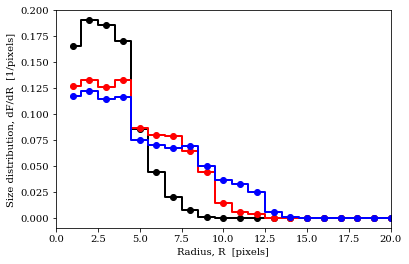

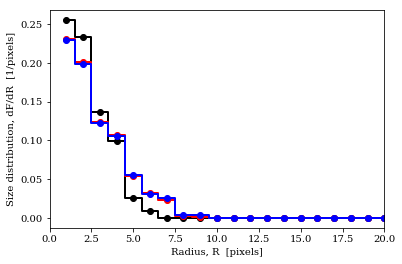

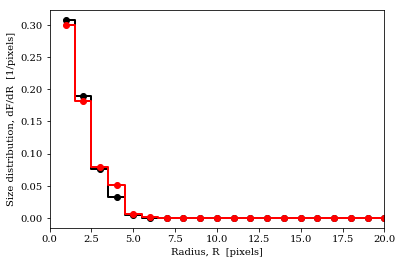

In [63]:
# Plot of granulometry
plt.figure()
plt.plot(R_arr[0][2][1:], dFdR_arr[0][2][1:], 'ko-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[1][2][1:], dFdR_arr[1][2][1:], 'ro-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[2][2][1:], dFdR_arr[2][2][1:], 'bo-',linewidth=2,drawstyle='steps-mid')

plt.xlabel('Radius, R  [pixels]')
plt.ylabel('Size distribution, dF/dR  [1/pixels]')
plt.xlim(0,20)
plt.show()

plt.figure()
plt.plot(R_arr[0][1][1:], dFdR_arr[0][1][1:], 'ko-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[1][1][1:], dFdR_arr[1][1][1:], 'ro-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[2][1][1:], dFdR_arr[2][1][1:], 'bo-',linewidth=2,drawstyle='steps-mid')

plt.xlabel('Radius, R  [pixels]')
plt.ylabel('Size distribution, dF/dR  [1/pixels]')
plt.xlim(0,20)
plt.show()

plt.figure()
plt.plot(R_arr[0][0][1:], dFdR_arr[0][0][1:], 'ko-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[1][0][1:], dFdR_arr[1][0][1:], 'ro-',linewidth=2,drawstyle='steps-mid')
#plt.plot(R_arr[2][0][1:], dFdR_arr[2][0][1:], 'bo-',linewidth=2,drawstyle='steps-mid')

plt.xlabel('Radius, R  [pixels]')
plt.ylabel('Size distribution, dF/dR  [1/pixels]')
plt.xlim(0,20)
plt.show()

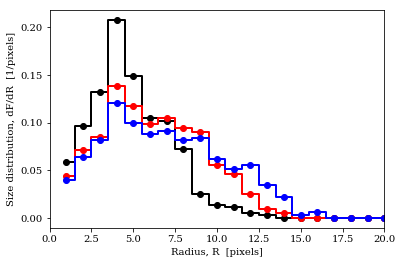

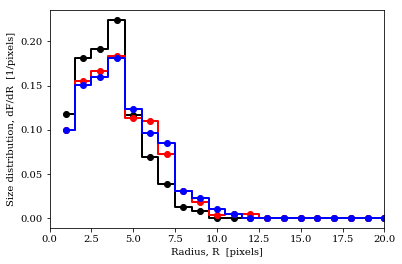

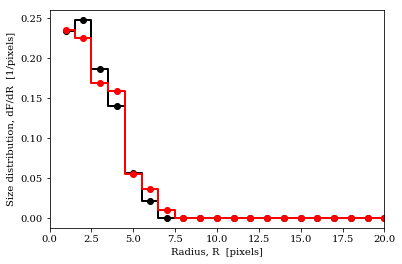

In [68]:
# Plot of granulometry 2
plt.figure()
plt.plot(R_arr[0][2][1:], dFdR_arr[0][2][1:], 'ko-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[1][2][1:], dFdR_arr[1][2][1:], 'ro-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[2][2][1:], dFdR_arr[2][2][1:], 'bo-',linewidth=2,drawstyle='steps-mid')

plt.xlabel('Radius, R  [pixels]')
plt.ylabel('Size distribution, dF/dR  [1/pixels]')
plt.xlim(0,20)
plt.show()

plt.figure()
plt.plot(R_arr[0][1][1:], dFdR_arr[0][1][1:], 'ko-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[1][1][1:], dFdR_arr[1][1][1:], 'ro-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[2][1][1:], dFdR_arr[2][1][1:], 'bo-',linewidth=2,drawstyle='steps-mid')

plt.xlabel('Radius, R  [pixels]')
plt.ylabel('Size distribution, dF/dR  [1/pixels]')
plt.xlim(0,20)
plt.show()

plt.figure()
plt.plot(R_arr[0][0][1:], dFdR_arr[0][0][1:], 'ko-',linewidth=2,drawstyle='steps-mid')
plt.plot(R_arr[1][0][1:], dFdR_arr[1][0][1:], 'ro-',linewidth=2,drawstyle='steps-mid')
#plt.plot(R_arr[2][0][1:], dFdR_arr[2][0][1:], 'bo-',linewidth=2,drawstyle='steps-mid')

plt.xlabel('Radius, R  [pixels]')
plt.ylabel('Size distribution, dF/dR  [1/pixels]')
plt.xlim(0,20)
plt.show()

In [ ]:
#Distance transform compare
hduin2  = fits.open('Simulations/Mock_128_R15/obs_hii_z9.000000.fits')[0]
hduin  = fits.open('Simulations/Mock_128_R8/obs_hii_z9.000000.fits')[0]
hduin3  = fits.open('Simulations/Mock_128_R25/obs_hii_z9.000000.fits')[0]


t = ndimage.distance_transform_edt(hduin.data)

yhist, xhist = np.histogram(t[t != 0].flatten(),normed=1, bins = np.linspace(0,15,14))

xh = np.where(yhist > 0)[0]
yh = yhist[xh]

def gaussian(x,a, mean, sigma):
    return a* np.exp(-((x - mean)**2 / (2 * sigma**2)))

popt, pcov = curve_fit(gaussian, xh, yh, [1, 2, 1])
plt.figure()
plt.plot(yhist)
i = np.linspace(0, 300, 301)
plt.plot(i, gaussian(i, *popt))
plt.xlim(0, 10)

print popt


t = ndimage.distance_transform_edt(hduin2.data)

yhist, xhist = np.histogram(t[t != 0].flatten(),normed=1, bins = np.linspace(0,15,14))

xh = np.where(yhist > 0)[0]
yh = yhist[xh]


popt, pcov = curve_fit(gaussian, xh, yh, [1, 2, 1])
plt.figure()
plt.plot(yhist)
i = np.linspace(0, 300, 301)
plt.plot(i, gaussian(i, *popt))
plt.xlim(0, 10)

print popt


t = ndimage.distance_transform_edt(hduin3.data)

yhist, xhist = np.histogram(t[t != 0].flatten(),normed=1, bins = np.linspace(0,15,14))

xh = np.where(yhist > 0)[0]
yh = yhist[xh]



popt, pcov = curve_fit(gaussian, xh, yh, [1, 2, 1])
plt.figure()
plt.plot(yhist)
i = np.linspace(0, 300, 301)
plt.plot(i, gaussian(i, *popt))
plt.xlim(0, 10)

print popt

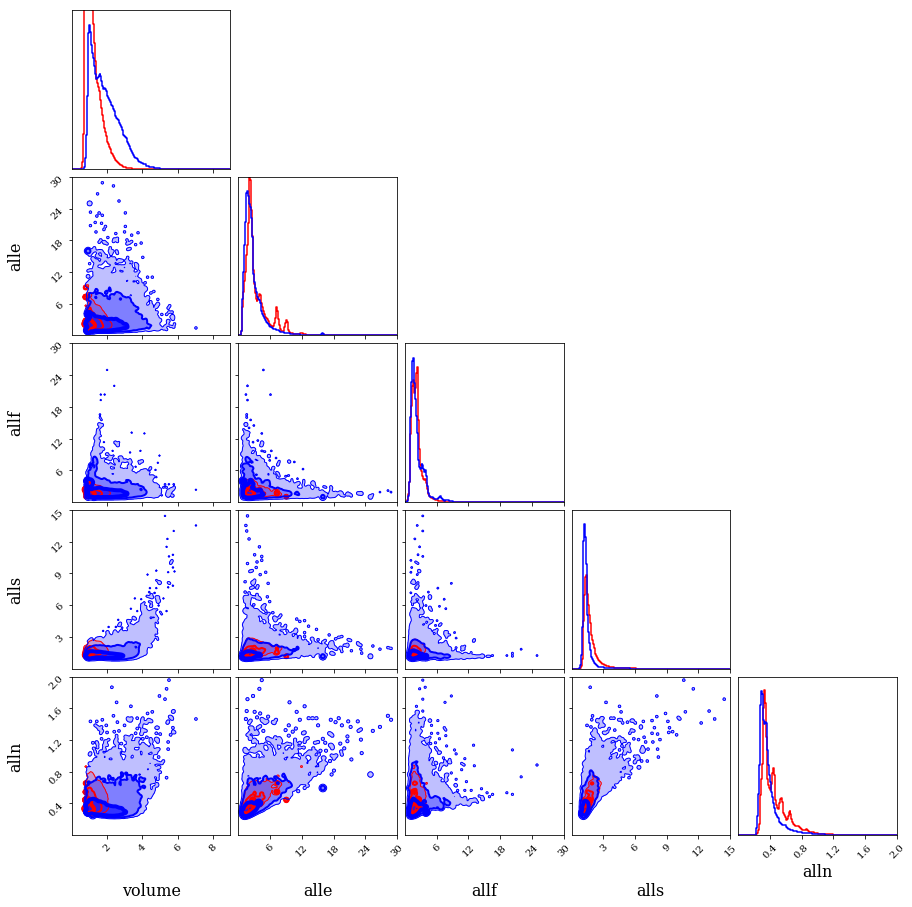

In [13]:
sys.path.append("/lib/python2.7/site-packages/src/corner/")

import corner

names = ['volume','alle','allf','alls','alln']
paramRanges = ((0,9),
               (0,30),
               (0,30),
              (0,15),
              (0,2))
released = {
    "linewidths" : (1,2,4),
    "colors" : ('r','r'),
 #   "alpha" : 0.1
    }
fig = corner.corner(D2[0],  evels=[0.682,0.95,00.9973], bins= 200, show_titles=False,\
                   labels = names,color='r', hist_bin_factor=1, smooth=1.5,range = paramRanges,\
                   smooth1d=1.5,fill_contours=True,contour_kwargs=released,label_kwargs={"fontsize":16},\
                   weights=np.ones(len(D2[0]))/len(D2[0]),plot_datapoints=False, plot_density = False,)
released = {
    "linewidths" : (1,2,4),
    "colors" : ('b','b'),
 #   "alpha" : 0.1
    }
corner.corner(D2[1], fig = fig, levels=[0.682,0.95,00.9973], bins= 200, show_titles=False,\
                   labels = names,color='b', hist_bin_factor=1, smooth=1.5,range = paramRanges,\
                   smooth1d=1.5,fill_contours=True,contour_kwargs=released,label_kwargs={"fontsize":16},\
                   weights=np.ones(len(D2[1]))/len(D2[1]),plot_datapoints=False, plot_density = False,)

fig.set_size_inches(13, 13)
axes = np.array(fig.axes).reshape((5, 5))